In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# How nangs works

In this notebook we show how nangs works. We will solve the following PDE:

\begin{equation}
    \frac{\partial \phi}{\partial t} + u \frac{\partial \phi}{\partial x} = 0
\end{equation}

The independent variables (i.e, $x$ and $t$) are used as input values for the NN, and the solution (i.e. $\phi$) is the output. In order to find the solution, at each step the NN outputs are derived w.r.t the inputs. Then, a loss function that matches the PDE is built and the weights are updated accordingly. If the loss function goes to zero, we can assume that our NN is indeed the solution to our PDE. 

In [2]:
# imports

import numpy as np 
import matplotlib.pyplot as plt 
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

torch.__version__

'1.11.0+cpu'

## Define your dataset

To solve the PDE we will give samples of inputs to the NN. The following function will sample values randomly.

In [3]:
def get_samples(batch_size=10, n_inputs=2):
    # return torch.rand((batch_size, n_inputs), requires_grad=True)     
    return torch.rand((batch_size, n_inputs)) 
"a"

'a'

In [4]:
X = get_samples(5, 2)
print("a")
x, t = X[:,0], X[:,1]

x, t


a


(tensor([0.8899, 0.5315, 0.5119, 0.8243, 0.5628]),
 tensor([0.0063, 0.5582, 0.5777, 0.9356, 0.3882]))

## Define your solution topology

We use a Multilayer Perceptron to approximate the solution to the PDE

In [5]:
import torch
import torch.nn as nn

class Sine(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return torch.sin(x)

mlp = nn.Sequential(
	nn.Linear(2, 100),
	Sine(), 
	nn.Linear(100, 100), 
	Sine(), 
	nn.Linear(100, 1)
)

mlp

Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): Sine()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): Sine()
  (4): Linear(in_features=100, out_features=1, bias=True)
)

In [6]:
# check output shape

output = mlp(X)

output.shape

torch.Size([5, 1])

## Boundary conditions

We can attempt to solve our PDE at this points, but we would obtain a trivial solution. Instead, we need to specify a set of boundary conditions.

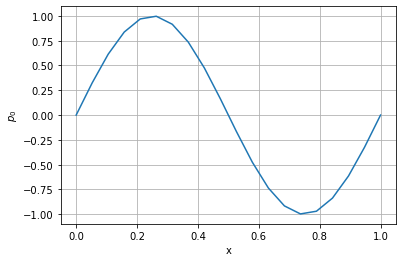

In [7]:
# initial condition (t = 0)

x= np.linspace(0, 1, 20)

p0 = np.sin(2*np.pi*x)

plt.plot(x, p0)
plt.grid(True)
plt.xlabel('x')
plt.ylabel('$p_0$')
plt.show()


In [8]:
def get_samples_ini(batch_size=100):
    x = torch.rand(batch_size)
    print(x)
    p0 = torch.sin(2.*np.pi*x).unsqueeze(1)
    return torch.stack([  
        x,
        torch.zeros(batch_size)
    ], axis=-1), p0
   

a=get_samples_ini(2)

a

tensor([0.3886, 0.2634])
yuca


(tensor([[0.3886, 0.0000],
         [0.2634, 0.0000]]),
 tensor([[0.6442],
         [0.9965]]))

In [9]:
# boundary conditions (peridic conditions at x = 0 and x = 1)

def get_samples_boco(batch_size=100):
    t = torch.rand(batch_size)
    X0 = torch.stack([  
        torch.zeros(batch_size),
        t
    ], axis=-1)
    X1 = torch.stack([  
        torch.ones(batch_size),
        t
    ], axis=-1)
    return X0, X1

a=get_samples_boco(2)
a

(tensor([[0.0000, 0.1983],
         [0.0000, 0.1025]]),
 tensor([[1.0000, 0.1983],
         [1.0000, 0.1025]]))

## Solve the PDE

We can now proceed with solving the PDE

In [10]:
BATCH_SIZE = 100
N_STEPS = 5000
U = 1

optimizer = torch.optim.Adam(mlp.parameters())
criterion = torch.nn.MSELoss()

hist = []
log_each = 500
for step in range(1, N_STEPS+1):

    # optimize for PDE
    X = get_samples(BATCH_SIZE, 2) # N, (X, T)
    X.requires_grad_(True)
    y_hat = mlp(X) # N, P 
    grads, = torch.autograd.grad(y_hat, X, grad_outputs=y_hat.data.new(y_hat.shape).fill_(1), create_graph=True, only_inputs=True)
    dpdx, dpdt = grads[:,0], grads[:,1]
    pde_loss = criterion(dpdt, - U*dpdx)

    # optimize for initial condition
    X, p0 = get_samples_ini(BATCH_SIZE)
    y_hat = mlp(X) # N, P0 
    ini_loss = criterion(y_hat, p0)  
    
    # optimize for boundary conditions
    X0, X1 = get_samples_boco(BATCH_SIZE)
    y_0 = mlp(X0) 
    y_1 = mlp(X1)
    bound_loss = criterion(y_0, y_1)

    # update
    optimizer.zero_grad()
    loss = pde_loss + ini_loss + bound_loss
    loss.backward()
    optimizer.step()
   
    hist.append(loss.item())
    if step % log_each == 0:
        print(f'{step}/{N_STEPS} pde_loss {pde_loss.item():.5f} ini_loss {ini_loss.item():.5f} bound_loss {bound_loss.item():.5f}')

tensor([0.0361, 0.7848, 0.2210, 0.3805, 0.9179, 0.2404, 0.2844, 0.5474, 0.7261,
        0.9267, 0.1516, 0.0886, 0.4353, 0.8566, 0.8714, 0.7498, 0.4655, 0.7702,
        0.7190, 0.8077, 0.3390, 0.9494, 0.4351, 0.7667, 0.0527, 0.2783, 0.6789,
        0.3684, 0.4253, 0.1991, 0.2346, 0.6072, 0.8200, 0.5056, 0.1256, 0.1344,
        0.1438, 0.5938, 0.5867, 0.5163, 0.1578, 0.2619, 0.6634, 0.0801, 0.4665,
        0.2737, 0.6837, 0.7085, 0.2683, 0.8533, 0.0490, 0.9888, 0.1208, 0.0701,
        0.0525, 0.7652, 0.6429, 0.4391, 0.1729, 0.2469, 0.7384, 0.9492, 0.9292,
        0.8350, 0.4076, 0.6113, 0.6927, 0.8137, 0.2709, 0.2579, 0.3824, 0.5731,
        0.2270, 0.1630, 0.1353, 0.4434, 0.1670, 0.5385, 0.8330, 0.5903, 0.8142,
        0.4471, 0.4774, 0.5092, 0.4476, 0.2432, 0.8546, 0.5194, 0.2384, 0.7339,
        0.8156, 0.1368, 0.1929, 0.5551, 0.0609, 0.8239, 0.7541, 0.5902, 0.1664,
        0.1801])
tensor([0.4877, 0.8306, 0.3458, 0.5199, 0.5904, 0.5335, 0.9205, 0.6099, 0.7461,
        0.8284, 0.9033,

tensor([0.6340, 0.5146, 0.8912, 0.2628, 0.7998, 0.3918, 0.8952, 0.7525, 0.0458,
        0.6798, 0.0505, 0.4653, 0.3492, 0.3073, 0.5507, 0.9652, 0.8702, 0.6044,
        0.3455, 0.2790, 0.3232, 1.0000, 0.3029, 0.2689, 0.7825, 0.5567, 0.9743,
        0.8391, 0.1023, 0.4004, 0.5368, 0.9287, 0.2628, 0.7480, 0.6352, 0.5484,
        0.4867, 0.8182, 0.6090, 0.9252, 0.0118, 0.2044, 0.0802, 0.7567, 0.7978,
        0.2933, 0.5596, 0.8062, 0.5488, 0.4889, 0.7156, 0.3028, 0.6924, 0.1625,
        0.7455, 0.6463, 0.8156, 0.6569, 0.6455, 0.1284, 0.6250, 0.1141, 0.6463,
        0.5285, 0.5498, 0.3042, 0.7112, 0.5029, 0.1260, 0.5138, 0.7088, 0.1433,
        0.7479, 0.4552, 0.3592, 0.3431, 0.4957, 0.6445, 0.9818, 0.9672, 0.4724,
        0.5070, 0.5178, 0.4033, 0.8498, 0.3217, 0.8769, 0.1031, 0.1048, 0.8803,
        0.1892, 0.4829, 0.7446, 0.6581, 0.9995, 0.6326, 0.0629, 0.7724, 0.4956,
        0.0572])
tensor([0.8814, 0.6724, 0.9598, 0.2076, 0.7694, 0.2720, 0.2298, 0.8682, 0.0194,
        0.4835, 0.7210,

tensor([0.3187, 0.4310, 0.1035, 0.4080, 0.5825, 0.8376, 0.5999, 0.1291, 0.4853,
        0.5199, 0.6198, 0.2202, 0.8034, 0.2781, 0.0596, 0.6046, 0.1397, 0.4667,
        0.9040, 0.8218, 0.5395, 0.6541, 0.3085, 0.6507, 0.8065, 0.7796, 0.9912,
        0.3199, 0.3542, 0.4019, 0.2067, 0.9170, 0.9252, 0.2930, 0.0495, 0.7671,
        0.9728, 0.1968, 0.1480, 0.2200, 0.9278, 0.5563, 0.1989, 0.1512, 0.6763,
        0.1446, 0.4094, 0.1767, 0.3544, 0.3759, 0.7201, 0.0930, 0.1996, 0.3895,
        0.6481, 0.1609, 0.6458, 0.7820, 0.9192, 0.2256, 0.6925, 0.9741, 0.9141,
        0.3378, 0.0969, 0.7338, 0.7181, 0.7901, 0.5340, 0.7528, 0.1357, 0.7669,
        0.0241, 0.2763, 0.6922, 0.1236, 0.8845, 0.7481, 0.9619, 0.9228, 0.7872,
        0.4772, 0.7206, 0.4655, 0.0707, 0.0969, 0.4030, 0.7625, 0.5429, 0.2354,
        0.8321, 0.0200, 0.8704, 0.9188, 0.4220, 0.9832, 0.0373, 0.7062, 0.4518,
        0.5082])
tensor([0.1504, 0.2909, 0.3378, 0.1266, 0.7555, 0.1288, 0.6174, 0.1069, 0.0622,
        0.6228, 0.3584,

tensor([0.1832, 0.7821, 0.2636, 0.3549, 0.6281, 0.4423, 0.1550, 0.0227, 0.2965,
        0.4913, 0.3609, 0.4614, 0.8271, 0.7962, 0.4863, 0.6644, 0.8702, 0.3266,
        0.5533, 0.4253, 0.9734, 0.7691, 0.8434, 0.3396, 0.5847, 0.6556, 0.6596,
        0.7501, 0.7773, 0.8485, 0.2840, 0.0750, 0.7470, 0.7022, 0.1672, 0.1467,
        0.3331, 0.3319, 0.9450, 0.1887, 0.5605, 0.0499, 0.8841, 0.7580, 0.6532,
        0.8530, 0.2531, 0.6449, 0.9882, 0.0776, 0.4231, 0.3256, 0.1383, 0.7300,
        0.5770, 0.1269, 0.9320, 0.7638, 0.9188, 0.4406, 0.3142, 0.6116, 0.9002,
        0.9759, 0.8835, 0.5249, 0.8675, 0.2368, 0.2210, 0.3408, 0.2565, 0.7538,
        0.5158, 0.5510, 0.2453, 0.0227, 0.3366, 0.8377, 0.9490, 0.1336, 0.4408,
        0.7517, 0.3145, 0.6298, 0.7702, 0.1009, 0.0879, 0.7712, 0.3164, 0.3732,
        0.1327, 0.0662, 0.4539, 0.4150, 0.1647, 0.9505, 0.9837, 0.3949, 0.1612,
        0.5850])
tensor([0.6453, 0.5617, 0.7591, 0.1711, 0.7575, 0.4835, 0.6119, 0.5739, 0.8132,
        0.5184, 0.3397,

tensor([0.0900, 0.0371, 0.5310, 0.9412, 0.9792, 0.3157, 0.4943, 0.7154, 0.0389,
        0.8057, 0.6732, 0.2312, 0.0953, 0.0833, 0.0549, 0.1378, 0.0875, 0.7801,
        0.5997, 0.0300, 0.2838, 0.8576, 0.7795, 0.4921, 0.2825, 0.9136, 0.2861,
        0.2968, 0.6155, 0.2303, 0.8529, 0.8282, 0.7872, 0.2673, 0.2059, 0.5398,
        0.5443, 0.9747, 0.8442, 0.6700, 0.4739, 0.1325, 0.2788, 0.6564, 0.3272,
        0.3795, 0.2472, 0.1808, 0.1902, 0.1555, 0.1696, 0.8162, 0.0703, 0.8158,
        0.9923, 0.1976, 0.0852, 0.3367, 0.2544, 0.7405, 0.3144, 0.3512, 0.9904,
        0.1770, 0.6839, 0.4606, 0.1546, 0.7444, 0.4455, 0.6393, 0.3738, 0.4151,
        0.2187, 0.2416, 0.4919, 0.5582, 0.3717, 0.1861, 0.9684, 0.4314, 0.8184,
        0.5601, 0.4708, 0.0382, 0.3030, 0.7115, 0.5125, 0.4825, 0.8553, 0.7312,
        0.9408, 0.4037, 0.5096, 0.9592, 0.7126, 0.2807, 0.4290, 0.8730, 0.9907,
        0.5871])
tensor([0.7963, 0.3074, 0.8108, 0.2399, 0.2053, 0.0324, 0.4036, 0.7989, 0.7017,
        0.2369, 0.5522,

tensor([9.0075e-01, 3.2153e-01, 2.7965e-01, 5.6744e-01, 7.1094e-01, 8.8716e-01,
        6.1092e-01, 9.6774e-01, 3.5117e-01, 7.2041e-01, 8.3157e-01, 5.2661e-01,
        4.9324e-01, 1.4219e-01, 2.6419e-01, 2.2423e-01, 4.4512e-01, 4.4436e-01,
        4.0765e-02, 1.2922e-01, 8.9089e-01, 6.5256e-01, 4.3038e-01, 4.8528e-01,
        8.1006e-01, 4.9904e-01, 1.8487e-01, 4.9382e-01, 4.9977e-01, 5.9579e-01,
        1.5467e-01, 6.0806e-01, 9.0865e-01, 7.8191e-01, 3.7106e-02, 7.3608e-01,
        8.8425e-01, 5.3483e-04, 9.9434e-01, 4.0807e-01, 4.8306e-01, 4.2968e-01,
        8.8512e-01, 8.1057e-01, 6.5876e-01, 9.4824e-01, 9.2274e-01, 5.5969e-01,
        2.7604e-01, 7.5670e-03, 5.5942e-01, 2.9918e-01, 4.2539e-01, 1.6953e-01,
        7.6632e-01, 2.2441e-01, 4.9351e-01, 5.7319e-01, 1.2058e-01, 7.4984e-01,
        1.7003e-01, 3.3688e-01, 4.3887e-01, 7.5949e-01, 6.5550e-01, 4.8541e-01,
        9.6581e-01, 2.4977e-01, 7.7740e-01, 5.1448e-01, 1.0857e-01, 3.3854e-01,
        1.4878e-01, 3.3555e-01, 5.2402e-

tensor([0.1629, 0.1092, 0.6774, 0.8680, 0.2336, 0.0205, 0.8778, 0.7880, 0.7562,
        0.5413, 0.7248, 0.7023, 0.7856, 0.5020, 0.2722, 0.4348, 0.5129, 0.4440,
        0.0595, 0.3008, 0.9042, 0.2246, 0.0144, 0.0146, 0.9113, 0.6675, 0.6002,
        0.6929, 0.2653, 0.9673, 0.4170, 0.7339, 0.9696, 0.4459, 0.0400, 0.6590,
        0.3243, 0.6314, 0.6057, 0.9857, 0.8299, 0.4529, 0.8901, 0.2633, 0.4150,
        0.8558, 0.6088, 0.4228, 0.6968, 0.3617, 0.7619, 0.5332, 0.4496, 0.2014,
        0.8437, 0.9733, 0.0737, 0.3436, 0.9347, 0.1515, 0.0202, 0.9276, 0.9381,
        0.1707, 0.8019, 0.6460, 0.6126, 0.4483, 0.5770, 0.8425, 0.2989, 0.2528,
        0.3218, 0.6306, 0.0666, 0.0989, 0.4801, 0.3557, 0.5662, 0.1372, 0.4133,
        0.1773, 0.4804, 0.3378, 0.0556, 0.2911, 0.4043, 0.8161, 0.4975, 0.0560,
        0.1788, 0.4703, 0.1256, 0.7195, 0.8973, 0.9474, 0.2847, 0.6253, 0.7299,
        0.5019])
tensor([4.0921e-01, 9.5026e-01, 5.8595e-01, 2.2298e-01, 9.9999e-01, 4.9141e-01,
        8.0841e-01, 7.6

tensor([0.2617, 0.3663, 0.8970, 0.9482, 0.1440, 0.3805, 0.2297, 0.8151, 0.8964,
        0.6825, 0.4511, 0.5360, 0.3320, 0.9659, 0.7575, 0.0935, 0.4405, 0.9456,
        0.9158, 0.4377, 0.4276, 0.1203, 0.8538, 0.7691, 0.0969, 0.8883, 0.8850,
        0.0955, 0.4612, 0.4134, 0.9790, 0.8256, 0.0826, 0.7407, 0.4948, 0.9784,
        0.4747, 0.9120, 0.5463, 0.7081, 0.5524, 0.6476, 0.4599, 0.7772, 0.2658,
        0.7252, 0.3442, 0.8794, 0.9023, 0.5299, 0.6977, 0.2614, 0.6365, 0.1117,
        0.2198, 0.0149, 0.0626, 0.6140, 0.2498, 0.3537, 0.7460, 0.0152, 0.7576,
        0.5105, 0.5655, 0.9136, 0.5319, 0.5557, 0.6165, 0.8039, 0.5665, 0.0749,
        0.5638, 0.8217, 0.3182, 0.9231, 0.0987, 0.2612, 0.0440, 0.7318, 0.6718,
        0.1217, 0.9617, 0.7466, 0.9497, 0.7097, 0.9823, 0.3743, 0.6151, 0.2791,
        0.5180, 0.4726, 0.2291, 0.8815, 0.0717, 0.6355, 0.6581, 0.3154, 0.2804,
        0.4895])
tensor([0.8011, 0.4304, 0.9427, 0.7196, 0.6371, 0.6963, 0.1159, 0.9509, 0.3661,
        0.4975, 0.5375,

tensor([0.7394, 0.9410, 0.4737, 0.2123, 0.6209, 0.4458, 0.3965, 0.2027, 0.6066,
        0.3343, 0.8018, 0.6126, 0.5584, 0.2689, 0.8725, 0.9271, 0.1806, 0.6996,
        0.5115, 0.8048, 0.5165, 0.1126, 0.0379, 0.4651, 0.4631, 0.7029, 0.7521,
        0.3033, 0.3164, 0.2092, 0.3674, 0.1829, 0.9926, 0.9841, 0.1901, 0.0156,
        0.6904, 0.0554, 0.2630, 0.0707, 0.4359, 0.5853, 0.4057, 0.8201, 0.2779,
        0.0301, 0.0903, 0.3866, 0.3016, 0.1015, 0.7914, 0.7711, 0.1635, 0.0896,
        0.1877, 0.5685, 0.2770, 0.4104, 0.0705, 0.8942, 0.8134, 0.1443, 0.5153,
        0.5852, 0.6384, 0.2145, 0.1810, 0.9851, 0.7013, 0.8690, 0.6757, 0.9951,
        0.8730, 0.0501, 0.0756, 0.7151, 0.8867, 0.4884, 0.9657, 0.1223, 0.5046,
        0.9088, 0.1652, 0.5089, 0.3574, 0.0302, 0.1161, 0.2398, 0.1543, 0.7012,
        0.2311, 0.3738, 0.5209, 0.9772, 0.8428, 0.2905, 0.4017, 0.2816, 0.8729,
        0.5143])
tensor([7.2802e-01, 9.7129e-01, 6.4480e-01, 1.9563e-01, 8.3219e-01, 5.3707e-01,
        9.9947e-01, 9.8

tensor([0.9698, 0.3983, 0.4934, 0.8207, 0.3232, 0.0682, 0.9598, 0.3991, 0.0092,
        0.8707, 0.1503, 0.8997, 0.8001, 0.7876, 0.4536, 0.7433, 0.2449, 0.9167,
        0.3849, 0.8348, 0.8901, 0.9318, 0.9220, 0.9740, 0.3295, 0.9743, 0.7867,
        0.1148, 0.8143, 0.2336, 0.9921, 0.9943, 0.7672, 0.7579, 0.2164, 0.7850,
        0.6383, 0.4909, 0.0785, 0.3628, 0.8560, 0.5344, 0.5722, 0.3120, 0.4852,
        0.7740, 0.6818, 0.5249, 0.2088, 0.3970, 0.0645, 0.9014, 0.6458, 0.3585,
        0.9263, 0.7049, 0.6697, 0.4180, 0.7808, 0.6322, 0.1345, 0.6760, 0.5158,
        0.6477, 0.9286, 0.1227, 0.1799, 0.5877, 0.7457, 0.5815, 0.4285, 0.4951,
        0.2001, 0.7576, 0.6386, 0.9348, 0.4067, 0.8801, 0.7215, 0.3844, 0.7283,
        0.4349, 0.2310, 0.2495, 0.3967, 0.3289, 0.0415, 0.2900, 0.0433, 0.8856,
        0.7036, 0.1119, 0.5461, 0.9848, 0.3219, 0.7692, 0.9339, 0.4511, 0.4753,
        0.9375])
tensor([0.0925, 0.6697, 0.2664, 0.0016, 0.1659, 0.2420, 0.0284, 0.5654, 0.9628,
        0.5098, 0.7756,

tensor([0.9726, 0.6541, 0.9702, 0.9392, 0.5392, 0.6018, 0.1168, 0.2333, 0.4508,
        0.3986, 0.6141, 0.4430, 0.7709, 0.6623, 0.5216, 0.2059, 0.7630, 0.9789,
        0.1025, 0.4892, 0.0164, 0.4866, 0.2377, 0.5353, 0.4953, 0.2677, 0.5360,
        0.4648, 0.4986, 0.7135, 0.2399, 0.8312, 0.3754, 0.6157, 0.1799, 0.1025,
        0.7220, 0.3852, 0.2834, 0.2341, 0.9484, 0.2488, 0.3422, 0.4813, 0.1779,
        0.3536, 0.3346, 0.0368, 0.7558, 0.5332, 0.2957, 0.2005, 0.5476, 0.3108,
        0.0579, 0.3032, 0.9729, 0.3072, 0.1719, 0.1402, 0.3772, 0.1905, 0.5809,
        0.7782, 0.6733, 0.9598, 0.6237, 0.3007, 0.0990, 0.1027, 0.0541, 0.1696,
        0.1544, 0.0124, 0.2055, 0.8740, 0.4528, 0.5755, 0.1702, 0.8368, 0.0966,
        0.0680, 0.0657, 0.4320, 0.8896, 0.5778, 0.2912, 0.8887, 0.0602, 0.9758,
        0.1479, 0.4754, 0.2578, 0.7854, 0.1330, 0.7241, 0.7082, 0.7495, 0.2018,
        0.7789])
tensor([0.6816, 0.3446, 0.7625, 0.0479, 0.8955, 0.2384, 0.2619, 0.2418, 0.9628,
        0.8929, 0.0979,

tensor([0.1410, 0.0543, 0.4224, 0.4398, 0.8811, 0.5770, 0.6521, 0.8077, 0.5764,
        0.3214, 0.1627, 0.3318, 0.3662, 0.0436, 0.2127, 0.2383, 0.9717, 0.0055,
        0.2281, 0.9521, 0.5845, 0.4755, 0.3915, 0.9217, 0.0053, 0.4885, 0.9211,
        0.6000, 0.3591, 0.8253, 0.6503, 0.2264, 0.0414, 0.5052, 0.2933, 0.2538,
        0.4800, 0.3797, 0.5079, 0.5008, 0.9611, 0.0691, 0.6750, 0.2669, 0.8697,
        0.8993, 0.0733, 0.5945, 0.3756, 0.4494, 0.7980, 0.9383, 0.7223, 0.7162,
        0.6783, 0.5301, 0.5022, 0.6476, 0.0146, 0.0031, 0.7653, 0.0751, 0.3639,
        0.8079, 0.0495, 0.7709, 0.5796, 0.2201, 0.6630, 0.4696, 0.1645, 0.7662,
        0.2937, 0.9542, 0.6653, 0.8401, 0.0656, 0.3658, 0.7299, 0.7594, 0.5323,
        0.2179, 0.6207, 0.8917, 0.5262, 0.1686, 0.8545, 0.8101, 0.0285, 0.8742,
        0.8140, 0.4495, 0.9740, 0.1908, 0.5467, 0.5558, 0.7596, 0.7033, 0.4640,
        0.7681])
tensor([0.1568, 0.9534, 0.5166, 0.5005, 0.0286, 0.6642, 0.9859, 0.3654, 0.4269,
        0.9381, 0.5120,

tensor([0.3969, 0.6112, 0.6014, 0.4295, 0.9508, 0.7619, 0.6948, 0.3266, 0.3603,
        0.8686, 0.4765, 0.3602, 0.5510, 0.9415, 0.5368, 0.4479, 0.4986, 0.1224,
        0.9772, 0.7045, 0.6610, 0.5098, 0.9934, 0.4755, 0.0996, 0.7019, 0.0790,
        0.3109, 0.4266, 0.3709, 0.9694, 0.3262, 0.5514, 0.9570, 0.8455, 0.2307,
        0.3214, 0.3043, 0.2449, 0.1317, 0.3716, 0.8809, 0.4500, 0.7088, 0.1622,
        0.7522, 0.4083, 0.6787, 0.1797, 0.9623, 0.1672, 0.5255, 0.9232, 0.1410,
        0.4167, 0.5280, 0.1783, 0.7254, 0.1766, 0.3916, 0.5994, 0.0356, 0.2101,
        0.1186, 0.5373, 0.7324, 0.0674, 0.6390, 0.4805, 0.7508, 0.0741, 0.0720,
        0.6419, 0.3824, 0.8308, 0.0950, 0.4264, 0.3028, 0.9202, 0.8207, 0.9094,
        0.5647, 0.2697, 0.2353, 0.2837, 0.8142, 0.8323, 0.3191, 0.1127, 0.9446,
        0.5092, 0.0265, 0.9934, 0.4631, 0.8510, 0.1718, 0.4012, 0.9610, 0.3283,
        0.5761])
tensor([0.1813, 0.1335, 0.6146, 0.2535, 0.1706, 0.1934, 0.1524, 0.6835, 0.2638,
        0.6543, 0.0836,

tensor([0.8856, 0.6818, 0.0778, 0.2121, 0.8732, 0.7406, 0.9063, 0.7636, 0.1880,
        0.3125, 0.2991, 0.7192, 0.9234, 0.8034, 0.6923, 0.2766, 0.1974, 0.8587,
        0.1185, 0.5071, 0.6254, 0.1787, 0.8432, 0.4502, 0.9603, 0.5975, 0.1076,
        0.7512, 0.6402, 0.4674, 0.3405, 0.7055, 0.9472, 0.8131, 0.5606, 0.6406,
        0.2374, 0.8239, 0.0751, 0.3397, 0.7208, 0.0745, 0.9866, 0.0749, 0.4729,
        0.7307, 0.8159, 0.5477, 0.8750, 0.5675, 0.4510, 0.7321, 0.6960, 0.2277,
        0.8662, 0.8549, 0.1370, 0.5125, 0.1757, 0.6757, 0.3242, 0.3800, 0.2042,
        0.6229, 0.4071, 0.1308, 0.4656, 0.9276, 0.1021, 0.3759, 0.9906, 0.4284,
        0.3534, 0.7384, 0.9753, 0.7412, 0.5742, 0.2844, 0.1872, 0.3595, 0.0890,
        0.9270, 0.1769, 0.2513, 0.8972, 0.7742, 0.4587, 0.8416, 0.0420, 0.8058,
        0.8943, 0.9371, 0.7352, 0.3699, 0.5907, 0.7984, 0.7713, 0.2856, 0.3049,
        0.3027])
tensor([0.0408, 0.0247, 0.4296, 0.1526, 0.5142, 0.9056, 0.9573, 0.1950, 0.5081,
        0.5890, 0.7224,

tensor([0.4775, 0.5007, 0.5241, 0.0689, 0.0384, 0.4854, 0.0924, 0.2813, 0.3345,
        0.7827, 0.2441, 0.2856, 0.2408, 0.1784, 0.8853, 0.0836, 0.7738, 0.6749,
        0.2717, 0.8276, 0.6418, 0.7869, 0.0801, 0.9593, 0.5313, 0.6847, 0.9022,
        0.7192, 0.8006, 0.7900, 0.5105, 0.7915, 0.1670, 0.6683, 0.4712, 0.9687,
        0.9349, 0.5022, 0.7837, 0.1090, 0.7035, 0.7033, 0.1423, 0.6940, 0.4866,
        0.0608, 0.9798, 0.3478, 0.0932, 0.9780, 0.9375, 0.3941, 0.0428, 0.8275,
        0.0768, 0.7992, 0.5528, 0.1339, 0.5539, 0.9862, 0.4035, 0.8414, 0.3772,
        0.3247, 0.5084, 0.3086, 0.2309, 0.3949, 0.3316, 0.1385, 0.3503, 0.5827,
        0.2079, 0.5618, 0.1120, 0.8081, 0.1444, 0.7586, 0.4681, 0.7552, 0.1209,
        0.9068, 0.9453, 0.9360, 0.0831, 0.1281, 0.8374, 0.4056, 0.0449, 0.9312,
        0.3786, 0.5597, 0.7688, 0.2440, 0.1713, 0.3571, 0.6463, 0.3240, 0.1003,
        0.6059])
tensor([0.8928, 0.1778, 0.5058, 0.2799, 0.5385, 0.5966, 0.7643, 0.8012, 0.3786,
        0.0917, 0.5325,

tensor([0.8936, 0.4415, 0.4442, 0.1353, 0.6483, 0.3368, 0.1897, 0.8986, 0.2951,
        0.2934, 0.5318, 0.1613, 0.3490, 0.4573, 0.3690, 0.5748, 0.9611, 0.8567,
        0.6601, 0.2388, 0.8107, 0.4228, 0.0445, 0.9052, 0.1186, 0.0841, 0.3554,
        0.5671, 0.7007, 0.1698, 0.1682, 0.7578, 0.9934, 0.5734, 0.5195, 0.5782,
        0.7801, 0.2394, 0.2185, 0.4206, 0.8797, 0.6811, 0.4953, 0.8598, 0.8118,
        0.5246, 0.4245, 0.3410, 0.2949, 0.0175, 0.1734, 0.0120, 0.5562, 0.6203,
        0.5006, 0.7953, 0.2584, 0.7766, 0.3781, 0.6633, 0.3444, 0.9872, 0.4958,
        0.3998, 0.9842, 0.1667, 0.9448, 0.6406, 0.1841, 0.7121, 0.3147, 0.9236,
        0.5334, 0.5208, 0.3497, 0.4950, 0.9027, 0.7010, 0.9589, 0.7182, 0.3758,
        0.9220, 0.4204, 0.4298, 0.3396, 0.5658, 0.0986, 0.6496, 0.9204, 0.4691,
        0.1896, 0.7933, 0.5852, 0.2042, 0.6387, 0.3343, 0.1894, 0.6210, 0.8282,
        0.2834])
tensor([0.8605, 0.6598, 0.1966, 0.7008, 0.2178, 0.3952, 0.6646, 0.2102, 0.0049,
        0.8556, 0.4068,

tensor([0.4453, 0.1752, 0.7334, 0.0901, 0.2856, 0.8261, 0.6725, 0.3826, 0.3875,
        0.0273, 0.8712, 0.1832, 0.1164, 0.2051, 0.1160, 0.9318, 0.9691, 0.1790,
        0.8268, 0.3534, 0.3651, 0.5634, 0.5607, 0.1429, 0.9339, 0.7704, 0.5060,
        0.4378, 0.1706, 0.1838, 0.2447, 0.1305, 0.1084, 0.3878, 0.7345, 0.0721,
        0.2158, 0.4778, 0.2461, 0.7049, 0.5553, 0.5783, 0.5152, 0.9182, 0.7126,
        0.0475, 0.9785, 0.6061, 0.8456, 0.2550, 0.4719, 0.3305, 0.0855, 0.3195,
        0.1027, 0.7039, 0.9027, 0.8649, 0.2745, 0.0974, 0.6107, 0.9347, 0.6493,
        0.9629, 0.2239, 0.7551, 0.4354, 0.3581, 0.7222, 0.6442, 0.1513, 0.0466,
        0.1933, 0.3244, 0.6109, 0.0130, 0.8610, 0.4409, 0.2286, 0.9983, 0.2446,
        0.5204, 0.7814, 0.1967, 0.2047, 0.2546, 0.4128, 0.3751, 0.7081, 0.3038,
        0.5109, 0.7954, 0.0436, 0.1266, 0.5676, 0.6862, 0.7097, 0.8937, 0.7680,
        0.5352])
tensor([0.5781, 0.3572, 0.7045, 0.9361, 0.2743, 0.4235, 0.8156, 0.3070, 0.8233,
        0.9275, 0.2642,

tensor([0.6117, 0.5137, 0.6193, 0.5181, 0.3210, 0.2186, 0.7162, 0.4897, 0.7451,
        0.4247, 0.4018, 0.1815, 0.4076, 0.4556, 0.2873, 0.6997, 0.7648, 0.6157,
        0.9290, 0.0496, 0.2439, 0.9286, 0.4601, 0.3242, 0.0084, 0.3341, 0.4133,
        0.8931, 0.5011, 0.3092, 0.0347, 0.8765, 0.4409, 0.1923, 0.5899, 0.6379,
        0.5108, 0.0879, 0.8273, 0.9968, 0.4577, 0.1556, 0.7596, 0.4068, 0.9221,
        0.2984, 0.1713, 0.7823, 0.6559, 0.6740, 0.4410, 0.3468, 0.8681, 0.1658,
        0.2511, 0.1437, 0.4028, 0.5929, 0.7803, 0.5030, 0.2931, 0.6517, 0.9325,
        0.1255, 0.9156, 0.9926, 0.7602, 0.2139, 0.9747, 0.3362, 0.3977, 0.1688,
        0.9365, 0.5228, 0.4963, 0.0029, 0.9662, 0.3369, 0.4102, 0.2840, 0.8857,
        0.4337, 0.4901, 0.3609, 0.5878, 0.1985, 0.0769, 0.9414, 0.8242, 0.6138,
        0.6829, 0.1796, 0.9504, 0.3182, 0.9213, 0.4627, 0.0475, 0.5945, 0.3623,
        0.7058])
tensor([0.8876, 0.4052, 0.0715, 0.5187, 0.1517, 0.5492, 0.8405, 0.3662, 0.6005,
        0.1695, 0.5846,

tensor([0.4723, 0.3504, 0.3481, 0.1716, 0.6359, 0.2129, 0.2969, 0.5989, 0.2230,
        0.3795, 0.5490, 0.4841, 0.5394, 0.5341, 0.0530, 0.3932, 0.7757, 0.8410,
        0.0967, 0.8086, 0.3841, 0.8001, 0.3718, 0.3186, 0.7797, 0.4497, 0.2805,
        0.4562, 0.7536, 0.8912, 0.7836, 0.7329, 0.9668, 0.7752, 0.1647, 0.2137,
        0.6680, 0.2985, 0.9062, 0.6735, 0.8355, 0.8000, 0.7465, 0.6791, 0.9189,
        0.5828, 0.6114, 0.3273, 0.6790, 0.8349, 0.4458, 0.0099, 0.8551, 0.1019,
        0.3023, 0.8020, 0.6248, 0.2335, 0.7162, 0.9143, 0.0127, 0.1345, 0.8859,
        0.8424, 0.4060, 0.5364, 0.8901, 0.0992, 0.6114, 0.3672, 0.5844, 0.4280,
        0.5801, 0.6228, 0.7137, 0.2141, 0.0607, 0.3064, 0.8245, 0.0316, 0.0871,
        0.2030, 0.7320, 0.0386, 0.1687, 0.0722, 0.5798, 0.4865, 0.1826, 0.2869,
        0.6747, 0.0882, 0.4428, 0.0824, 0.4439, 0.6047, 0.8568, 0.8605, 0.0855,
        0.6748])
tensor([0.9439, 0.5294, 0.6531, 0.0526, 0.4022, 0.6004, 0.0394, 0.7274, 0.5306,
        0.1576, 0.6302,

tensor([0.5122, 0.0860, 0.7650, 0.1991, 0.4849, 0.9029, 0.8883, 0.2088, 0.0569,
        0.5834, 0.0295, 0.5550, 0.0996, 0.7803, 0.7844, 0.8235, 0.4422, 0.7929,
        0.0079, 0.3063, 0.3567, 0.4294, 0.2679, 0.1824, 0.8648, 0.2518, 0.0546,
        0.2945, 0.1629, 0.7881, 0.3867, 0.0820, 0.7520, 0.5856, 0.6133, 0.2572,
        0.3406, 0.1745, 0.2652, 0.3683, 0.7518, 0.7128, 0.8762, 0.2150, 0.4664,
        0.2855, 0.0724, 0.8597, 0.2710, 0.2822, 0.9514, 0.1324, 0.1112, 0.1771,
        0.4010, 0.3116, 0.3968, 0.5527, 0.9942, 0.3411, 0.2733, 0.7136, 0.0989,
        0.8556, 0.9502, 0.5284, 0.1954, 0.3796, 0.3633, 0.1121, 0.3011, 0.2209,
        0.3436, 0.4253, 0.0997, 0.0501, 0.1881, 0.3856, 0.9930, 0.1553, 0.7825,
        0.2955, 0.9304, 0.7013, 0.5055, 0.8729, 0.0186, 0.6857, 0.7944, 0.7785,
        0.6307, 0.9764, 0.4414, 0.1803, 0.0067, 0.7786, 0.8207, 0.1762, 0.7051,
        0.5149])
tensor([0.5375, 0.8581, 0.2037, 0.5568, 0.7974, 0.5230, 0.0345, 0.4514, 0.2826,
        0.8860, 0.9263,

tensor([0.4121, 0.9898, 0.4343, 0.9627, 0.0734, 0.1106, 0.0813, 0.3098, 0.0353,
        0.6995, 0.1027, 0.3518, 0.7706, 0.7151, 0.7661, 0.4476, 0.3555, 0.9951,
        0.5294, 0.2359, 0.8095, 0.1386, 0.9283, 0.3858, 0.3553, 0.8889, 0.4295,
        0.4831, 0.9597, 0.7452, 0.2909, 0.7166, 0.1476, 0.4633, 0.2940, 0.5647,
        0.1170, 0.4616, 0.8065, 0.7760, 0.0360, 0.5049, 0.3361, 0.9462, 0.7537,
        0.1076, 0.4464, 0.1220, 0.7932, 0.4117, 0.2953, 0.7598, 0.5658, 0.9456,
        0.4056, 0.8074, 0.2316, 0.0318, 0.5986, 0.6462, 0.0302, 0.5041, 0.8288,
        0.8545, 0.7007, 0.0605, 0.6205, 0.0709, 0.3847, 0.9194, 0.5766, 0.5071,
        0.9321, 0.3398, 0.1074, 0.6739, 0.7094, 0.8756, 0.3045, 0.1630, 0.8858,
        0.7061, 0.8168, 0.7232, 0.6281, 0.9106, 0.8924, 0.2423, 0.4054, 0.7545,
        0.6771, 0.8309, 0.0599, 0.6626, 0.7253, 0.7310, 0.4745, 0.7667, 0.1912,
        0.6581])
tensor([0.1665, 0.7998, 0.4972, 0.3166, 0.8629, 0.1934, 0.4559, 0.5258, 0.1837,
        0.7316, 0.2744,

tensor([3.6993e-01, 2.9954e-01, 6.0268e-01, 9.2382e-01, 4.1552e-01, 1.7372e-01,
        4.8056e-01, 2.9933e-01, 7.8595e-01, 1.8832e-01, 7.0190e-01, 5.4016e-01,
        3.6413e-01, 5.2254e-03, 5.9498e-02, 9.8545e-01, 5.2083e-01, 4.6693e-01,
        4.9790e-01, 1.8890e-01, 9.4516e-01, 1.9019e-01, 9.8713e-01, 1.7870e-01,
        8.2226e-01, 5.1143e-01, 4.7581e-01, 9.9514e-01, 5.3769e-01, 4.3780e-01,
        1.6484e-01, 3.0716e-01, 7.9598e-01, 3.4882e-02, 2.4619e-01, 2.6542e-01,
        2.0524e-01, 5.3908e-02, 7.4305e-01, 7.5200e-01, 2.0220e-02, 9.1515e-01,
        8.1523e-01, 1.1481e-01, 5.4561e-01, 6.8060e-01, 4.2435e-01, 9.6892e-02,
        4.4897e-01, 8.9679e-01, 3.6173e-01, 9.8979e-01, 2.0461e-01, 9.0973e-01,
        9.3519e-01, 3.7762e-01, 4.0022e-01, 9.8462e-01, 3.4411e-01, 7.7624e-01,
        8.1051e-01, 5.9354e-01, 2.9233e-01, 4.7283e-01, 5.8009e-01, 5.4896e-01,
        8.6034e-02, 4.2914e-01, 5.1552e-01, 3.4690e-01, 8.4188e-01, 1.1005e-01,
        9.0586e-01, 3.2765e-01, 5.1266e-

tensor([0.5286, 0.5866, 0.8872, 0.6261, 0.8771, 0.3295, 0.9998, 0.8162, 0.3055,
        0.3205, 0.9401, 0.4750, 0.5580, 0.8827, 0.8108, 0.4859, 0.6367, 0.8353,
        0.2116, 0.1282, 0.5061, 0.5657, 0.3938, 0.9264, 0.4623, 0.4641, 0.4156,
        0.2605, 0.5079, 0.9120, 0.8836, 0.7240, 0.7902, 0.7095, 0.8203, 0.0188,
        0.0032, 0.4393, 0.4044, 0.4198, 0.2398, 0.5804, 0.4148, 0.2523, 0.2653,
        0.9951, 0.0218, 0.7366, 0.5080, 0.2065, 0.3229, 0.2568, 0.1452, 0.3650,
        0.6311, 0.2775, 0.3595, 0.2251, 0.3272, 0.4876, 0.9590, 0.2352, 0.6433,
        0.5433, 0.2049, 0.9149, 0.9979, 0.3733, 0.4791, 0.0488, 0.4196, 0.1213,
        0.3147, 0.2298, 0.1690, 0.4944, 0.8647, 0.8137, 0.2056, 0.8558, 0.2075,
        0.9899, 0.0255, 0.5998, 0.3886, 0.4803, 0.3722, 0.2825, 0.8541, 0.2661,
        0.1925, 0.0507, 0.7402, 0.8871, 0.0384, 0.1884, 0.0493, 0.2340, 0.1860,
        0.2434])
tensor([2.9356e-01, 5.5240e-01, 9.8244e-01, 7.9683e-01, 2.0974e-01, 5.5132e-01,
        4.2964e-01, 8.5

tensor([0.1939, 0.2296, 0.5617, 0.1473, 0.5665, 0.6239, 0.2235, 0.8453, 0.0809,
        0.0975, 0.3533, 0.9462, 0.1926, 0.3203, 0.6752, 0.1183, 0.0132, 0.7885,
        0.4577, 0.8702, 0.4091, 0.4943, 0.4039, 0.8409, 0.4811, 0.8440, 0.3901,
        0.4528, 0.7602, 0.3257, 0.5199, 0.3805, 0.4522, 0.9106, 0.3681, 0.5166,
        0.6108, 0.6894, 0.0148, 0.6351, 0.1785, 0.3847, 0.3017, 0.8014, 0.4518,
        0.6716, 0.4270, 0.5372, 0.1113, 0.3754, 0.6859, 0.7680, 0.0776, 0.8924,
        0.3475, 0.9068, 0.1052, 0.0280, 0.2744, 0.8062, 0.9134, 0.1867, 0.2432,
        0.6267, 0.7740, 0.2305, 0.4074, 0.8757, 0.3391, 0.0714, 0.9288, 0.2705,
        0.0865, 0.2274, 0.0773, 0.7972, 0.1892, 0.0285, 0.6983, 0.7971, 0.2087,
        0.4723, 0.7649, 0.7105, 0.7064, 0.9312, 0.1347, 0.8052, 0.8619, 0.7562,
        0.0880, 0.1034, 0.3530, 0.9839, 0.5067, 0.4546, 0.4984, 0.0523, 0.6270,
        0.1812])
tensor([0.8821, 0.3577, 0.3481, 0.4336, 0.1259, 0.3240, 0.9712, 0.8517, 0.7819,
        0.9219, 0.0774,

tensor([0.1842, 0.7201, 0.2493, 0.5038, 0.8484, 0.1377, 0.3914, 0.5841, 0.1362,
        0.4962, 0.2905, 0.8905, 0.9866, 0.2474, 0.0440, 0.6032, 0.8313, 0.0675,
        0.8311, 0.1138, 0.2651, 0.4320, 0.9741, 0.9484, 0.7657, 0.2181, 0.1783,
        0.8056, 0.0877, 0.7602, 0.9212, 0.2481, 0.7080, 0.1315, 0.1860, 0.6938,
        0.9866, 0.3571, 0.4964, 0.5346, 0.6170, 0.6251, 0.7509, 0.2076, 0.2870,
        0.8941, 0.4518, 0.6110, 0.7608, 0.3381, 0.2860, 0.3303, 0.0817, 0.0873,
        0.8194, 0.9222, 0.1847, 0.0484, 0.0807, 0.4992, 0.3911, 0.8684, 0.5416,
        0.1414, 0.0634, 0.9648, 0.9607, 0.7555, 0.7983, 0.0338, 0.5985, 0.6612,
        0.6433, 0.1644, 0.8400, 0.6123, 0.9792, 0.8136, 0.5900, 0.9011, 0.4382,
        0.5368, 0.8045, 0.0241, 0.9903, 0.0105, 0.3072, 0.8858, 0.7038, 0.4574,
        0.3589, 0.9102, 0.2703, 0.9833, 0.2938, 0.7090, 0.9290, 0.6584, 0.3683,
        0.7059])
tensor([0.8660, 0.0677, 0.3150, 0.6890, 0.3177, 0.0343, 0.0737, 0.5350, 0.6439,
        0.4455, 0.5129,

tensor([0.8225, 0.4928, 0.0318, 0.7473, 0.4135, 0.5029, 0.2468, 0.5119, 0.7076,
        0.6849, 0.9089, 0.0613, 0.6522, 0.9772, 0.8074, 0.7369, 0.2887, 0.5597,
        0.0893, 0.8438, 0.0430, 0.7159, 0.6947, 0.7696, 0.6830, 0.4348, 0.2232,
        0.9820, 0.5524, 0.3054, 0.9799, 0.5423, 0.2527, 0.5475, 0.7770, 0.9737,
        0.7526, 0.5322, 0.1107, 0.0720, 0.4572, 0.6277, 0.9107, 0.5666, 0.5022,
        0.2347, 0.3650, 0.9706, 0.6480, 0.0756, 0.9694, 0.5190, 0.5205, 0.1955,
        0.1954, 0.3581, 0.2471, 0.0862, 0.6579, 0.3187, 0.5170, 0.0585, 0.7048,
        0.9635, 0.8649, 0.9415, 0.8300, 0.4059, 0.2164, 0.1634, 0.9073, 0.6727,
        0.0753, 0.9530, 0.0420, 0.4581, 0.6914, 0.4028, 0.8558, 0.7228, 0.3029,
        0.7281, 0.3550, 0.5137, 0.5894, 0.3053, 0.8357, 0.6431, 0.2865, 0.8532,
        0.5184, 0.6739, 0.0783, 0.7889, 0.8487, 0.3344, 0.7080, 0.5614, 0.7047,
        0.4065])
tensor([0.0082, 0.3591, 0.5886, 0.2100, 0.5535, 0.2734, 0.2514, 0.4303, 0.6490,
        0.5489, 0.4051,

tensor([0.6218, 0.5591, 0.5150, 0.1696, 0.7919, 0.6791, 0.6687, 0.9980, 0.2337,
        0.5010, 0.9029, 0.0993, 0.0743, 0.2180, 0.1746, 0.0650, 0.1348, 0.7919,
        0.1721, 0.1535, 0.7816, 0.7183, 0.1376, 0.0572, 0.6592, 0.6330, 0.6193,
        0.6475, 0.9307, 0.4011, 0.3148, 0.2840, 0.8177, 0.8511, 0.9100, 0.6067,
        0.1716, 0.3162, 0.6267, 0.1279, 0.8722, 0.1728, 0.1080, 0.5308, 0.1128,
        0.7480, 0.8567, 0.4590, 0.7169, 0.7317, 0.1104, 0.8937, 0.9277, 0.2557,
        0.0676, 0.7952, 0.4079, 0.3930, 0.8141, 0.4158, 0.5068, 0.3628, 0.2136,
        0.4396, 0.3685, 0.0247, 0.3266, 0.9819, 0.7955, 0.9010, 0.8470, 0.1321,
        0.4504, 0.6949, 0.6783, 0.6396, 0.3907, 0.2816, 0.4012, 0.0046, 0.3607,
        0.5265, 0.2839, 0.9834, 0.0305, 0.5771, 0.9751, 0.9901, 0.5974, 0.5508,
        0.9033, 0.0162, 0.0871, 0.3869, 0.5326, 0.4776, 0.0074, 0.2042, 0.8184,
        0.1525])
tensor([0.0050, 0.4305, 0.7648, 0.3157, 0.5375, 0.1905, 0.7941, 0.3437, 0.6352,
        0.5851, 0.3255,

tensor([0.8038, 0.1001, 0.8577, 0.1894, 0.1394, 0.7301, 0.0625, 0.5947, 0.9003,
        0.1542, 0.6538, 0.7685, 0.9090, 0.6878, 0.4149, 0.8640, 0.5890, 0.1969,
        0.3774, 0.2989, 0.4063, 0.3509, 0.4204, 0.9993, 0.1735, 0.7800, 0.5476,
        0.9834, 0.3142, 0.2056, 0.1029, 0.3003, 0.5222, 0.2799, 0.8763, 0.1824,
        0.0966, 0.2208, 0.8935, 0.5041, 0.6956, 0.1951, 0.6309, 0.4544, 0.1982,
        0.3841, 0.4119, 0.6756, 0.2038, 0.4428, 0.0532, 0.7582, 0.5971, 0.1633,
        0.8869, 0.7884, 0.6554, 0.8444, 0.8246, 0.6464, 0.7511, 0.0269, 0.4245,
        0.4086, 0.3321, 0.3702, 0.5716, 0.5899, 0.6957, 0.9698, 0.4930, 0.6134,
        0.5981, 0.2489, 0.2322, 0.9031, 0.0489, 0.3037, 0.6519, 0.0458, 0.2387,
        0.9288, 0.7377, 0.0713, 0.6970, 0.7701, 0.1248, 0.0327, 0.5563, 0.9773,
        0.2948, 0.2416, 0.3582, 0.9674, 0.0553, 0.1379, 0.6588, 0.3617, 0.1313,
        0.4771])
tensor([0.3804, 0.7942, 0.1278, 0.1174, 0.8202, 0.8116, 0.6984, 0.7930, 0.1301,
        0.3517, 0.8156,

tensor([0.4446, 0.2682, 0.2654, 0.8984, 0.1203, 0.2588, 0.8834, 0.0409, 0.2050,
        0.8808, 0.2497, 0.4278, 0.0783, 0.6214, 0.7447, 0.7604, 0.0975, 0.8822,
        0.4821, 0.0594, 0.3268, 0.9737, 0.4242, 0.4782, 0.6476, 0.9577, 0.0605,
        0.4514, 0.5004, 0.5799, 0.3633, 0.9297, 0.7980, 0.0987, 0.4970, 0.0989,
        0.8973, 0.5352, 0.5752, 0.5329, 0.6461, 0.0244, 0.0638, 0.6828, 0.8868,
        0.0538, 0.8233, 0.9757, 0.0801, 0.8240, 0.8378, 0.3080, 0.0458, 0.7668,
        0.4808, 0.2460, 0.8129, 0.3468, 0.8188, 0.4344, 0.5691, 0.8163, 0.9662,
        0.1010, 0.1698, 0.0116, 0.1386, 0.2631, 0.1864, 0.9179, 0.8859, 0.3061,
        0.1876, 0.2513, 0.9653, 0.3905, 0.0175, 0.9293, 0.4629, 0.5371, 0.3085,
        0.2697, 0.6442, 0.2206, 0.5479, 0.4478, 0.5164, 0.0479, 0.5548, 0.3017,
        0.3123, 0.6297, 0.9728, 0.6393, 0.4184, 0.9144, 0.8061, 0.5979, 0.9058,
        0.1468])
tensor([0.7925, 0.6623, 0.6946, 0.8696, 0.9554, 0.7094, 0.9766, 0.6620, 0.2734,
        0.4502, 0.4881,

tensor([3.4222e-01, 4.6167e-01, 2.6710e-01, 5.3452e-01, 9.8856e-01, 6.6892e-01,
        9.4489e-02, 3.7599e-01, 9.0593e-04, 1.7802e-01, 9.1688e-01, 3.5282e-01,
        3.1218e-01, 1.1077e-01, 8.4738e-01, 1.1483e-03, 4.6853e-01, 3.8171e-01,
        3.7204e-01, 4.8071e-01, 5.6808e-01, 6.1201e-01, 7.2186e-01, 4.7606e-01,
        7.3522e-01, 6.4071e-01, 7.2608e-01, 9.0185e-01, 7.2242e-01, 6.6086e-01,
        1.1982e-01, 4.1230e-01, 7.4607e-01, 6.2376e-01, 6.9089e-01, 5.8585e-01,
        4.4922e-01, 4.0923e-01, 6.3812e-01, 1.4378e-01, 9.7561e-01, 8.7405e-01,
        6.3205e-01, 4.6849e-01, 5.6487e-01, 9.4470e-01, 2.4510e-01, 4.2854e-01,
        9.1860e-01, 7.9248e-01, 2.3143e-01, 8.9854e-01, 6.9977e-01, 2.4582e-01,
        7.7422e-01, 2.5661e-02, 6.9200e-01, 9.3507e-01, 1.5615e-01, 5.9660e-01,
        4.9334e-01, 1.2591e-01, 2.8825e-01, 9.8914e-01, 5.4540e-01, 8.1190e-01,
        4.5998e-01, 4.8219e-01, 6.8664e-01, 4.8740e-01, 9.5743e-01, 4.4927e-01,
        3.0230e-02, 8.4213e-01, 1.2722e-

tensor([0.7409, 0.7911, 0.5012, 0.4438, 0.5638, 0.2691, 0.2470, 0.3426, 0.4104,
        0.0624, 0.5078, 0.6425, 0.1605, 0.1037, 0.7155, 0.1276, 0.0158, 0.8409,
        0.1563, 0.0369, 0.8155, 0.7651, 0.9427, 0.0171, 0.1346, 0.7543, 0.2369,
        0.3614, 0.0257, 0.1017, 0.4876, 0.8446, 0.3229, 0.3224, 0.0904, 0.3196,
        0.8197, 0.0091, 0.6105, 0.0164, 0.9649, 0.1183, 0.8535, 0.6907, 0.0339,
        0.9661, 0.7900, 0.3145, 0.3445, 0.4699, 0.9019, 0.1435, 0.1062, 0.0469,
        0.9543, 0.0883, 0.8149, 0.5988, 0.8655, 0.4362, 0.8114, 0.2155, 0.9531,
        0.0528, 0.8433, 0.0256, 0.4133, 0.3159, 0.0621, 0.7421, 0.6206, 0.1644,
        0.8343, 0.0032, 0.0277, 0.7003, 0.5730, 0.0719, 0.9535, 0.8763, 0.2069,
        0.4468, 0.5865, 0.6049, 0.6840, 0.9460, 0.7837, 0.6105, 0.8180, 0.6841,
        0.5372, 0.4447, 0.2782, 0.0937, 0.5530, 0.6840, 0.7966, 0.8291, 0.2491,
        0.2292])
tensor([0.6639, 0.8216, 0.5998, 0.3980, 0.4658, 0.0627, 0.1980, 0.2856, 0.6802,
        0.2044, 0.7656,

tensor([0.9205, 0.4597, 0.9074, 0.9282, 0.8013, 0.9737, 0.2878, 0.3672, 0.4150,
        0.7649, 0.6850, 0.6852, 0.7840, 0.3810, 0.2565, 0.6344, 0.7364, 0.6159,
        0.4078, 0.8558, 0.6785, 0.8438, 0.5344, 0.9371, 0.2417, 0.7869, 0.4680,
        0.6173, 0.9539, 0.7338, 0.0132, 0.2383, 0.4295, 0.0851, 0.3663, 0.1712,
        0.8837, 0.8657, 0.1415, 0.0499, 0.9878, 0.4464, 0.9668, 0.9915, 0.7216,
        0.1234, 0.6745, 0.5315, 0.9651, 0.4141, 0.8737, 0.9221, 0.3822, 0.0952,
        0.3019, 0.8080, 0.8928, 0.0151, 0.3666, 0.2177, 0.3805, 0.9673, 0.2692,
        0.4864, 0.0130, 0.4727, 0.1807, 0.5630, 0.1822, 0.4143, 0.6424, 0.0236,
        0.8714, 0.8155, 0.3111, 0.6511, 0.4938, 0.2450, 0.9763, 0.9676, 0.5114,
        0.0397, 0.5180, 0.9656, 0.5602, 0.6787, 0.0242, 0.8496, 0.9909, 0.3018,
        0.6171, 0.8275, 0.4499, 0.0729, 0.8785, 0.7295, 0.9043, 0.7547, 0.9588,
        0.3225])
tensor([0.8283, 0.5280, 0.9862, 0.4960, 0.1741, 0.2033, 0.2918, 0.9542, 0.5354,
        0.3209, 0.0372,

tensor([0.0657, 0.8951, 0.2164, 0.2542, 0.0590, 0.6268, 0.4694, 0.6434, 0.2445,
        0.7316, 0.1774, 0.0538, 0.3628, 0.4612, 0.6112, 0.6558, 0.7386, 0.7296,
        0.8220, 0.0809, 0.6744, 0.7976, 0.7006, 0.4335, 0.5385, 0.0795, 0.4190,
        0.5504, 0.3473, 0.0081, 0.5464, 0.3933, 0.5081, 0.1670, 0.0512, 0.0692,
        0.2917, 0.2077, 0.8924, 0.9572, 0.2369, 0.1120, 0.1389, 0.7273, 0.9409,
        0.9369, 0.6354, 0.4947, 0.7188, 0.5281, 0.9108, 0.2906, 0.0760, 0.4120,
        0.8411, 0.8661, 0.4230, 0.9195, 0.6086, 0.8618, 0.7426, 0.2212, 0.2366,
        0.4444, 0.0524, 0.7270, 0.4577, 0.7741, 0.4419, 0.0571, 0.6963, 0.8512,
        0.2847, 0.7686, 0.2173, 0.5490, 0.7799, 0.6790, 0.5003, 0.7231, 0.0300,
        0.5444, 0.7498, 0.9400, 0.5335, 0.6245, 0.5164, 0.3470, 0.4088, 0.9823,
        0.8297, 0.7838, 0.7271, 0.1493, 0.7218, 0.8350, 0.9435, 0.2382, 0.8242,
        0.5795])
tensor([0.1005, 0.3105, 0.3652, 0.5967, 0.5683, 0.6299, 0.5159, 0.5689, 0.8164,
        0.6880, 0.5708,

tensor([0.1383, 0.6824, 0.4876, 0.4660, 0.5507, 0.2322, 0.6365, 0.2394, 0.2626,
        0.4670, 0.1056, 0.6061, 0.8898, 0.0995, 0.8634, 0.3067, 0.3356, 0.6499,
        0.5630, 0.4593, 0.7115, 0.0839, 0.1818, 0.0126, 0.2611, 0.0352, 0.3420,
        0.9523, 0.8086, 0.8789, 0.5406, 0.5815, 0.4812, 0.5008, 0.9356, 0.1433,
        0.4638, 0.9243, 0.1681, 0.1793, 0.4565, 0.3955, 0.9817, 0.0398, 0.3644,
        0.5782, 0.9777, 0.6472, 0.9031, 0.1652, 0.5271, 0.5258, 0.6972, 0.3159,
        0.1928, 0.3598, 0.5156, 0.8068, 0.0892, 0.4582, 0.4076, 0.8796, 0.6686,
        0.4041, 0.3858, 0.2928, 0.7628, 0.7106, 0.0591, 0.6597, 0.1282, 0.2371,
        0.3429, 0.4723, 0.8622, 0.3039, 0.4797, 0.5376, 0.2284, 0.7948, 0.9606,
        0.4504, 0.7155, 0.0656, 0.4209, 0.1995, 0.1585, 0.9844, 0.6540, 0.0505,
        0.3948, 0.0170, 0.4932, 0.4075, 0.2902, 0.5012, 0.0364, 0.7748, 0.5031,
        0.4312])
tensor([0.8541, 0.2818, 0.4477, 0.4006, 0.0114, 0.7328, 0.3490, 0.0998, 0.0263,
        0.7790, 0.2018,

tensor([0.6485, 0.5998, 0.5669, 0.3503, 0.4329, 0.5232, 0.7148, 0.0941, 0.6237,
        0.0725, 0.6448, 0.2147, 0.0629, 0.5467, 0.2524, 0.7107, 0.2229, 0.4005,
        0.9740, 0.0031, 0.8681, 0.0149, 0.7556, 0.0730, 0.7534, 0.6080, 0.9977,
        0.6457, 0.8132, 0.7625, 0.4067, 0.9534, 0.1470, 0.4432, 0.1450, 0.5408,
        0.0423, 0.2302, 0.8509, 0.6974, 0.4675, 0.2336, 0.4199, 0.1693, 0.5874,
        0.1464, 0.2205, 0.7459, 0.9140, 0.7635, 0.1168, 0.1320, 0.0496, 0.4370,
        0.2070, 0.2778, 0.3672, 0.0702, 0.8274, 0.1026, 0.9220, 0.4395, 0.8443,
        0.5454, 0.1259, 0.0378, 0.7568, 0.0981, 0.8762, 0.7134, 0.0561, 0.1796,
        0.0040, 0.5940, 0.0014, 0.9925, 0.6270, 0.1679, 0.3301, 0.7968, 0.4639,
        0.9194, 0.6898, 0.4392, 0.9293, 0.3734, 0.4615, 0.7871, 0.4158, 0.3854,
        0.1715, 0.5266, 0.3204, 0.7266, 0.7281, 0.3830, 0.5651, 0.8973, 0.6783,
        0.0665])
tensor([0.4871, 0.2063, 0.9792, 0.7798, 0.1108, 0.4018, 0.0481, 0.9777, 0.3972,
        0.5221, 0.4402,

tensor([0.5811, 0.4431, 0.8661, 0.6089, 0.7964, 0.4784, 0.8310, 0.8460, 0.7096,
        0.5309, 0.3254, 0.6479, 0.4208, 0.3067, 0.5768, 0.5393, 0.8398, 0.0202,
        0.8539, 0.0383, 0.7776, 0.5237, 0.7340, 0.5194, 0.9105, 0.0092, 0.0116,
        0.6087, 0.3890, 0.5662, 0.7111, 0.3176, 0.4575, 0.1976, 0.9499, 0.1727,
        0.6894, 0.2559, 0.5597, 0.2970, 0.6076, 0.1242, 0.1801, 0.8103, 0.3666,
        0.9563, 0.7131, 0.8180, 0.3712, 0.9411, 0.9674, 0.7039, 0.3269, 0.8220,
        0.6736, 0.4011, 0.8020, 0.9253, 0.0073, 0.3328, 0.6145, 0.6826, 0.3219,
        0.2808, 0.9058, 0.2957, 0.5414, 0.0603, 0.5739, 0.9746, 0.0454, 0.0352,
        0.4554, 0.3970, 0.8934, 0.7553, 0.3836, 0.2274, 0.9189, 0.1745, 0.1710,
        0.2392, 0.2132, 0.0339, 0.9853, 0.5304, 0.8379, 0.8430, 0.1032, 0.0703,
        0.2046, 0.2514, 0.4550, 0.1477, 0.3191, 0.6515, 0.6838, 0.7820, 0.3035,
        0.1344])
tensor([0.8775, 0.4793, 0.8418, 0.7543, 0.8197, 0.5782, 0.0372, 0.5246, 0.3290,
        0.8962, 0.3910,

tensor([0.6774, 0.1333, 0.7830, 0.5818, 0.7514, 0.5426, 0.6627, 0.6859, 0.6706,
        0.1376, 0.2510, 0.4911, 0.1071, 0.8472, 0.3461, 0.1653, 0.2415, 0.1820,
        0.2077, 0.9191, 0.3159, 0.4692, 0.1262, 0.4856, 0.3828, 0.2351, 0.3029,
        0.2110, 0.7942, 0.1756, 0.5050, 0.5267, 0.8094, 0.3065, 0.0639, 0.2560,
        0.2639, 0.1254, 0.0760, 0.9041, 0.1628, 0.3843, 0.7504, 0.2906, 0.9083,
        0.8253, 0.7815, 0.2323, 0.0524, 0.4476, 0.4786, 0.2934, 0.0967, 0.3341,
        0.5588, 0.7587, 0.9345, 0.7753, 0.0453, 0.8578, 0.4291, 0.8355, 0.6160,
        0.3388, 0.4386, 0.5948, 0.1119, 0.2761, 0.3737, 0.0160, 0.2749, 0.1722,
        0.6572, 0.3661, 0.9824, 0.2027, 0.8547, 0.9388, 0.4944, 0.9936, 0.7084,
        0.2517, 0.3744, 0.9062, 0.1251, 0.0633, 0.7942, 0.8185, 0.2285, 0.0200,
        0.0138, 0.4568, 0.1685, 0.8987, 0.4515, 0.5566, 0.2970, 0.0083, 0.0793,
        0.5792])
tensor([0.2728, 0.6021, 0.7893, 0.6847, 0.9222, 0.1748, 0.8069, 0.6507, 0.9327,
        0.3670, 0.4364,

tensor([0.2324, 0.8245, 0.1135, 0.3655, 0.4475, 0.8082, 0.3160, 0.8816, 0.5522,
        0.3356, 0.8200, 0.9910, 0.8116, 0.0413, 0.1398, 0.3045, 0.4382, 0.0599,
        0.6560, 0.0676, 0.3458, 0.0224, 0.2524, 0.5949, 0.7551, 0.7391, 0.2083,
        0.8773, 0.2545, 0.9593, 0.4090, 0.2793, 0.4346, 0.0263, 0.7750, 0.5788,
        0.2584, 0.5197, 0.3658, 0.6332, 0.9627, 0.6293, 0.2742, 0.0166, 0.9988,
        0.4673, 0.0371, 0.2294, 0.7847, 0.5867, 0.3874, 0.1468, 0.4614, 0.1333,
        0.0352, 0.8969, 0.9575, 0.5792, 0.1568, 0.8997, 0.3858, 0.9895, 0.1204,
        0.6898, 0.6500, 0.0350, 0.0064, 0.2444, 0.7231, 0.0640, 0.9213, 0.0083,
        0.2899, 0.3161, 0.6399, 0.5248, 0.5020, 0.2554, 0.2963, 0.2781, 0.9234,
        0.5799, 0.2015, 0.4825, 0.8984, 0.1338, 0.9970, 0.3262, 0.5330, 0.7382,
        0.4077, 0.4053, 0.6134, 0.6356, 0.1995, 0.0179, 0.9684, 0.3316, 0.6949,
        0.2643])
tensor([0.7773, 0.3092, 0.6171, 0.3067, 0.9376, 0.8424, 0.6489, 0.9339, 0.4029,
        0.4210, 0.8730,

tensor([0.2379, 0.8651, 0.0275, 0.1169, 0.2908, 0.7100, 0.5987, 0.6913, 0.7489,
        0.7537, 0.8350, 0.6288, 0.2974, 0.0529, 0.6198, 0.4200, 0.9954, 0.2005,
        0.1287, 0.6018, 0.6137, 0.5492, 0.0875, 0.6360, 0.0528, 0.2120, 0.6595,
        0.1773, 0.4859, 0.7874, 0.0541, 0.2216, 0.2682, 0.3538, 0.4823, 0.1390,
        0.0921, 0.5891, 0.3795, 0.1666, 0.7256, 0.4643, 0.3066, 0.6691, 0.5253,
        0.7757, 0.5061, 0.7605, 0.6094, 0.9573, 0.4486, 0.2745, 0.0578, 0.7468,
        0.2587, 0.4731, 0.7500, 0.3875, 0.3821, 0.5293, 0.1135, 0.0214, 0.1806,
        0.5355, 0.0562, 0.3293, 0.0059, 0.8998, 0.3141, 0.9356, 0.2783, 0.9753,
        0.4335, 0.6320, 0.1175, 0.5655, 0.8769, 0.8177, 0.8339, 0.3498, 0.4244,
        0.9962, 0.9164, 0.2312, 0.2714, 0.4662, 0.9456, 0.5843, 0.2854, 0.7172,
        0.1350, 0.1039, 0.2092, 0.8691, 0.9005, 0.5131, 0.8513, 0.5969, 0.1348,
        0.9193])
tensor([0.4831, 0.3102, 0.8168, 0.6415, 0.1160, 0.5629, 0.7841, 0.6371, 0.4800,
        0.3901, 0.7537,

tensor([0.3252, 0.4565, 0.4633, 0.3966, 0.4195, 0.8406, 0.2582, 0.2949, 0.3868,
        0.1006, 0.2175, 0.8503, 0.0319, 0.5284, 0.7871, 0.1563, 0.1868, 0.8778,
        0.3679, 0.0013, 0.6712, 0.0904, 0.3475, 0.6463, 0.5237, 0.4210, 0.3461,
        0.6387, 0.2649, 0.6608, 0.6459, 0.6876, 0.1618, 0.1785, 0.3588, 0.3304,
        0.4908, 0.0474, 0.0892, 0.5316, 0.9331, 0.4696, 0.2571, 0.0853, 0.3070,
        0.1733, 0.0607, 0.7332, 0.9205, 0.4268, 0.7125, 0.0521, 0.7904, 0.4921,
        0.9025, 0.2240, 0.4609, 0.0516, 0.6501, 0.9874, 0.5493, 0.9935, 0.0290,
        0.2238, 0.1447, 0.7922, 0.4599, 0.0910, 0.7966, 0.6569, 0.8208, 0.5774,
        0.3252, 0.7715, 0.5536, 0.7977, 0.5445, 0.5151, 0.2243, 0.4691, 0.5895,
        0.6038, 0.2487, 0.5225, 0.6739, 0.0909, 0.1874, 0.0149, 0.3905, 0.2882,
        0.0976, 0.7440, 0.4756, 0.6723, 0.3939, 0.8083, 0.5613, 0.4505, 0.3761,
        0.4216])
tensor([8.3602e-01, 3.1543e-02, 8.7958e-01, 4.7362e-01, 1.5720e-01, 9.5765e-01,
        7.1230e-01, 5.0

tensor([0.8319, 0.1646, 0.0249, 0.0602, 0.4459, 0.0452, 0.0250, 0.7475, 0.4164,
        0.7997, 0.6808, 0.1867, 0.4077, 0.1682, 0.2468, 0.4268, 0.1650, 0.8257,
        0.3322, 0.2509, 0.8857, 0.0336, 0.6690, 0.3881, 0.5010, 0.6610, 0.9448,
        0.2720, 0.2868, 0.1152, 0.7494, 0.6909, 0.6264, 0.5660, 0.9309, 0.2047,
        0.0507, 0.0254, 0.8227, 0.5510, 0.8716, 0.5681, 0.0354, 0.0058, 0.2910,
        0.6100, 0.3421, 0.1085, 0.0095, 0.6449, 0.9503, 0.8449, 0.3250, 0.7813,
        0.5198, 0.8121, 0.1806, 0.3347, 0.4855, 0.7245, 0.2688, 0.4392, 0.3497,
        0.8838, 0.2976, 0.4069, 0.4364, 0.9167, 0.7803, 0.5337, 0.8317, 0.4520,
        0.7609, 0.0819, 0.6126, 0.1695, 0.9293, 0.7361, 0.6182, 0.6730, 0.6129,
        0.9503, 0.6990, 0.1396, 0.2332, 0.6946, 0.1377, 0.8630, 0.0756, 0.8055,
        0.8635, 0.0891, 0.6310, 0.7797, 0.1922, 0.0893, 0.9093, 0.2574, 0.5314,
        0.0702])
tensor([0.8256, 0.2742, 0.9552, 0.0834, 0.4021, 0.9708, 0.7107, 0.5686, 0.1195,
        0.4062, 0.9723,

tensor([0.8628, 0.0541, 0.9723, 0.7601, 0.4025, 0.1654, 0.3981, 0.6203, 0.8542,
        0.5714, 0.8963, 0.6510, 0.5498, 0.1032, 0.1958, 0.3329, 0.6632, 0.0747,
        0.5403, 0.0528, 0.2548, 0.2763, 0.8380, 0.3971, 0.6405, 0.8646, 0.9889,
        0.1135, 0.6522, 0.1312, 0.9162, 0.7504, 0.6823, 0.1059, 0.8830, 0.6734,
        0.3603, 0.9092, 0.0846, 0.6539, 0.5948, 0.3612, 0.7457, 0.6018, 0.9896,
        0.7811, 0.4471, 0.2623, 0.8501, 0.2688, 0.5559, 0.6215, 0.4961, 0.7498,
        0.4375, 0.1199, 0.3118, 0.3407, 0.8749, 0.4231, 0.0290, 0.8501, 0.2258,
        0.4099, 0.6502, 0.4041, 0.6196, 0.3142, 0.7907, 0.2384, 0.0811, 0.7450,
        0.8858, 0.7173, 0.6779, 0.4834, 0.6630, 0.9985, 0.4542, 0.0859, 0.1925,
        0.8867, 0.8533, 0.2458, 0.3856, 0.3421, 0.6285, 0.8610, 0.7158, 0.3909,
        0.5266, 0.3293, 0.4004, 0.1552, 0.4347, 0.3198, 0.0684, 0.2126, 0.7940,
        0.7395])
tensor([0.5087, 0.9435, 0.3801, 0.0553, 0.5850, 0.0178, 0.9939, 0.2925, 0.6992,
        0.9191, 0.4718,

tensor([0.2120, 0.2298, 0.5078, 0.4480, 0.1609, 0.9422, 0.9569, 0.2543, 0.0278,
        0.9204, 0.4144, 0.5613, 0.2008, 0.1752, 0.2675, 0.1020, 0.7458, 0.9743,
        0.8593, 0.8595, 0.7894, 0.5727, 0.4069, 0.8027, 0.6058, 0.8826, 0.2046,
        0.7746, 0.0263, 0.6749, 0.6581, 0.4741, 0.1108, 0.5796, 0.7733, 0.0176,
        0.3861, 0.5872, 0.8659, 0.8334, 0.5369, 0.5718, 0.6848, 0.5351, 0.9054,
        0.2257, 0.3937, 0.8456, 0.0665, 0.9698, 0.7751, 0.6051, 0.0203, 0.6769,
        0.0505, 0.9380, 0.3135, 0.6163, 0.7370, 0.2680, 0.9058, 0.7591, 0.6801,
        0.0914, 0.0800, 0.2130, 0.9504, 0.2934, 0.1622, 0.8897, 0.3559, 0.3341,
        0.8337, 0.4796, 0.9766, 0.7935, 0.5708, 0.4357, 0.1429, 0.4853, 0.7706,
        0.0391, 0.8173, 0.1710, 0.1160, 0.1274, 0.3901, 0.6325, 0.0847, 0.6345,
        0.6961, 0.0769, 0.7608, 0.9225, 0.7006, 0.1446, 0.9145, 0.1316, 0.6393,
        0.2062])
tensor([3.6765e-01, 8.2876e-01, 5.8167e-01, 4.3585e-01, 6.4185e-01, 3.1653e-02,
        2.7893e-01, 5.2

tensor([0.3723, 0.0606, 0.8049, 0.3076, 0.8709, 0.1477, 0.4898, 0.4176, 0.7679,
        0.6932, 0.3509, 0.0572, 0.3350, 0.6775, 0.4877, 0.7847, 0.2230, 0.2740,
        0.9336, 0.8587, 0.2025, 0.6594, 0.1571, 0.0969, 0.6847, 0.7282, 0.1258,
        0.7780, 0.4102, 0.5202, 0.1122, 0.7480, 0.2135, 0.9017, 0.4839, 0.5261,
        0.0654, 0.3584, 0.2257, 0.9566, 0.6599, 0.3909, 0.9107, 0.7869, 0.5504,
        0.7870, 0.2081, 0.5756, 0.0999, 0.9815, 0.8874, 0.1455, 0.4034, 0.0793,
        0.9559, 0.3207, 0.7151, 0.9810, 0.8145, 0.5728, 0.5561, 0.6206, 0.4318,
        0.6556, 0.5723, 0.3018, 0.4438, 0.3717, 0.4046, 0.9902, 0.0886, 0.5302,
        0.1750, 0.8274, 0.3207, 0.3536, 0.4217, 0.3357, 0.4069, 0.8349, 0.6095,
        0.0212, 0.0750, 0.2590, 0.9728, 0.2354, 0.9707, 0.7621, 0.0420, 0.2594,
        0.2890, 0.1809, 0.5092, 0.5376, 0.9847, 0.9311, 0.5183, 0.5351, 0.0123,
        0.4794])
tensor([0.4782, 0.5224, 0.7599, 0.5473, 0.8083, 0.8331, 0.7321, 0.9033, 0.2005,
        0.7402, 0.0245,

tensor([0.8978, 0.6274, 0.8613, 0.8152, 0.2554, 0.0085, 0.2251, 0.2942, 0.3151,
        0.0996, 0.1600, 0.5989, 0.4718, 0.8504, 0.7920, 0.8706, 0.7781, 0.2643,
        0.2373, 0.7821, 0.4348, 0.1819, 0.6872, 0.7025, 0.6884, 0.0906, 0.0552,
        0.5420, 0.9511, 0.4890, 0.8043, 0.4440, 0.6482, 0.3012, 0.7513, 0.4023,
        0.7484, 0.4001, 0.2314, 0.4871, 0.5622, 0.9315, 0.4248, 0.0157, 0.3389,
        0.7342, 0.2306, 0.8875, 0.1082, 0.3243, 0.3316, 0.1246, 0.7590, 0.4895,
        0.1641, 0.2120, 0.0821, 0.2381, 0.9664, 0.8459, 0.1026, 0.0336, 0.7879,
        0.1119, 0.3117, 0.9724, 0.8764, 0.4308, 0.8162, 0.4945, 0.4537, 0.8417,
        0.4645, 0.1504, 0.3760, 0.0701, 0.4704, 0.1648, 0.4214, 0.7275, 0.9805,
        0.2070, 0.8116, 0.6239, 0.7080, 0.0526, 0.1306, 0.4901, 0.6865, 0.8053,
        0.6323, 0.3854, 0.7218, 0.0469, 0.2827, 0.3314, 0.7330, 0.1501, 0.7974,
        0.2530])
tensor([0.7430, 0.5753, 0.8959, 0.5724, 0.0437, 0.8902, 0.1146, 0.8994, 0.8001,
        0.2717, 0.9539,

tensor([0.4258, 0.6437, 0.9128, 0.8832, 0.6152, 0.5854, 0.2119, 0.8918, 0.7029,
        0.6157, 0.9973, 0.2115, 0.0600, 0.4162, 0.9247, 0.4003, 0.2760, 0.9066,
        0.6864, 0.6233, 0.6119, 0.5227, 0.0813, 0.5879, 0.7245, 0.6467, 0.5893,
        0.3579, 0.1353, 0.0912, 0.7432, 0.5513, 0.5914, 0.2218, 0.8355, 0.6014,
        0.8091, 0.4866, 0.2171, 0.8701, 0.7839, 0.7999, 0.4876, 0.4452, 0.5642,
        0.4382, 0.8022, 0.9479, 0.2166, 0.7537, 0.9221, 0.2968, 0.0269, 0.7253,
        0.1354, 0.2472, 0.4399, 0.5983, 0.3046, 0.1379, 0.0660, 0.6894, 0.7245,
        0.7246, 0.3039, 0.1270, 0.4634, 0.4274, 0.1922, 0.6472, 0.2356, 0.6982,
        0.4197, 0.5090, 0.0375, 0.0438, 0.0525, 0.2382, 0.5885, 0.2926, 0.3184,
        0.9106, 0.7516, 0.1553, 0.5305, 0.9451, 0.6186, 0.0259, 0.8837, 0.0102,
        0.7556, 0.8138, 0.4935, 0.1142, 0.4496, 0.1847, 0.8530, 0.5948, 0.8801,
        0.1809])
tensor([0.0465, 0.6654, 0.8539, 0.1883, 0.0953, 0.6680, 0.4073, 0.6896, 0.5725,
        0.8037, 0.7870,

tensor([0.5304, 0.3774, 0.8683, 0.6779, 0.7948, 0.5260, 0.8681, 0.6526, 0.1627,
        0.3852, 0.8690, 0.6690, 0.5374, 0.7096, 0.5780, 0.1502, 0.8472, 0.7041,
        0.6313, 0.6363, 0.7977, 0.2776, 0.5368, 0.2969, 0.9046, 0.9130, 0.2990,
        0.6224, 0.2004, 0.9147, 0.6526, 0.1697, 0.7762, 0.8382, 0.7587, 0.2039,
        0.7715, 0.3757, 0.3833, 0.8315, 0.6119, 0.7970, 0.2171, 0.7580, 0.0145,
        0.7795, 0.8030, 0.3476, 0.9253, 0.3824, 0.7794, 0.7592, 0.9211, 0.6607,
        0.8206, 0.7354, 0.7297, 0.7728, 0.2798, 0.2729, 0.6236, 0.4938, 0.5411,
        0.8508, 0.7516, 0.1442, 0.2657, 0.1699, 0.7597, 0.4313, 0.8141, 0.4997,
        0.0035, 0.3029, 0.6451, 0.9694, 0.2137, 0.9429, 0.4791, 0.0213, 0.8256,
        0.3674, 0.6807, 0.9611, 0.8814, 0.3500, 0.4048, 0.3925, 0.5797, 0.6979,
        0.7266, 0.1436, 0.9172, 0.8877, 0.0292, 0.9804, 0.3826, 0.7135, 0.6404,
        0.9475])
tensor([0.6091, 0.5300, 0.0756, 0.2208, 0.8423, 0.6590, 0.5889, 0.6193, 0.4843,
        0.9257, 0.6575,

tensor([0.7734, 0.0100, 0.9063, 0.7101, 0.0486, 0.6942, 0.4708, 0.1462, 0.9948,
        0.7026, 0.8835, 0.8262, 0.3099, 0.2639, 0.9462, 0.4983, 0.0513, 0.1465,
        0.9889, 0.8922, 0.3370, 0.8514, 0.5765, 0.4596, 0.7649, 0.5397, 0.0841,
        0.8993, 0.0034, 0.1256, 0.6432, 0.0114, 0.9848, 0.7916, 0.2692, 0.6575,
        0.6037, 0.0743, 0.1544, 0.6593, 0.2680, 0.3597, 0.6969, 0.7787, 0.5598,
        0.8575, 0.8444, 0.2342, 0.4540, 0.1450, 0.9908, 0.2595, 0.5403, 0.3060,
        0.5624, 0.1116, 0.3109, 0.0240, 0.5380, 0.0660, 0.1826, 0.5803, 0.8054,
        0.3985, 0.2863, 0.8043, 0.9296, 0.1282, 0.2640, 0.7920, 0.2784, 0.3717,
        0.8107, 0.7924, 0.2767, 0.9458, 0.1911, 0.2386, 0.3644, 0.2828, 0.7488,
        0.3441, 0.4785, 0.4093, 0.9381, 0.6112, 0.0402, 0.4520, 0.0477, 0.9883,
        0.9411, 0.6710, 0.9935, 0.7636, 0.8067, 0.2751, 0.9333, 0.0599, 0.5417,
        0.6661])
tensor([0.5704, 0.1347, 0.4717, 0.8882, 0.4900, 0.0288, 0.0562, 0.1570, 0.5331,
        0.6741, 0.9314,

tensor([0.4554, 0.5583, 0.4130, 0.6221, 0.7362, 0.5356, 0.6603, 0.8429, 0.6071,
        0.2095, 0.7195, 0.7437, 0.9593, 0.3605, 0.0136, 0.0107, 0.5627, 0.8687,
        0.5938, 0.6097, 0.2031, 0.4587, 0.3974, 0.8197, 0.1590, 0.4278, 0.7187,
        0.5946, 0.3184, 0.1531, 0.1438, 0.2720, 0.6050, 0.6473, 0.9863, 0.1508,
        0.5643, 0.3083, 0.5787, 0.9607, 0.3431, 0.6460, 0.0772, 0.4682, 0.5116,
        0.3882, 0.5962, 0.1681, 0.6750, 0.8103, 0.2648, 0.0665, 0.2195, 0.3850,
        0.6008, 0.0786, 0.3384, 0.0747, 0.7649, 0.3077, 0.9484, 0.9692, 0.0825,
        0.4449, 0.4002, 0.1441, 0.8926, 0.4472, 0.9783, 0.3974, 0.5524, 0.7739,
        0.4934, 0.8199, 0.1886, 0.9903, 0.7775, 0.7966, 0.7330, 0.6938, 0.2737,
        0.6065, 0.1524, 0.5334, 0.0378, 0.9103, 0.3121, 0.3519, 0.3693, 0.1074,
        0.4156, 0.4294, 0.8709, 0.1970, 0.0571, 0.8059, 0.1911, 0.3544, 0.1988,
        0.2284])
tensor([0.6304, 0.2389, 0.1418, 0.2078, 0.4949, 0.8599, 0.6864, 0.1302, 0.3068,
        0.3917, 0.8539,

tensor([0.3405, 0.7796, 0.1680, 0.0364, 0.3824, 0.4084, 0.1792, 0.4657, 0.0624,
        0.0861, 0.4200, 0.5407, 0.4323, 0.2800, 0.6286, 0.7671, 0.5401, 0.0558,
        0.7292, 0.8820, 0.3781, 0.4599, 0.0079, 0.7217, 0.8399, 0.1733, 0.8875,
        0.0037, 0.6099, 0.7094, 0.7886, 0.1867, 0.8561, 0.1207, 0.4281, 0.7997,
        0.0702, 0.9308, 0.8445, 0.2335, 0.3345, 0.0254, 0.1501, 0.2387, 0.5812,
        0.5250, 0.2118, 0.5503, 0.6498, 0.5682, 0.8003, 0.3349, 0.9165, 0.1454,
        0.3213, 0.7349, 0.2996, 0.9828, 0.8956, 0.4741, 0.5574, 0.5808, 0.8618,
        0.1848, 0.6928, 0.8442, 0.2623, 0.9796, 0.1215, 0.4415, 0.2227, 0.1461,
        0.5125, 0.2638, 0.8856, 0.5924, 0.3722, 0.9116, 0.5528, 0.3273, 0.8473,
        0.2891, 0.1328, 0.9436, 0.1426, 0.7820, 0.1297, 0.2704, 0.5371, 0.3992,
        0.0353, 0.7559, 0.1900, 0.4881, 0.3495, 0.8101, 0.6366, 0.1776, 0.0024,
        0.3114])
tensor([0.2656, 0.8802, 0.3497, 0.0764, 0.7480, 0.8057, 0.8840, 0.5288, 0.8360,
        0.5921, 0.1690,

tensor([5.8438e-01, 6.7031e-01, 2.6186e-02, 4.9056e-01, 3.1106e-02, 9.8929e-01,
        9.5351e-01, 1.7632e-01, 2.1919e-02, 1.5811e-01, 2.7405e-01, 5.3729e-01,
        1.8316e-01, 7.2639e-01, 2.5127e-01, 2.1419e-02, 4.3735e-01, 8.3798e-01,
        2.4241e-01, 4.9813e-01, 6.6493e-01, 1.9850e-01, 6.1202e-02, 1.0061e-02,
        5.8608e-01, 4.2612e-01, 7.2128e-01, 6.7189e-01, 9.4776e-02, 5.2890e-02,
        2.3971e-01, 6.8962e-01, 5.1696e-01, 6.4577e-01, 1.5129e-01, 6.9770e-01,
        5.4396e-01, 4.5757e-01, 1.6825e-01, 4.8288e-01, 8.6544e-01, 9.2702e-01,
        8.2782e-01, 9.8404e-02, 7.9762e-01, 5.0087e-01, 6.7951e-01, 8.8638e-01,
        9.4088e-01, 9.6846e-01, 9.0389e-01, 7.9206e-02, 5.3056e-01, 4.5044e-01,
        1.1233e-01, 8.1813e-01, 3.1236e-01, 3.4126e-01, 2.6065e-01, 2.5628e-01,
        1.5897e-04, 2.4484e-01, 8.7357e-01, 6.3331e-01, 1.3239e-01, 5.7195e-02,
        6.9585e-01, 7.4640e-01, 2.6589e-01, 6.2979e-01, 4.8107e-02, 8.9225e-01,
        5.4392e-01, 6.3940e-01, 2.9007e-

tensor([0.1524, 0.1828, 0.2003, 0.9523, 0.4066, 0.6621, 0.6537, 0.3026, 0.3984,
        0.3636, 0.6849, 0.8899, 0.5330, 0.9254, 0.1765, 0.3579, 0.7286, 0.3757,
        0.0121, 0.7834, 0.4431, 0.0326, 0.9265, 0.4987, 0.8165, 0.3040, 0.0892,
        0.2933, 0.1405, 0.9373, 0.9130, 0.6252, 0.4968, 0.9918, 0.5497, 0.4577,
        0.1783, 0.4175, 0.4165, 0.8880, 0.3120, 0.0293, 0.2686, 0.7260, 0.8277,
        0.8005, 0.7762, 0.5102, 0.1255, 0.4977, 0.5831, 0.6239, 0.3899, 0.9688,
        0.1706, 0.0011, 0.1803, 0.6130, 0.9434, 0.4456, 0.5792, 0.5720, 0.6897,
        0.9805, 0.8855, 0.9467, 0.3157, 0.8214, 0.1961, 0.8421, 0.7214, 0.0358,
        0.5049, 0.2409, 0.3296, 0.6647, 0.8243, 0.3535, 0.4549, 0.6507, 0.1509,
        0.4578, 0.0064, 0.9503, 0.4493, 0.9895, 0.1049, 0.2544, 0.0096, 0.6325,
        0.2346, 0.7228, 0.8918, 0.3569, 0.1693, 0.5113, 0.7407, 0.0737, 0.9301,
        0.7391])
tensor([0.2140, 0.7989, 0.5803, 0.3948, 0.2948, 0.2805, 0.5288, 0.5023, 0.1739,
        0.9735, 0.7335,

tensor([0.3714, 0.5271, 0.7451, 0.9335, 0.3857, 0.8518, 0.8842, 0.0215, 0.8868,
        0.4930, 0.7142, 0.6289, 0.1594, 0.5880, 0.3934, 0.9023, 0.1387, 0.4106,
        0.5589, 0.9749, 0.3328, 0.9640, 0.2097, 0.5057, 0.3725, 0.8383, 0.1879,
        0.9951, 0.7789, 0.4960, 0.7245, 0.6832, 0.8521, 0.5189, 0.3408, 0.9972,
        0.2008, 0.0632, 0.3460, 0.8128, 0.0620, 0.6348, 0.1228, 0.5778, 0.1005,
        0.7313, 0.5695, 0.8150, 0.0633, 0.2515, 0.7223, 0.6464, 0.5048, 0.1385,
        0.4850, 0.5469, 0.1919, 0.8093, 0.1351, 0.8397, 0.3770, 0.8193, 0.9174,
        0.2781, 0.5737, 0.3726, 0.1613, 0.5030, 0.0205, 0.5520, 0.5866, 0.4128,
        0.3065, 0.7581, 0.3778, 0.7681, 0.1082, 0.9560, 0.4387, 0.0557, 0.3824,
        0.2117, 0.6459, 0.9764, 0.5164, 0.6495, 0.5751, 0.7052, 0.6867, 0.1115,
        0.9025, 0.5495, 0.8264, 0.4207, 0.2699, 0.4435, 0.0621, 0.1193, 0.2084,
        0.4925])
tensor([0.0804, 0.2681, 0.5743, 0.8596, 0.9063, 0.0605, 0.1894, 0.9252, 0.3126,
        0.0841, 0.0590,

tensor([0.1872, 0.9729, 0.9902, 0.6600, 0.6322, 0.7074, 0.8617, 0.4801, 0.1624,
        0.7207, 0.5197, 0.4421, 0.1082, 0.4460, 0.9157, 0.8912, 0.5498, 0.2402,
        0.1861, 0.5347, 0.1362, 0.6330, 0.1348, 0.0152, 0.6546, 0.9557, 0.1903,
        0.8252, 0.5508, 0.0289, 0.4081, 0.3362, 0.9268, 0.4106, 0.6028, 0.0499,
        0.7554, 0.0731, 0.5492, 0.8847, 0.4999, 0.2557, 0.6154, 0.1969, 0.0011,
        0.8776, 0.8622, 0.6440, 0.2364, 0.2473, 0.6096, 0.9735, 0.4673, 0.7369,
        0.6013, 0.4336, 0.5059, 0.2908, 0.6843, 0.6563, 0.5290, 0.5470, 0.3333,
        0.6771, 0.1885, 0.1409, 0.9215, 0.1943, 0.6961, 0.1978, 0.3175, 0.4954,
        0.7858, 0.4263, 0.7360, 0.2068, 0.6689, 0.1527, 0.9703, 0.5263, 0.8546,
        0.7022, 0.2359, 0.5756, 0.7353, 0.3848, 0.7711, 0.6473, 0.2923, 0.6406,
        0.4548, 0.2330, 0.1030, 0.6873, 0.6417, 0.0602, 0.0785, 0.2677, 0.9853,
        0.0932])
tensor([0.7700, 0.3860, 0.2815, 0.5944, 0.0020, 0.5452, 0.6960, 0.5302, 0.6501,
        0.8818, 0.5399,

tensor([0.0971, 0.4694, 0.1491, 0.0128, 0.1394, 0.5933, 0.9385, 0.7597, 0.3131,
        0.5426, 0.8914, 0.0501, 0.2454, 0.6239, 0.5260, 0.9014, 0.7010, 0.4579,
        0.4062, 0.1215, 0.6443, 0.1464, 0.7275, 0.4188, 0.1811, 0.1702, 0.6272,
        0.9070, 0.4578, 0.7493, 0.1260, 0.8704, 0.0491, 0.4651, 0.2608, 0.6440,
        0.5827, 0.8323, 0.1821, 0.0533, 0.1946, 0.0480, 0.7084, 0.9012, 0.5107,
        0.7627, 0.8201, 0.4332, 0.0380, 0.4155, 0.1355, 0.1383, 0.4823, 0.1441,
        0.2341, 0.4641, 0.7309, 0.5328, 0.1883, 0.8004, 0.9294, 0.3564, 0.6265,
        0.3569, 0.0646, 0.8446, 0.7316, 0.1442, 0.0221, 0.6862, 0.0096, 0.0857,
        0.5308, 0.1770, 0.7502, 0.6947, 0.4025, 0.9718, 0.5766, 0.0711, 0.8294,
        0.9666, 0.2396, 0.9492, 0.8483, 0.0889, 0.0832, 0.6577, 0.4937, 0.0215,
        0.7640, 0.2954, 0.0815, 0.6674, 0.3346, 0.5501, 0.4033, 0.3413, 0.7499,
        0.4269])
tensor([0.1661, 0.4017, 0.9136, 0.7673, 0.8644, 0.9666, 0.4946, 0.8209, 0.0806,
        0.7117, 0.6599,

tensor([3.6422e-01, 1.5669e-01, 4.0811e-01, 7.9182e-01, 6.1615e-01, 4.2640e-01,
        6.0889e-01, 3.2735e-01, 3.2257e-01, 1.3399e-01, 8.6134e-01, 5.3180e-01,
        1.7571e-01, 7.0687e-01, 8.6302e-01, 3.8222e-01, 3.2221e-01, 4.9445e-01,
        3.7822e-01, 5.6620e-01, 9.8737e-01, 5.4049e-01, 5.2623e-01, 6.2036e-01,
        6.6337e-01, 5.6454e-01, 7.8346e-01, 4.2168e-01, 2.6232e-04, 5.4737e-01,
        3.1252e-01, 1.8546e-01, 6.9444e-02, 3.5139e-01, 5.6643e-01, 1.3449e-01,
        2.0034e-01, 3.1691e-01, 8.3138e-01, 2.4723e-01, 2.3143e-01, 5.1684e-01,
        4.5472e-03, 8.6558e-01, 5.1410e-01, 6.4872e-01, 8.8159e-01, 1.1076e-02,
        8.1747e-01, 9.8897e-01, 1.5427e-01, 6.9475e-01, 2.9682e-01, 4.1766e-01,
        7.8756e-01, 9.8254e-01, 7.4895e-01, 3.7080e-01, 6.1954e-01, 4.3703e-01,
        5.2247e-01, 8.3375e-01, 3.2858e-01, 1.4143e-01, 9.2305e-01, 2.7413e-01,
        3.3489e-01, 5.1301e-01, 6.9667e-01, 1.4648e-01, 7.5218e-01, 2.4587e-01,
        6.6687e-01, 9.7233e-01, 2.7392e-

tensor([0.3289, 0.9041, 0.4513, 0.9445, 0.3469, 0.1859, 0.6678, 0.6200, 0.7253,
        0.7881, 0.9719, 0.5038, 0.2718, 0.0750, 0.7712, 0.6483, 0.4653, 0.3949,
        0.2350, 0.3059, 0.9955, 0.7532, 0.0264, 0.1476, 0.1395, 0.4317, 0.8928,
        0.8990, 0.9334, 0.2007, 0.4863, 0.4431, 0.4942, 0.7518, 0.2796, 0.2965,
        0.0737, 0.6728, 0.6423, 0.3651, 0.6862, 0.0585, 0.1674, 0.9595, 0.4629,
        0.6348, 0.1784, 0.4616, 0.5352, 0.2552, 0.2414, 0.8343, 0.4329, 0.9933,
        0.1579, 0.8768, 0.7654, 0.7512, 0.5988, 0.4120, 0.1686, 0.3361, 0.3619,
        0.9211, 0.6023, 0.2487, 0.5885, 0.9811, 0.9724, 0.7599, 0.3001, 0.5015,
        0.4008, 0.1225, 0.7078, 0.8655, 0.8975, 0.3993, 0.0116, 0.8740, 0.2160,
        0.5012, 0.3814, 0.1766, 0.4628, 0.2002, 0.2529, 0.1207, 0.5798, 0.9853,
        0.5913, 0.3535, 0.8321, 0.4895, 0.0592, 0.5441, 0.9616, 0.3582, 0.0913,
        0.2601])
tensor([0.5619, 0.2652, 0.0600, 0.0079, 0.4298, 0.9389, 0.0017, 0.7390, 0.8751,
        0.0459, 0.0130,

tensor([0.7235, 0.8802, 0.1544, 0.5462, 0.4456, 0.3588, 0.4754, 0.3010, 0.2815,
        0.6456, 0.6927, 0.5035, 0.5524, 0.1865, 0.9600, 0.2963, 0.5650, 0.6004,
        0.1019, 0.6328, 0.4809, 0.5292, 0.0766, 0.1412, 0.5035, 0.9642, 0.4475,
        0.7635, 0.4941, 0.4066, 0.5237, 0.9114, 0.6369, 0.4432, 0.4523, 0.0213,
        0.5542, 0.3416, 0.7041, 0.3539, 0.5570, 0.6399, 0.2958, 0.3529, 0.7030,
        0.1186, 0.9100, 0.8024, 0.4243, 0.6084, 0.6410, 0.6269, 0.3127, 0.5669,
        0.9359, 0.5330, 0.5480, 0.1971, 0.2867, 0.8295, 0.7945, 0.7337, 0.3833,
        0.5772, 0.4951, 0.6208, 0.0127, 0.9550, 0.0454, 0.6209, 0.9092, 0.9789,
        0.2362, 0.1642, 0.6678, 0.0578, 0.9847, 0.0567, 0.2186, 0.6593, 0.3660,
        0.9766, 0.0344, 0.3548, 0.2619, 0.3627, 0.2241, 0.8533, 0.7555, 0.7301,
        0.7776, 0.1994, 0.9192, 0.3681, 0.9531, 0.9153, 0.2059, 0.3233, 0.1657,
        0.1130])
tensor([0.8537, 0.3500, 0.2688, 0.5296, 0.6167, 0.3794, 0.3083, 0.7803, 0.7672,
        0.6257, 0.3438,

tensor([0.1654, 0.4951, 0.8000, 0.9921, 0.7349, 0.6430, 0.4078, 0.8249, 0.4676,
        0.9431, 0.3480, 0.8481, 0.9160, 0.1377, 0.9201, 0.7654, 0.3953, 0.0170,
        0.5186, 0.5155, 0.9973, 0.7993, 0.0663, 0.9230, 0.3438, 0.7144, 0.3194,
        0.8979, 0.8396, 0.8072, 0.6048, 0.6166, 0.7104, 0.1501, 0.8963, 0.3988,
        0.9237, 0.4013, 0.3369, 0.6716, 0.1868, 0.0012, 0.7206, 0.6966, 0.7750,
        0.6908, 0.2926, 0.8182, 0.8023, 0.2296, 0.0372, 0.9310, 0.4883, 0.3618,
        0.2777, 0.7880, 0.2708, 0.9040, 0.5965, 0.7849, 0.9386, 0.0720, 0.3129,
        0.1056, 0.6506, 0.9694, 0.5110, 0.2139, 0.7572, 0.6010, 0.4539, 0.6708,
        0.3758, 0.9785, 0.4397, 0.5769, 0.4512, 0.6687, 0.6947, 0.3811, 0.0070,
        0.2743, 0.7519, 0.9485, 0.8527, 0.5628, 0.5536, 0.7361, 0.7996, 0.6251,
        0.0220, 0.0811, 0.4482, 0.2547, 0.3855, 0.3877, 0.0066, 0.7551, 0.1186,
        0.0400])
tensor([0.2543, 0.2486, 0.8533, 0.5991, 0.3765, 0.5275, 0.3066, 0.1431, 0.8174,
        0.5567, 0.2817,

tensor([0.8370, 0.0899, 0.6823, 0.2293, 0.0587, 0.1538, 0.9108, 0.2701, 0.0772,
        0.9551, 0.9854, 0.6053, 0.4722, 0.8266, 0.7146, 0.3577, 0.4178, 0.9456,
        0.5709, 0.1325, 0.1965, 0.2016, 0.2096, 0.9508, 0.6076, 0.2209, 0.7905,
        0.2960, 0.4956, 0.9136, 0.5047, 0.0359, 0.0430, 0.2643, 0.5429, 0.3278,
        0.5714, 0.4975, 0.9693, 0.2733, 0.4104, 0.4288, 0.8518, 0.8978, 0.8871,
        0.5994, 0.6554, 0.9703, 0.9797, 0.0048, 0.9168, 0.2764, 0.7482, 0.2333,
        0.9965, 0.1722, 0.2232, 0.5441, 0.3217, 0.2529, 0.9014, 0.7280, 0.8121,
        0.0718, 0.0433, 0.3788, 0.6605, 0.4180, 0.4652, 0.4090, 0.1181, 0.3618,
        0.5180, 0.7565, 0.6862, 0.1633, 0.1207, 0.0549, 0.7691, 0.0380, 0.3853,
        0.5672, 0.5368, 0.7866, 0.2967, 0.7225, 0.9923, 0.7401, 0.2540, 0.2592,
        0.0852, 0.2851, 0.3930, 0.0613, 0.9441, 0.9504, 0.3596, 0.9701, 0.8139,
        0.6778])
tensor([0.5542, 0.7811, 0.2185, 0.8545, 0.4124, 0.8002, 0.3547, 0.3898, 0.3737,
        0.5700, 0.4680,

tensor([0.7355, 0.9377, 0.8388, 0.6781, 0.0869, 0.4533, 0.7192, 0.6092, 0.4395,
        0.4715, 0.6734, 0.5162, 0.9145, 0.5437, 0.1870, 0.7006, 0.8065, 0.4191,
        0.5100, 0.9487, 0.1849, 0.3822, 0.9298, 0.0381, 0.4179, 0.7826, 0.5853,
        0.7808, 0.3848, 0.6158, 0.1557, 0.8868, 0.6621, 0.4494, 0.1930, 0.7150,
        0.5266, 0.2552, 0.1215, 0.5046, 0.8832, 0.9745, 0.7744, 0.1215, 0.2166,
        0.1729, 0.7966, 0.9576, 0.0328, 0.2595, 0.8505, 0.8881, 0.3570, 0.0386,
        0.2724, 0.3778, 0.1705, 0.8912, 0.5742, 0.2952, 0.4397, 0.2198, 0.5535,
        0.0425, 0.1813, 0.2127, 0.5627, 0.6052, 0.4730, 0.7674, 0.8562, 0.8766,
        0.3434, 0.6775, 0.8647, 0.5616, 0.6230, 0.8800, 0.4637, 0.5797, 0.5004,
        0.1730, 0.0086, 0.4424, 0.1978, 0.0095, 0.1946, 0.9677, 0.0502, 0.3719,
        0.7017, 0.9485, 0.9952, 0.2671, 0.1908, 0.7936, 0.1293, 0.4175, 0.6968,
        0.7710])
tensor([0.4577, 0.3833, 0.0502, 0.5869, 0.0845, 0.4714, 0.1847, 0.6635, 0.0381,
        0.2024, 0.8603,

tensor([5.9845e-01, 1.8772e-02, 3.9999e-01, 9.7288e-01, 4.7996e-01, 1.0801e-01,
        3.5876e-01, 3.3442e-01, 3.0208e-01, 7.1218e-01, 6.3989e-01, 8.0587e-01,
        3.4072e-01, 4.2923e-01, 8.9987e-01, 7.2629e-01, 3.2981e-01, 9.9530e-01,
        1.6077e-01, 7.6788e-01, 5.5022e-01, 3.7335e-01, 1.4562e-01, 3.2667e-02,
        3.5076e-01, 1.5005e-01, 6.9437e-01, 1.7345e-01, 4.9950e-02, 2.2170e-01,
        9.2303e-01, 9.0962e-01, 6.1189e-01, 3.8415e-01, 8.5003e-01, 8.6483e-01,
        7.9710e-03, 6.0626e-02, 9.5871e-01, 6.4589e-01, 5.9131e-01, 8.8796e-01,
        9.0543e-01, 5.6471e-01, 3.1572e-01, 4.7731e-01, 7.8599e-01, 8.9457e-01,
        1.7401e-01, 3.7678e-01, 3.2722e-01, 6.0338e-02, 8.1023e-01, 3.4902e-01,
        4.7146e-02, 6.0404e-01, 4.6222e-01, 8.0057e-01, 2.8244e-01, 5.5906e-01,
        9.0260e-01, 5.1212e-03, 1.4679e-01, 3.0954e-01, 6.4903e-01, 4.8454e-02,
        6.7986e-02, 2.6631e-01, 5.6380e-01, 6.0858e-01, 1.9134e-01, 7.3394e-02,
        5.0989e-01, 5.3710e-04, 9.8175e-

tensor([0.3082, 0.6923, 0.5488, 0.5327, 0.1852, 0.7257, 0.4974, 0.8981, 0.0417,
        0.5410, 0.3023, 0.4557, 0.8866, 0.3925, 0.6626, 0.4180, 0.7231, 0.1741,
        0.4436, 0.6716, 0.3129, 0.8423, 0.9402, 0.5279, 0.6027, 0.1596, 0.7764,
        0.0811, 0.4944, 0.1502, 0.7843, 0.5247, 0.0629, 0.1519, 0.6964, 0.8035,
        0.4111, 0.9814, 0.2496, 0.6163, 0.7996, 0.2780, 0.0305, 0.1879, 0.0957,
        0.1076, 0.3294, 0.6145, 0.0240, 0.1692, 0.1779, 0.7502, 0.2300, 0.3845,
        0.4498, 0.5886, 0.4909, 0.7307, 0.4439, 0.0665, 0.6181, 0.9541, 0.2597,
        0.6238, 0.9118, 0.5110, 0.0668, 0.4133, 0.4846, 0.0906, 0.7635, 0.0268,
        0.2901, 0.1274, 0.3782, 0.4925, 0.4310, 0.4846, 0.3342, 0.0679, 0.5588,
        0.6546, 0.0990, 0.0921, 0.3988, 0.9099, 0.5875, 0.0995, 0.1805, 0.0527,
        0.7318, 0.9570, 0.0950, 0.9615, 0.0312, 0.5242, 0.3017, 0.2134, 0.8155,
        0.1788])
tensor([0.5662, 0.9833, 0.2976, 0.5312, 0.4758, 0.2479, 0.3878, 0.0385, 0.3454,
        0.0309, 0.5294,

tensor([0.5397, 0.4658, 0.6266, 0.2086, 0.0868, 0.2140, 0.6412, 0.1375, 0.1655,
        0.8639, 0.0356, 0.9573, 0.0170, 0.6664, 0.9464, 0.9144, 0.7542, 0.7522,
        0.5125, 0.0805, 0.7617, 0.4521, 0.8629, 0.4257, 0.3775, 0.8745, 0.7790,
        0.0953, 0.9591, 0.1210, 0.6687, 0.2358, 0.1952, 0.4441, 0.4224, 0.4317,
        0.0609, 0.5110, 0.5861, 0.7938, 0.2079, 0.4790, 0.3222, 0.2899, 0.3478,
        0.8594, 0.7840, 0.2272, 0.8238, 0.1105, 0.6175, 0.2300, 0.1817, 0.9513,
        0.2528, 0.1186, 0.7655, 0.9307, 0.7312, 0.2912, 0.2444, 0.6732, 0.0308,
        0.7728, 0.7204, 0.4336, 0.4487, 0.1273, 0.2061, 0.9622, 0.7950, 0.0876,
        0.7843, 0.7548, 0.4885, 0.3476, 0.4219, 0.3277, 0.4942, 0.0048, 0.6932,
        0.9838, 0.5024, 0.9405, 0.6866, 0.6832, 0.6018, 0.4794, 0.8225, 0.9832,
        0.2744, 0.2914, 0.3665, 0.1327, 0.5672, 0.3268, 0.6858, 0.2885, 0.6209,
        0.2464])
tensor([0.2666, 0.9168, 0.0014, 0.7790, 0.6992, 0.4169, 0.6473, 0.5395, 0.3179,
        0.7539, 0.7631,

tensor([0.5803, 0.8211, 0.7479, 0.6668, 0.6532, 0.6562, 0.4707, 0.5481, 0.4502,
        0.7389, 0.5742, 0.2499, 0.7836, 0.8281, 0.1897, 0.6222, 0.0954, 0.9888,
        0.8005, 0.9754, 0.1418, 0.2050, 0.1723, 0.7839, 0.7466, 0.3989, 0.3813,
        0.2962, 0.9995, 0.4145, 0.9669, 0.7730, 0.4661, 0.2117, 0.4295, 0.4690,
        0.7332, 0.6697, 0.0499, 0.0808, 0.4425, 0.9779, 0.0715, 0.4032, 0.7198,
        0.5863, 0.3289, 0.2906, 0.9852, 0.3063, 0.1528, 0.4393, 0.9570, 0.2416,
        0.4047, 0.3266, 0.6332, 0.7743, 0.7986, 0.7567, 0.3257, 0.9256, 0.8273,
        0.1158, 0.9535, 0.6476, 0.1070, 0.6384, 0.5007, 0.7264, 0.5562, 0.2659,
        0.1460, 0.2106, 0.8911, 0.5435, 0.0021, 0.1293, 0.4162, 0.0747, 0.4649,
        0.2318, 0.4841, 0.7904, 0.7349, 0.7824, 0.3139, 0.4024, 0.8312, 0.5932,
        0.3579, 0.9123, 0.5745, 0.0263, 0.4799, 0.5279, 0.0364, 0.5208, 0.8045,
        0.0147])
tensor([0.3853, 0.6693, 0.8090, 0.1725, 0.7438, 0.8715, 0.9984, 0.3982, 0.8533,
        0.1476, 0.5316,

tensor([0.8816, 0.2048, 0.8203, 0.7419, 0.3822, 0.3101, 0.6202, 0.6427, 0.3464,
        0.6914, 0.9547, 0.8421, 0.4114, 0.3108, 0.7644, 0.0560, 0.3844, 0.9597,
        0.8160, 0.5781, 0.1093, 0.6295, 0.0245, 0.0477, 0.3587, 0.1036, 0.4621,
        0.6724, 0.2917, 0.4720, 0.0453, 0.1055, 0.1482, 0.3949, 0.4590, 0.0072,
        0.8142, 0.8669, 0.2530, 0.1488, 0.2774, 0.4629, 0.7726, 0.6661, 0.1174,
        0.6759, 0.0879, 0.7023, 0.7129, 0.0984, 0.6092, 0.5458, 0.8522, 0.3517,
        0.3412, 0.3334, 0.0619, 0.7407, 0.2752, 0.2907, 0.4921, 0.6216, 0.6521,
        0.1437, 0.0310, 0.7808, 0.8468, 0.2485, 0.6678, 0.1537, 0.3478, 0.8496,
        0.0846, 0.8114, 0.6807, 0.3925, 0.7326, 0.3366, 0.5228, 0.2591, 0.1514,
        0.3504, 0.2963, 0.1240, 0.2892, 0.8678, 0.7739, 0.5480, 0.5056, 0.6205,
        0.9553, 0.7631, 0.6858, 0.1502, 0.4925, 0.9259, 0.4021, 0.7884, 0.6685,
        0.5157])
tensor([0.8094, 0.6218, 0.1653, 0.9788, 0.7398, 0.5718, 0.8129, 0.2121, 0.3606,
        0.7505, 0.6178,

tensor([0.3695, 0.7429, 0.9014, 0.9661, 0.8522, 0.9599, 0.7527, 0.8737, 0.2735,
        0.1963, 0.2338, 0.8247, 0.6348, 0.5389, 0.2800, 0.9543, 0.5187, 0.2017,
        0.2589, 0.4595, 0.4815, 0.0645, 0.0868, 0.6957, 0.7270, 0.8410, 0.0126,
        0.6675, 0.5150, 0.9222, 0.1035, 0.9579, 0.0286, 0.1725, 0.5899, 0.6750,
        0.5160, 0.2208, 0.8223, 0.4946, 0.6676, 0.4674, 0.4074, 0.1685, 0.7485,
        0.0433, 0.5397, 0.8954, 0.5879, 0.2981, 0.3010, 0.7696, 0.2288, 0.9982,
        0.3801, 0.8193, 0.5612, 0.3572, 0.3317, 0.6944, 0.7195, 0.3524, 0.1974,
        0.8968, 0.7994, 0.9844, 0.3175, 0.1923, 0.4159, 0.2217, 0.6286, 0.8757,
        0.7727, 0.7399, 0.0782, 0.0796, 0.7940, 0.3054, 0.8191, 0.8938, 0.5139,
        0.2237, 0.5784, 0.9295, 0.9462, 0.6455, 0.8452, 0.4646, 0.5805, 0.8934,
        0.9908, 0.7981, 0.5542, 0.2160, 0.0509, 0.9693, 0.3509, 0.2970, 0.4353,
        0.7351])
tensor([0.1277, 0.7264, 0.6940, 0.9549, 0.9515, 0.3629, 0.9864, 0.8905, 0.3603,
        0.0730, 0.6627,

tensor([0.4864, 0.7324, 0.4702, 0.5997, 0.4677, 0.1278, 0.6942, 0.1063, 0.5115,
        0.2438, 0.1704, 0.4832, 0.4869, 0.9771, 0.5541, 0.7906, 0.4463, 0.1396,
        0.4318, 0.5162, 0.4931, 0.7449, 0.3566, 0.8369, 0.1604, 0.5212, 0.8006,
        0.0571, 0.7355, 0.9237, 0.8758, 0.7392, 0.9719, 0.3835, 0.9428, 0.2059,
        0.2338, 0.6393, 0.8883, 0.9440, 0.8058, 0.1917, 0.9360, 0.8069, 0.2078,
        0.1297, 0.5073, 0.9314, 0.9673, 0.9781, 0.5101, 0.4903, 0.2926, 0.3432,
        0.9731, 0.1068, 0.5492, 0.5372, 0.7493, 0.6201, 0.7399, 0.1164, 0.0189,
        0.0583, 0.9687, 0.9712, 0.3244, 0.3488, 0.9709, 0.7657, 0.8398, 0.4002,
        0.0893, 0.1326, 0.8207, 0.4212, 0.1660, 0.4494, 0.5248, 0.0688, 0.8732,
        0.8085, 0.5897, 0.8417, 0.5956, 0.3417, 0.8025, 0.2613, 0.4597, 0.8971,
        0.6211, 0.7738, 0.9691, 0.5036, 0.1685, 0.2429, 0.6026, 0.5918, 0.9678,
        0.2188])
tensor([0.6444, 0.3294, 0.6606, 0.3387, 0.1781, 0.1477, 0.4199, 0.1659, 0.6248,
        0.5998, 0.4153,

tensor([6.7606e-01, 2.7763e-01, 3.6834e-01, 9.1992e-01, 1.5115e-01, 3.3039e-01,
        3.7079e-01, 3.8606e-02, 2.5337e-01, 1.1920e-01, 8.9757e-03, 5.1790e-03,
        4.7985e-01, 1.7669e-01, 7.5769e-01, 8.7651e-01, 7.9350e-01, 6.0527e-01,
        2.2275e-01, 1.0870e-01, 1.3634e-01, 7.6376e-01, 7.0119e-01, 6.7137e-01,
        9.5745e-01, 1.9835e-01, 9.7264e-01, 1.5646e-01, 1.2181e-01, 5.2189e-01,
        8.5836e-01, 8.9263e-01, 9.4637e-01, 1.7795e-01, 2.9240e-01, 5.8482e-01,
        2.0643e-01, 3.5007e-01, 1.7651e-01, 5.4872e-04, 3.4389e-01, 8.5593e-01,
        5.7968e-02, 9.2942e-01, 7.6390e-01, 3.0640e-01, 4.4764e-01, 3.2736e-01,
        9.3381e-01, 8.0496e-01, 8.4064e-01, 5.0338e-01, 4.9658e-01, 3.2112e-02,
        9.3722e-01, 9.4141e-01, 7.7907e-01, 7.8500e-01, 5.9626e-01, 9.4673e-01,
        4.3328e-01, 9.8495e-01, 8.9632e-01, 6.7246e-01, 3.8023e-01, 2.8381e-01,
        7.7097e-01, 9.3873e-01, 7.1738e-01, 8.8094e-01, 4.8648e-01, 1.4032e-01,
        5.7678e-01, 9.3078e-01, 7.8131e-

tensor([0.3246, 0.0897, 0.9450, 0.2741, 0.5727, 0.3384, 0.0291, 0.4808, 0.8722,
        0.4890, 0.1598, 0.0429, 0.9995, 0.8762, 0.2668, 0.8401, 0.9816, 0.3946,
        0.1737, 0.0378, 0.2728, 0.8527, 0.9370, 0.3214, 0.1533, 0.8984, 0.4909,
        0.5297, 0.2628, 0.9653, 0.8912, 0.2189, 0.4380, 0.5735, 0.3392, 0.0529,
        0.8418, 0.3072, 0.0028, 0.6193, 0.8820, 0.1273, 0.0627, 0.5380, 0.6487,
        0.0715, 0.5978, 0.5870, 0.8037, 0.4526, 0.5522, 0.7768, 0.6025, 0.4967,
        0.6715, 0.2748, 0.3472, 0.4104, 0.8014, 0.7496, 0.1109, 0.3999, 0.7262,
        0.8568, 0.0282, 0.2787, 0.0240, 0.4253, 0.6748, 0.1923, 0.8008, 0.4707,
        0.2086, 0.8808, 0.4137, 0.1502, 0.5170, 0.7308, 0.2576, 0.3624, 0.9971,
        0.8233, 0.9869, 0.4805, 0.5562, 0.1523, 0.7343, 0.2999, 0.9833, 0.9316,
        0.3654, 0.0104, 0.4497, 0.8749, 0.7367, 0.9496, 0.9169, 0.8364, 0.5308,
        0.0937])
tensor([0.7435, 0.3341, 0.3972, 0.0921, 0.9355, 0.6438, 0.0206, 0.6054, 0.0238,
        0.1671, 0.5704,

tensor([0.1141, 0.0940, 0.5580, 0.8542, 0.1021, 0.4086, 0.1248, 0.8018, 0.7460,
        0.1881, 0.4664, 0.5530, 0.0977, 0.5684, 0.0099, 0.9072, 0.6133, 0.4938,
        0.1764, 0.9537, 0.8441, 0.0655, 0.8884, 0.6095, 0.5137, 0.5835, 0.0848,
        0.8378, 0.1818, 0.0586, 0.8614, 0.9991, 0.6059, 0.5586, 0.9598, 0.8070,
        0.9442, 0.8469, 0.9929, 0.8074, 0.2273, 0.9508, 0.4704, 0.1468, 0.6814,
        0.1439, 0.6004, 0.6407, 0.9305, 0.1025, 0.8831, 0.2534, 0.1115, 0.8646,
        0.5124, 0.6319, 0.0167, 0.0026, 0.2440, 0.7701, 0.5719, 0.9140, 0.2106,
        0.4828, 0.9311, 0.8132, 0.3760, 0.7401, 0.9944, 0.6225, 0.9443, 0.2602,
        0.2295, 0.7558, 0.4446, 0.6122, 0.2708, 0.8126, 0.5312, 0.0679, 0.1046,
        0.7943, 0.8470, 0.0257, 0.1245, 0.4117, 0.4384, 0.8703, 0.5939, 0.1210,
        0.4380, 0.4747, 0.3628, 0.1553, 0.3005, 0.8492, 0.5766, 0.6765, 0.4487,
        0.8664])
tensor([0.6155, 0.4147, 0.4468, 0.3736, 0.5077, 0.7917, 0.0724, 0.9194, 0.8988,
        0.7203, 0.1226,

tensor([2.6598e-01, 4.6591e-01, 1.6561e-01, 1.9322e-01, 5.6214e-01, 1.8953e-01,
        9.7974e-01, 3.0394e-01, 4.5136e-01, 8.7157e-01, 8.4343e-01, 3.5713e-01,
        2.5366e-01, 8.4466e-01, 4.1787e-01, 2.6663e-01, 6.5203e-02, 7.2236e-01,
        1.7175e-01, 4.1793e-01, 7.3774e-02, 1.3206e-01, 8.9634e-03, 5.6743e-01,
        4.2640e-01, 9.5400e-01, 1.6039e-01, 6.8008e-01, 8.7036e-01, 7.2317e-01,
        5.3395e-01, 9.0608e-01, 9.3134e-01, 6.9957e-02, 3.5449e-01, 3.7278e-02,
        9.1702e-04, 9.3270e-01, 6.4581e-01, 2.6948e-01, 4.0711e-01, 9.7969e-01,
        9.9750e-01, 7.1386e-01, 3.0271e-01, 1.8327e-01, 3.0943e-01, 9.3465e-01,
        6.2857e-01, 5.0097e-01, 5.3366e-01, 4.4023e-01, 5.8686e-02, 3.8647e-01,
        3.9301e-01, 4.2713e-01, 2.5035e-01, 2.7541e-02, 3.2321e-01, 3.3940e-01,
        3.4718e-01, 7.8721e-02, 1.1738e-01, 7.8970e-01, 3.3609e-01, 1.1558e-03,
        6.3812e-01, 3.1211e-01, 5.6451e-01, 1.9690e-01, 7.7221e-01, 8.4219e-01,
        5.2702e-01, 3.2570e-01, 6.5801e-

tensor([0.7648, 0.4380, 0.4853, 0.8785, 0.6979, 0.2380, 0.7579, 0.2144, 0.4850,
        0.1137, 0.7116, 0.0360, 0.6583, 0.3382, 0.8253, 0.9714, 0.7164, 0.5219,
        0.5923, 0.2741, 0.8076, 0.7302, 0.9201, 0.2815, 0.5736, 0.7911, 0.5271,
        0.7321, 0.9893, 0.9616, 0.2201, 0.8737, 0.3891, 0.1602, 0.3536, 0.7583,
        0.5181, 0.9261, 0.1083, 0.1533, 0.7061, 0.2299, 0.6571, 0.1815, 0.0479,
        0.2738, 0.5241, 0.4522, 0.5488, 0.3265, 0.9164, 0.2505, 0.4246, 0.3349,
        0.2924, 0.5252, 0.4869, 0.5538, 0.0564, 0.8120, 0.0030, 0.3307, 0.8138,
        0.2994, 0.8883, 0.2858, 0.1937, 0.0100, 0.2414, 0.7212, 0.9179, 0.2010,
        0.2213, 0.0112, 0.5750, 0.4189, 0.6518, 0.6314, 0.3118, 0.7332, 0.2273,
        0.7118, 0.1005, 0.4009, 0.0382, 0.6644, 0.7018, 0.1307, 0.9591, 0.1438,
        0.7030, 0.9879, 0.4559, 0.7811, 0.3721, 0.1065, 0.7134, 0.7947, 0.6585,
        0.4021])
tensor([0.8867, 0.6098, 0.6396, 0.6099, 0.4673, 0.5704, 0.8590, 0.6844, 0.7392,
        0.0873, 0.2149,

tensor([0.8415, 0.7740, 0.2848, 0.3880, 0.8346, 0.8458, 0.1930, 0.0393, 0.6445,
        0.9807, 0.0257, 0.4769, 0.9006, 0.0982, 0.5942, 0.4977, 0.8154, 0.8797,
        0.0963, 0.9770, 0.5498, 0.8525, 0.6374, 0.8077, 0.6402, 0.9388, 0.9234,
        0.6748, 0.6976, 0.7360, 0.1340, 0.4516, 0.3733, 0.6920, 0.4711, 0.7060,
        0.1711, 0.3923, 0.7040, 0.9030, 0.6135, 0.0776, 0.3831, 0.9537, 0.1085,
        0.4670, 0.1305, 0.1546, 0.7083, 0.0269, 0.0077, 0.3349, 0.8568, 0.8626,
        0.9124, 0.8623, 0.3241, 0.0309, 0.9473, 0.1287, 0.7517, 0.5866, 0.0773,
        0.6537, 0.2358, 0.5515, 0.3402, 0.6028, 0.1353, 0.7827, 0.9392, 0.2580,
        0.4644, 0.4919, 0.9477, 0.9019, 0.0626, 0.2101, 0.1102, 0.6810, 0.6251,
        0.8502, 0.2340, 0.3683, 0.5915, 0.4361, 0.8902, 0.8253, 0.7349, 0.1344,
        0.0343, 0.4749, 0.8535, 0.4204, 0.5918, 0.6462, 0.8146, 0.0084, 0.1046,
        0.8777])
tensor([0.2088, 0.6483, 0.2237, 0.8272, 0.9017, 0.5191, 0.3348, 0.6881, 0.7618,
        0.1356, 0.6890,

tensor([0.0695, 0.4397, 0.8387, 0.4515, 0.6743, 0.0618, 0.6343, 0.3480, 0.4709,
        0.7771, 0.6403, 0.8718, 0.0798, 0.3736, 0.0557, 0.4506, 0.6621, 0.4763,
        0.9482, 0.5989, 0.5233, 0.5847, 0.1638, 0.9971, 0.3409, 0.4646, 0.1948,
        0.5779, 0.6241, 0.1928, 0.5787, 0.2845, 0.2032, 0.5425, 0.9195, 0.0014,
        0.5971, 0.3957, 0.7273, 0.0069, 0.0225, 0.2604, 0.3236, 0.9366, 0.0348,
        0.9553, 0.7445, 0.9033, 0.4032, 0.5993, 0.4281, 0.2910, 0.9035, 0.1193,
        0.8580, 0.4985, 0.6570, 0.3965, 0.7715, 0.3904, 0.5628, 0.0127, 0.6013,
        0.9412, 0.4693, 0.9544, 0.1077, 0.3512, 0.3244, 0.0338, 0.2442, 0.2100,
        0.5176, 0.2399, 0.6132, 0.9414, 0.0057, 0.0585, 0.7212, 0.0895, 0.0268,
        0.0925, 0.5927, 0.1225, 0.6190, 0.0685, 0.4070, 0.6872, 0.1050, 0.8311,
        0.0722, 0.0472, 0.9437, 0.3297, 0.4979, 0.2839, 0.6486, 0.2757, 0.8300,
        0.9795])
tensor([0.0860, 0.4301, 0.0035, 0.9717, 0.8473, 0.0684, 0.6081, 0.6956, 0.8296,
        0.8228, 0.9489,

tensor([0.5994, 0.2480, 0.2447, 0.2072, 0.2530, 0.4890, 0.5151, 0.3200, 0.2975,
        0.6379, 0.1951, 0.8399, 0.2278, 0.0934, 0.1736, 0.1081, 0.2350, 0.8789,
        0.8342, 0.4012, 0.6079, 0.3498, 0.0763, 0.3005, 0.9574, 0.8049, 0.9721,
        0.1934, 0.9250, 0.4975, 0.9054, 0.2717, 0.4185, 0.2736, 0.4131, 0.3848,
        0.4809, 0.6144, 0.9414, 0.9410, 0.9887, 0.3665, 0.4468, 0.7802, 0.0483,
        0.0588, 0.0504, 0.2799, 0.5007, 0.7679, 0.9104, 0.6076, 0.5615, 0.5676,
        0.5156, 0.0980, 0.3195, 0.7290, 0.3348, 0.8704, 0.1976, 0.0253, 0.9360,
        0.3374, 0.6276, 0.5884, 0.5723, 0.1377, 0.3772, 0.6270, 0.8694, 0.1111,
        0.9983, 0.9925, 0.7780, 0.8671, 0.2579, 0.1986, 0.5594, 0.6187, 0.2965,
        0.7168, 0.7633, 0.0345, 0.9941, 0.8340, 0.6578, 0.6580, 0.0255, 0.1319,
        0.2634, 0.9483, 0.8524, 0.9492, 0.6720, 0.3669, 0.0445, 0.5072, 0.1353,
        0.7551])
tensor([6.7547e-02, 5.6267e-01, 5.4479e-01, 9.7562e-01, 9.1004e-01, 3.2415e-02,
        4.1072e-01, 1.5

tensor([8.0182e-01, 5.0161e-01, 1.8116e-01, 7.5955e-01, 7.0612e-01, 2.1048e-01,
        2.0872e-01, 9.0199e-01, 9.9409e-01, 9.4465e-01, 7.0294e-01, 8.7069e-01,
        1.9216e-01, 2.2890e-01, 6.2143e-01, 7.0424e-01, 1.9961e-01, 5.4740e-01,
        8.6034e-01, 4.2265e-01, 2.9365e-01, 8.4555e-01, 2.9506e-01, 2.3147e-02,
        2.3595e-01, 9.8106e-01, 6.5612e-01, 5.5977e-01, 4.8701e-01, 1.6973e-01,
        8.7082e-01, 6.3187e-04, 6.9264e-02, 6.1003e-01, 6.3952e-01, 2.1539e-01,
        7.4098e-01, 3.9796e-01, 5.8662e-01, 6.2143e-01, 6.6332e-01, 2.9078e-01,
        9.4633e-01, 4.1039e-01, 3.0210e-01, 4.6575e-01, 3.7858e-01, 1.9580e-01,
        2.5143e-01, 7.8022e-01, 5.9846e-01, 9.5005e-01, 1.4278e-02, 9.5019e-01,
        2.1835e-01, 2.2999e-01, 6.2214e-01, 2.4764e-01, 7.9326e-01, 9.7434e-01,
        5.4936e-01, 8.4963e-01, 8.7385e-01, 1.6972e-01, 2.9481e-01, 2.0882e-01,
        5.6393e-01, 4.0848e-01, 5.1541e-01, 5.4808e-01, 7.7633e-01, 7.8517e-01,
        3.2304e-01, 8.9452e-01, 9.3884e-

tensor([0.5804, 0.4614, 0.0976, 0.6346, 0.9067, 0.6058, 0.1272, 0.5810, 0.6452,
        0.0224, 0.5254, 0.4873, 0.5818, 0.5231, 0.4065, 0.4978, 0.6741, 0.9545,
        0.2901, 0.4233, 0.6832, 0.1814, 0.7911, 0.8079, 0.7289, 0.5207, 0.1675,
        0.6707, 0.1520, 0.3488, 0.4408, 0.9833, 0.6776, 0.4846, 0.1783, 0.5131,
        0.3790, 0.5602, 0.5536, 1.0000, 0.3813, 0.5581, 0.1937, 0.6278, 0.3987,
        0.3383, 0.9435, 0.0219, 0.0663, 0.0732, 0.8380, 0.7462, 0.8250, 0.7907,
        0.0640, 0.7757, 0.6495, 0.1627, 0.2969, 0.8934, 0.8551, 0.8667, 0.4314,
        0.3573, 0.4784, 0.6716, 0.5047, 0.3755, 0.2776, 0.9279, 0.3015, 0.7125,
        0.8771, 0.2672, 0.6355, 0.0606, 0.3898, 0.6827, 0.0304, 0.8825, 0.9840,
        0.3426, 0.6915, 0.7126, 0.4366, 0.2834, 0.8993, 0.8638, 0.5358, 0.8242,
        0.5184, 0.5747, 0.5163, 0.1308, 0.4959, 0.2977, 0.9606, 0.3673, 0.4744,
        0.3535])
tensor([0.2662, 0.6674, 0.8200, 0.3920, 0.0820, 0.5022, 0.5185, 0.1379, 0.9038,
        0.8271, 0.9542,

tensor([0.9432, 0.6505, 0.4902, 0.2856, 0.3388, 0.9617, 0.3983, 0.8637, 0.5115,
        0.1362, 0.9179, 0.6685, 0.5809, 0.3366, 0.3169, 0.3331, 0.1972, 0.3964,
        0.9093, 0.7010, 0.8181, 0.4012, 0.7159, 0.5341, 0.5840, 0.0330, 0.5622,
        0.9403, 0.6787, 0.8901, 0.9149, 0.4539, 0.3454, 0.1447, 0.3097, 0.3385,
        0.7111, 0.0712, 0.0538, 0.4425, 0.0264, 0.3796, 0.6426, 0.7267, 0.1957,
        0.5823, 0.1293, 0.8900, 0.5899, 0.9198, 0.8049, 0.9659, 0.9152, 0.5971,
        0.9575, 0.7401, 0.9846, 0.4485, 0.9269, 0.1806, 0.2187, 0.4204, 0.5406,
        0.5137, 0.3178, 0.2480, 0.3346, 0.1741, 0.6959, 0.0346, 0.1940, 0.7969,
        0.8173, 0.7428, 0.6688, 0.5837, 0.4067, 0.1218, 0.3787, 0.1263, 0.4562,
        0.8426, 0.4335, 0.9095, 0.4530, 0.6642, 0.2096, 0.7925, 0.0620, 0.3597,
        0.8458, 0.4916, 0.2097, 0.0313, 0.4769, 0.9529, 0.9479, 0.1463, 0.2550,
        0.3785])
tensor([0.0473, 0.6913, 0.4001, 0.6881, 0.5102, 0.3950, 0.3428, 0.6209, 0.6240,
        0.6329, 0.3367,

tensor([1.9724e-01, 4.2804e-01, 9.5014e-01, 1.7135e-01, 6.6207e-01, 7.7668e-01,
        7.2840e-01, 5.1902e-02, 6.3255e-01, 8.0082e-01, 8.5484e-01, 9.0201e-01,
        3.5451e-01, 8.4867e-01, 5.8768e-01, 4.1943e-01, 1.5607e-01, 4.3921e-01,
        3.8496e-01, 9.9509e-01, 8.8976e-01, 5.0816e-02, 7.6294e-01, 1.8197e-01,
        2.5235e-01, 2.3144e-01, 5.2255e-01, 2.0428e-03, 2.6298e-04, 3.0136e-01,
        6.9505e-01, 9.1566e-01, 5.5314e-01, 8.3422e-01, 3.2298e-01, 6.8915e-01,
        5.8753e-01, 2.9407e-02, 8.3267e-01, 3.7874e-01, 1.7104e-01, 3.7833e-03,
        2.3903e-01, 6.1205e-03, 1.0332e-01, 9.0347e-01, 1.1837e-01, 6.8249e-01,
        9.6647e-01, 3.2287e-02, 6.0563e-01, 1.7864e-02, 7.1062e-01, 6.1437e-02,
        2.1387e-01, 8.9179e-01, 7.4832e-01, 6.4030e-01, 8.5053e-01, 8.5425e-01,
        9.4332e-01, 5.7694e-01, 9.1063e-01, 2.9953e-01, 8.7818e-01, 5.8492e-01,
        7.4860e-01, 5.2815e-01, 3.6235e-01, 2.7477e-01, 8.8750e-01, 9.9782e-01,
        9.9482e-01, 4.6382e-01, 5.4631e-

tensor([0.0297, 0.1880, 0.3806, 0.9993, 0.3070, 0.2950, 0.6267, 0.7444, 0.0744,
        0.5119, 0.8016, 0.5369, 0.5327, 0.8056, 0.8791, 0.1532, 0.2079, 0.0312,
        0.8511, 0.3040, 0.2645, 0.1781, 0.9564, 0.7750, 0.7658, 0.0047, 0.8129,
        0.8676, 0.5413, 0.4513, 0.3236, 0.9946, 0.5720, 0.6485, 0.6826, 0.8332,
        0.7867, 0.1438, 0.7215, 0.2884, 0.6181, 0.4550, 0.5012, 0.4173, 0.9264,
        0.7190, 0.9461, 0.7324, 0.0991, 0.3421, 0.3744, 0.4457, 0.5400, 0.6025,
        0.1794, 0.9339, 0.6910, 0.4350, 0.3914, 0.8509, 0.5485, 0.0350, 0.6116,
        0.9967, 0.2230, 0.3339, 0.3811, 0.4963, 0.9363, 0.3809, 0.6130, 0.1027,
        0.5890, 0.0243, 0.3444, 0.1031, 0.1734, 0.7197, 0.2802, 0.6129, 0.4718,
        0.9529, 0.0529, 0.3519, 0.9364, 0.3093, 0.0342, 0.7412, 0.9217, 0.0905,
        0.8562, 0.5636, 0.9109, 0.3086, 0.7628, 0.6968, 0.8106, 0.2202, 0.2692,
        0.7450])
tensor([0.3906, 0.6549, 0.2463, 0.7426, 0.6708, 0.4516, 0.4281, 0.3884, 0.0467,
        0.4840, 0.9411,

tensor([0.2446, 0.5467, 0.6082, 0.8250, 0.7345, 0.7200, 0.7176, 0.0453, 0.9154,
        0.3778, 0.4999, 0.8736, 0.9998, 0.1363, 0.7907, 0.7307, 0.9018, 0.6348,
        0.9162, 0.9769, 0.5016, 0.8774, 0.5972, 0.6182, 0.0696, 0.0518, 0.9841,
        0.9515, 0.1001, 0.8421, 0.9003, 0.8351, 0.7588, 0.1702, 0.7798, 0.1827,
        0.5008, 0.4440, 0.8603, 0.9730, 0.8443, 0.6269, 0.7826, 0.1200, 0.4078,
        0.3525, 0.2895, 0.7357, 0.2276, 0.3084, 0.1031, 0.7055, 0.7628, 0.5281,
        0.6753, 0.6417, 0.5842, 0.4922, 0.0465, 0.9247, 0.4559, 0.6076, 0.5553,
        0.5868, 0.0545, 0.5146, 0.3410, 0.8560, 0.5024, 0.2851, 0.2949, 0.1050,
        0.8723, 0.9888, 0.0421, 0.0951, 0.4027, 0.0774, 0.6334, 0.7864, 0.6796,
        0.2471, 0.9247, 0.2028, 0.5343, 0.5648, 0.9199, 0.1428, 0.7878, 0.7840,
        0.9996, 0.6236, 0.3736, 0.5414, 0.0433, 0.2166, 0.7548, 0.2458, 0.7297,
        0.2193])
tensor([0.1185, 0.8485, 0.0468, 0.8949, 0.2747, 0.9233, 0.5527, 0.6260, 0.4006,
        0.7391, 0.8555,

tensor([0.1554, 0.4083, 0.2367, 0.9499, 0.9381, 0.8305, 0.0532, 0.6377, 0.5739,
        0.6622, 0.6160, 0.8430, 0.4321, 0.8200, 0.5982, 0.1948, 0.2440, 0.8551,
        0.2990, 0.8013, 0.9584, 0.1788, 0.9056, 0.4009, 0.6457, 0.3443, 0.3541,
        0.9283, 0.8086, 0.7534, 0.1496, 0.4031, 0.6976, 0.2566, 0.5064, 0.4870,
        0.3388, 0.2135, 0.6268, 0.9894, 0.0591, 0.6048, 0.7204, 0.4989, 0.5742,
        0.2438, 0.5660, 0.1737, 0.0481, 0.1804, 0.6815, 0.8364, 0.7072, 0.4069,
        0.9522, 0.7925, 0.8952, 0.8812, 0.3971, 0.0281, 0.0453, 0.7639, 0.6161,
        0.7832, 0.0169, 0.1840, 0.4105, 0.6235, 0.2884, 0.6872, 0.8498, 0.2876,
        0.8860, 0.7309, 0.7185, 0.0763, 0.7411, 0.2828, 0.0149, 0.0460, 0.1726,
        0.1866, 0.5126, 0.6989, 0.8961, 0.3156, 0.0450, 0.7608, 0.3243, 0.7761,
        0.8979, 0.6068, 0.0606, 0.3500, 0.6457, 0.6604, 0.2758, 0.2086, 0.9354,
        0.0023])
tensor([0.7470, 0.4213, 0.9979, 0.9591, 0.9424, 0.8528, 0.4514, 0.6277, 0.0132,
        0.2945, 0.5379,

tensor([0.5098, 0.3958, 0.8929, 0.3320, 0.5726, 0.5828, 0.9292, 0.2758, 0.2420,
        0.8918, 0.1669, 0.2170, 0.8519, 0.7080, 0.0374, 0.5021, 0.6118, 0.9552,
        0.0567, 0.0621, 0.4953, 0.6337, 0.9375, 0.1023, 0.8022, 0.1093, 0.3487,
        0.1003, 0.2706, 0.0556, 0.9986, 0.8525, 0.2608, 0.9818, 0.8081, 0.3752,
        0.7116, 0.6100, 0.9337, 0.3762, 0.9173, 0.2200, 0.6042, 0.9304, 0.7838,
        0.2113, 0.1704, 0.5962, 0.7126, 0.5505, 0.7061, 0.3174, 0.3269, 0.3681,
        0.4372, 0.9381, 0.7506, 0.2286, 0.0284, 0.2244, 0.2132, 0.7426, 0.3068,
        0.5250, 0.5234, 0.7265, 0.2232, 0.7991, 0.3650, 0.4953, 0.5089, 0.2033,
        0.6822, 0.9576, 0.2489, 0.7201, 0.8213, 0.7416, 0.4260, 0.2112, 0.9183,
        0.5356, 0.0154, 0.2144, 0.9356, 0.8187, 0.1421, 0.9672, 0.8535, 0.2119,
        0.3911, 0.6704, 0.0934, 0.7191, 0.3601, 0.8687, 0.2072, 0.2609, 0.3143,
        0.1574])
tensor([0.3529, 0.2035, 0.6948, 0.5653, 0.4176, 0.7801, 0.5506, 0.4211, 0.5331,
        0.7379, 0.4424,

tensor([0.3429, 0.6671, 0.5770, 0.0086, 0.1075, 0.9092, 0.4288, 0.2848, 0.2502,
        0.5628, 0.6774, 0.0232, 0.4696, 0.7317, 0.8627, 0.2219, 0.5101, 0.3209,
        0.1968, 0.6431, 0.0579, 0.7843, 0.0733, 0.8867, 0.8795, 0.5494, 0.3800,
        0.2371, 0.4699, 0.7338, 0.6162, 0.6825, 0.6967, 0.1594, 0.9057, 0.6337,
        0.9833, 0.0135, 0.5280, 0.5268, 0.7801, 0.2642, 0.1216, 0.1559, 0.8345,
        0.9674, 0.5411, 0.0754, 0.3781, 0.7568, 0.3816, 0.6403, 0.4602, 0.6113,
        0.2369, 0.8088, 0.9270, 0.5292, 0.2012, 0.7099, 0.9677, 0.2314, 0.6199,
        0.9373, 0.3851, 0.7216, 0.7628, 0.7209, 0.6803, 0.1101, 0.8690, 0.2840,
        0.9423, 0.9723, 0.1547, 0.9568, 0.5467, 0.8556, 0.9526, 0.2458, 0.9265,
        0.6933, 0.6867, 0.6904, 0.8985, 0.2724, 0.7621, 0.6253, 0.7172, 0.9183,
        0.8852, 0.6222, 0.2863, 0.9993, 0.7607, 0.9615, 0.5224, 0.7223, 0.6407,
        0.1551])
tensor([0.8112, 0.4377, 0.3037, 0.3014, 0.8683, 0.4039, 0.8945, 0.1590, 0.8554,
        0.4972, 0.4698,

tensor([0.2806, 0.0758, 0.2512, 0.0067, 0.0580, 0.4499, 0.8090, 0.3252, 0.8951,
        0.3524, 0.1963, 0.7073, 0.9858, 0.8485, 0.9033, 0.1276, 0.2936, 0.4149,
        0.8227, 0.5736, 0.0646, 0.1542, 0.6470, 0.7322, 0.9864, 0.9944, 0.9084,
        0.4089, 0.1440, 0.6743, 0.9577, 0.7846, 0.1331, 0.0470, 0.2294, 0.0466,
        0.4085, 0.6160, 0.4832, 0.1373, 0.0358, 0.7964, 0.0102, 0.6404, 0.1400,
        0.9250, 0.9972, 0.3170, 0.1244, 0.0996, 0.6904, 0.8720, 0.9368, 0.2700,
        0.8929, 0.4545, 0.0647, 0.4637, 0.5808, 0.0769, 0.8520, 0.4371, 0.3311,
        0.5538, 0.2181, 0.1221, 0.1296, 0.5994, 0.7800, 0.1661, 0.0835, 0.2078,
        0.2716, 0.4606, 0.2004, 0.8875, 0.3581, 0.5333, 0.8864, 0.1060, 0.8928,
        0.6744, 0.5759, 0.6992, 0.0161, 0.4267, 0.9825, 0.4451, 0.0204, 0.0806,
        0.7202, 0.5593, 0.5562, 0.6715, 0.6947, 0.9525, 0.5963, 0.2462, 0.1445,
        0.7303])
tensor([0.0300, 0.2445, 0.0320, 0.4693, 0.7416, 0.6954, 0.2164, 0.5400, 0.0165,
        0.6065, 0.2993,

tensor([0.8950, 0.6372, 0.3583, 0.1663, 0.9634, 0.9837, 0.6459, 0.4532, 0.0126,
        0.9282, 0.0979, 0.5409, 0.0792, 0.7565, 0.9297, 0.7139, 0.3206, 0.4579,
        0.1256, 0.7433, 0.3829, 0.2657, 0.1317, 0.3693, 0.2665, 0.3656, 0.5878,
        0.9066, 0.3924, 0.0697, 0.0840, 0.4880, 0.7419, 0.4641, 0.9115, 0.0352,
        0.9204, 0.1141, 0.5791, 0.0892, 0.3130, 0.0517, 0.7906, 0.3995, 0.5153,
        0.1442, 0.2805, 0.3940, 0.1012, 0.8507, 0.5008, 0.0824, 0.8758, 0.2897,
        0.3931, 0.7008, 0.4463, 0.4276, 0.7788, 0.1242, 0.1376, 0.2803, 0.5945,
        0.4478, 0.1887, 0.2838, 0.4754, 0.0761, 0.7459, 0.9335, 0.6624, 0.1812,
        0.2496, 0.2265, 0.2352, 0.5047, 0.9402, 0.5487, 0.8495, 0.7682, 0.9229,
        0.0057, 0.3060, 0.8025, 0.4739, 0.5771, 0.9087, 0.7400, 0.6917, 0.9707,
        0.5017, 0.0633, 0.0085, 0.5747, 0.5111, 0.4913, 0.5247, 0.4657, 0.5053,
        0.0043])
tensor([0.2097, 0.9782, 0.0638, 0.0904, 0.5683, 0.9350, 0.7177, 0.4048, 0.8636,
        0.0201, 0.7506,

tensor([0.2433, 0.3235, 0.1185, 0.5926, 0.6702, 0.2517, 0.3478, 0.7533, 0.9976,
        0.5469, 0.6650, 0.5026, 0.8664, 0.8533, 0.3384, 0.1855, 0.3534, 0.6191,
        0.2377, 0.2000, 0.0942, 0.7758, 0.0918, 0.6327, 0.9045, 0.1025, 0.0689,
        0.3975, 0.6699, 0.1859, 0.2257, 0.9762, 0.0858, 0.7081, 0.5275, 0.1424,
        0.0941, 0.3024, 0.9803, 0.0958, 0.0529, 0.5567, 0.5050, 0.0436, 0.5642,
        0.0918, 0.1810, 0.1116, 0.8678, 0.3246, 0.4555, 0.1918, 0.3860, 0.9170,
        0.5895, 0.5192, 0.5837, 0.4525, 0.2733, 0.6562, 0.4820, 0.3431, 0.5934,
        0.2728, 0.5216, 0.0817, 0.0161, 0.0666, 0.4750, 0.3826, 0.5463, 0.3143,
        0.1056, 0.6659, 0.5127, 0.0188, 0.7691, 0.6131, 0.9541, 0.4847, 0.4878,
        0.3267, 0.3784, 0.3615, 0.2286, 0.6812, 0.9810, 0.4281, 0.3644, 0.1084,
        0.0354, 0.8138, 0.9017, 0.9084, 0.1409, 0.2767, 0.6411, 0.9118, 0.5057,
        0.3447])
tensor([0.1530, 0.9806, 0.0060, 0.6058, 0.5045, 0.8551, 0.6314, 0.8924, 0.8252,
        0.1628, 0.0843,

tensor([0.0051, 0.2953, 0.4410, 0.4325, 0.8569, 0.7650, 0.8170, 0.1594, 0.4677,
        0.0877, 0.1914, 0.0979, 0.0591, 0.8540, 0.9201, 0.7759, 0.3709, 0.4542,
        0.0931, 0.7565, 0.5381, 0.6697, 0.3191, 0.5903, 0.3653, 0.1470, 0.4999,
        0.2567, 0.3797, 0.2256, 0.4297, 0.4747, 0.1891, 0.5308, 0.7737, 0.3348,
        0.6326, 0.1689, 0.3328, 0.1102, 0.4995, 0.9815, 0.1061, 0.5466, 0.5836,
        0.5378, 0.3418, 0.0406, 0.6404, 0.2728, 0.5807, 0.0954, 0.1729, 0.8976,
        0.9330, 0.9815, 0.4880, 0.4467, 0.6363, 0.3184, 0.7399, 0.1758, 0.5340,
        0.6778, 0.8030, 0.8908, 0.7530, 0.0944, 0.5353, 0.8912, 0.5967, 0.2681,
        0.0925, 0.9195, 0.9920, 0.2476, 0.1574, 0.1612, 0.2667, 0.2642, 0.8879,
        0.1968, 0.5699, 0.3611, 0.7779, 0.9396, 0.7750, 0.1464, 0.3516, 0.9145,
        0.7445, 0.9914, 0.9263, 0.0752, 0.9997, 0.9148, 0.0359, 0.5044, 0.9938,
        0.1656])
tensor([0.6973, 0.9691, 0.4441, 0.3461, 0.2240, 0.5207, 0.0413, 0.4479, 0.3148,
        0.9499, 0.8520,

tensor([0.5762, 0.0789, 0.6248, 0.7772, 0.0404, 0.1986, 0.1719, 0.5137, 0.1633,
        0.6382, 0.5975, 0.2188, 0.2227, 0.5871, 0.7129, 0.8156, 0.2906, 0.2665,
        0.9529, 0.7257, 0.1832, 0.4678, 0.0205, 0.1814, 0.2062, 0.2514, 0.7476,
        0.3626, 0.7863, 0.0559, 0.6258, 0.7065, 0.8960, 0.3027, 0.5037, 0.3642,
        0.8439, 0.7988, 0.0889, 0.8047, 0.0998, 0.9912, 0.0357, 0.9470, 0.6481,
        0.9797, 0.2439, 0.7315, 0.2574, 0.3569, 0.2244, 0.2937, 0.2727, 0.4134,
        0.5468, 0.9360, 0.2255, 0.9520, 0.1570, 0.4024, 0.3191, 0.5998, 0.0921,
        0.5102, 0.7083, 0.9371, 0.5957, 0.4867, 0.3561, 0.0542, 0.3180, 0.2768,
        0.0058, 0.8099, 0.6078, 0.0911, 0.9176, 0.6803, 0.6470, 0.8409, 0.3258,
        0.5567, 0.4877, 0.8585, 0.5665, 0.4052, 0.4146, 0.0951, 0.2199, 0.0862,
        0.9874, 0.9056, 0.6236, 0.0086, 0.5063, 0.8704, 0.1221, 0.4048, 0.1065,
        0.6950])
tensor([0.1310, 0.0021, 0.2053, 0.9910, 0.6563, 0.4806, 0.0638, 0.0449, 0.9838,
        0.0487, 0.3735,

tensor([0.5918, 0.5579, 0.4000, 0.4182, 0.3647, 0.5961, 0.3274, 0.2332, 0.1839,
        0.0642, 0.7009, 0.8768, 0.0549, 0.3889, 0.4586, 0.4093, 0.6119, 0.9334,
        0.7227, 0.6294, 0.5244, 0.6018, 0.3863, 0.1563, 0.9684, 0.3359, 0.8591,
        0.4164, 0.4332, 0.8189, 0.7158, 0.6852, 0.5968, 0.0376, 0.9011, 0.8284,
        0.5595, 0.3516, 0.2256, 0.3212, 0.5406, 0.7529, 0.1202, 0.2096, 0.4280,
        0.8997, 0.2930, 0.1225, 0.8583, 0.2569, 0.7774, 0.3068, 0.0443, 0.4706,
        0.2422, 0.1974, 0.3542, 0.2646, 0.0523, 0.1922, 0.5758, 0.9245, 0.5606,
        0.6254, 0.4082, 0.5424, 0.3554, 0.7476, 0.9627, 0.3609, 0.9539, 0.7720,
        0.1043, 0.6633, 0.6877, 0.5557, 0.0800, 0.9227, 0.6262, 0.4835, 0.9512,
        0.3910, 0.7621, 0.5066, 0.3443, 0.0762, 0.5116, 0.8365, 0.2314, 0.9159,
        0.3153, 0.4312, 0.2831, 0.4909, 0.2381, 0.4689, 0.9592, 0.0225, 0.7546,
        0.4359])
tensor([0.2520, 0.2346, 0.7077, 0.5797, 0.2255, 0.8540, 0.5314, 0.3244, 0.8613,
        0.8092, 0.3271,

tensor([0.8854, 0.8676, 0.2143, 0.5226, 0.6826, 0.0653, 0.7629, 0.3031, 0.9333,
        0.5376, 0.3153, 0.0142, 0.7639, 0.9407, 0.1146, 0.7055, 0.1074, 0.6737,
        0.6292, 0.3226, 0.9969, 0.5172, 0.8103, 0.5254, 0.7796, 0.7379, 0.1426,
        0.5749, 0.4061, 0.5284, 0.0059, 0.2646, 0.7277, 0.0128, 0.3339, 0.7261,
        0.5604, 0.6509, 0.1897, 0.1876, 0.9569, 0.7980, 0.8790, 0.6459, 0.4613,
        0.7653, 0.4797, 0.4891, 0.0284, 0.5911, 0.8754, 0.4067, 0.2706, 0.1234,
        0.1570, 0.9688, 0.3359, 0.2875, 0.2620, 0.9662, 0.1112, 0.8654, 0.8279,
        0.8799, 0.8461, 0.2703, 0.0151, 0.6442, 0.8305, 0.8436, 0.6446, 0.5784,
        0.6940, 0.2240, 0.1728, 0.6032, 0.5171, 0.7653, 0.8349, 0.6822, 0.9343,
        0.4316, 0.7379, 0.7929, 0.8441, 0.7907, 0.5366, 0.7941, 0.9958, 0.2272,
        0.4314, 0.4188, 0.9745, 0.3032, 0.8725, 0.8922, 0.4313, 0.0976, 0.5180,
        0.3019])
tensor([0.2407, 0.0275, 0.0905, 0.8118, 0.8897, 0.9575, 0.7387, 0.9910, 0.9818,
        0.6483, 0.5205,

tensor([0.2688, 0.6470, 0.2548, 0.1277, 0.9610, 0.1535, 0.5189, 0.6151, 0.2335,
        0.7744, 0.3711, 0.3277, 0.7761, 0.7374, 0.7260, 0.6289, 0.7847, 0.2519,
        0.3425, 0.0714, 0.2651, 0.9649, 0.5647, 0.9083, 0.2253, 0.0541, 0.6120,
        0.2360, 0.2712, 0.6230, 0.3371, 0.9204, 0.3799, 0.2083, 0.4925, 0.1149,
        0.8620, 0.2761, 0.8540, 0.6395, 0.0733, 0.1799, 0.8263, 0.2625, 0.3131,
        0.7166, 0.5053, 0.0660, 0.9383, 0.1528, 0.4296, 0.5415, 0.3461, 0.5092,
        0.1320, 0.6569, 0.2348, 0.8521, 0.5246, 0.5073, 0.4045, 0.4157, 0.2496,
        0.7987, 0.0108, 0.1959, 0.0161, 0.5615, 0.0763, 0.6214, 0.9423, 0.8746,
        0.3683, 0.0088, 0.9563, 0.7714, 0.7024, 0.1367, 0.7414, 0.9752, 0.6411,
        0.1781, 0.4769, 0.6748, 0.5768, 0.6234, 0.7954, 0.8588, 0.2360, 0.9030,
        0.4893, 0.3554, 0.0905, 0.9850, 0.3454, 0.8518, 0.9131, 0.3124, 0.3803,
        0.1887])
tensor([0.2241, 0.2159, 0.2855, 0.9954, 0.7151, 0.8075, 0.2252, 0.0145, 0.2119,
        0.1114, 0.5060,

tensor([0.0180, 0.3705, 0.6058, 0.2061, 0.6320, 0.7729, 0.2643, 0.1122, 0.5534,
        0.1720, 0.4730, 0.0126, 0.1683, 0.9215, 0.6991, 0.2572, 0.5355, 0.6460,
        0.8337, 0.7200, 0.7186, 0.8933, 0.2262, 0.6369, 0.6019, 0.7912, 0.9941,
        0.2679, 0.2585, 0.1852, 0.4891, 0.8538, 0.8063, 0.0021, 0.9088, 0.7709,
        0.8175, 0.3661, 0.8487, 0.1109, 0.4193, 0.1163, 0.0950, 0.5065, 0.3651,
        0.1949, 0.5780, 0.9929, 0.6415, 0.0720, 0.6200, 0.4063, 0.7983, 0.7461,
        0.6279, 0.9453, 0.4901, 0.7806, 0.3964, 0.3206, 0.6833, 0.9654, 0.8279,
        0.2240, 0.3649, 0.2284, 0.1994, 0.0076, 0.5964, 0.2010, 0.0405, 0.3145,
        0.6271, 0.2395, 0.5917, 0.3002, 0.8344, 0.1099, 0.2989, 0.5158, 0.1365,
        0.0768, 0.4377, 0.9943, 0.4307, 0.2052, 0.5080, 0.0842, 0.4829, 0.0336,
        0.3354, 0.5100, 0.8615, 0.9464, 0.2004, 0.0151, 0.6243, 0.0059, 0.5481,
        0.4897])
tensor([0.5697, 0.1251, 0.9971, 0.6207, 0.2255, 0.9335, 0.8956, 0.5174, 0.9737,
        0.3819, 0.8364,

tensor([0.0148, 0.7961, 0.5095, 0.0782, 0.2604, 0.0850, 0.1601, 0.9022, 0.8550,
        0.9095, 0.3026, 0.5698, 0.3540, 0.5710, 0.9596, 0.0840, 0.5387, 0.9678,
        0.0140, 0.8310, 0.0783, 0.4529, 0.8540, 0.2314, 0.5723, 0.6903, 0.2864,
        0.7202, 0.1665, 0.2826, 0.0792, 0.5792, 0.7676, 0.7375, 0.9117, 0.4883,
        0.9652, 0.8507, 0.5850, 0.6288, 0.7289, 0.4508, 0.6649, 0.1491, 0.6577,
        0.0698, 0.2901, 0.0013, 0.5136, 0.2602, 0.7349, 0.1036, 0.5996, 0.6235,
        0.9299, 0.9401, 0.8350, 0.7417, 0.9093, 0.5318, 0.4757, 0.9927, 0.0634,
        0.4209, 0.3669, 0.0444, 0.2325, 0.1053, 0.6775, 0.5380, 0.4909, 0.9747,
        0.3675, 0.3767, 0.6729, 0.2244, 0.3832, 0.9918, 0.9679, 0.9341, 0.6124,
        0.0614, 0.4166, 0.3156, 0.8503, 0.8717, 0.2990, 0.6936, 0.0442, 0.8444,
        0.6506, 0.3920, 0.5271, 0.5525, 0.1629, 0.2063, 0.6499, 0.3328, 0.8509,
        0.5661])
tensor([0.8292, 0.2521, 0.6086, 0.7154, 0.3892, 0.1757, 0.7021, 0.0102, 0.7564,
        0.8620, 0.2257,

tensor([0.5542, 0.2044, 0.6221, 0.9867, 0.5479, 0.9229, 0.9543, 0.1365, 0.2520,
        0.5492, 0.4774, 0.5743, 0.3183, 0.9033, 0.0617, 0.5242, 0.8846, 0.4904,
        0.6812, 0.5227, 0.5615, 0.7682, 0.2751, 0.8381, 0.9519, 0.8702, 0.7103,
        0.1893, 0.2279, 0.9259, 0.1604, 0.7808, 0.9415, 0.3325, 0.0110, 0.2314,
        0.1739, 0.4087, 0.8177, 0.9596, 0.5434, 0.8203, 0.7014, 0.2173, 0.5497,
        0.3483, 0.2568, 0.8308, 0.7454, 0.7750, 0.7560, 0.8833, 0.9408, 0.8020,
        0.6667, 0.6100, 0.6244, 0.8003, 0.4099, 0.9674, 0.6585, 0.0369, 0.2678,
        0.5007, 0.3193, 0.9173, 0.8463, 0.4413, 0.5646, 0.8077, 0.4845, 0.5325,
        0.0491, 0.9250, 0.0213, 0.6013, 0.5085, 0.6665, 0.8003, 0.9507, 0.0359,
        0.1509, 0.1358, 0.7788, 0.2161, 0.7628, 0.8156, 0.7791, 0.2158, 0.1845,
        0.6752, 0.6263, 0.1063, 0.5441, 0.6510, 0.6427, 0.3961, 0.5445, 0.3494,
        0.0875])
tensor([0.0067, 0.4375, 0.1839, 0.9619, 0.6392, 0.7293, 0.2148, 0.3323, 0.9706,
        0.4810, 0.4804,

tensor([0.9713, 0.5057, 0.6008, 0.4764, 0.1522, 0.1587, 0.7544, 0.4909, 0.7934,
        0.3697, 0.8536, 0.6852, 0.6832, 0.5987, 0.0364, 0.1483, 0.4603, 0.7018,
        0.6715, 0.3837, 0.3765, 0.5258, 0.9639, 0.3680, 0.6866, 0.0158, 0.4980,
        0.3871, 0.0427, 0.9128, 0.8377, 0.2422, 0.3967, 0.3284, 0.6539, 0.3477,
        0.1902, 0.7711, 0.4054, 0.8145, 0.8686, 0.0242, 0.7641, 0.4050, 0.2704,
        0.5694, 0.6034, 0.9778, 0.4334, 0.5597, 0.5491, 0.3209, 0.3627, 0.4371,
        0.1180, 0.3924, 0.0851, 0.0938, 0.9504, 0.9544, 0.1747, 0.7112, 0.2124,
        0.7198, 0.5070, 0.6969, 0.1056, 0.9754, 0.2263, 0.3099, 0.7093, 0.0657,
        0.4729, 0.9240, 0.8115, 0.1128, 0.4139, 0.3076, 0.0718, 0.5201, 0.8713,
        0.3290, 0.5250, 0.3388, 0.1214, 0.5353, 0.8731, 0.4748, 0.0393, 0.9421,
        0.0210, 0.8902, 0.9585, 0.0068, 0.1686, 0.4102, 0.9294, 0.9252, 0.3703,
        0.6114])
tensor([0.5944, 0.7894, 0.4398, 0.0513, 0.6072, 0.8659, 0.1003, 0.2330, 0.9009,
        0.7388, 0.9381,

tensor([0.1719, 0.3819, 0.3265, 0.4334, 0.7657, 0.2747, 0.5282, 0.3597, 0.1968,
        0.8240, 0.3543, 0.5751, 0.2150, 0.2681, 0.2814, 0.2273, 0.5787, 0.5861,
        0.4140, 0.8095, 0.3168, 0.9825, 0.4452, 0.9440, 0.6308, 0.7562, 0.9808,
        0.6911, 0.1056, 0.0141, 0.6858, 0.6410, 0.7758, 0.3151, 0.6516, 0.2420,
        0.2129, 0.1164, 0.9279, 0.2752, 0.0349, 0.1034, 0.1565, 0.4573, 0.2849,
        0.3693, 0.9278, 0.2894, 0.2189, 0.2072, 0.1282, 0.5364, 0.3161, 0.2336,
        0.5763, 0.9728, 0.3885, 0.0352, 0.1682, 0.4269, 0.6586, 0.9346, 0.0324,
        0.6077, 0.0786, 0.1061, 0.8084, 0.9059, 0.7685, 0.4146, 0.5597, 0.9727,
        0.6221, 0.5194, 0.0337, 0.5727, 0.3920, 0.0733, 0.1413, 0.4354, 0.4361,
        0.6210, 0.5386, 0.8264, 0.0592, 0.5879, 0.8773, 0.5399, 0.5533, 0.4557,
        0.3567, 0.4159, 0.0246, 0.7757, 0.9191, 0.7368, 0.9956, 0.0937, 0.6051,
        0.5962])
tensor([0.2149, 0.1251, 0.6522, 0.6482, 0.2046, 0.8076, 0.3935, 0.9137, 0.7912,
        0.9970, 0.8176,

tensor([0.2012, 0.7411, 0.6326, 0.7838, 0.6204, 0.4654, 0.3263, 0.1292, 0.5532,
        0.2037, 0.3378, 0.9862, 0.6608, 0.0281, 0.4775, 0.1408, 0.4978, 0.4039,
        0.7573, 0.4198, 0.0983, 0.9125, 0.8622, 0.0842, 0.0539, 0.9193, 0.1500,
        0.2068, 0.4653, 0.7454, 0.9096, 0.7276, 0.1452, 0.5189, 0.7577, 0.7775,
        0.8927, 0.6144, 0.3024, 0.9034, 0.3654, 0.8366, 0.9573, 0.9373, 0.0822,
        0.5129, 0.9158, 0.2885, 0.2960, 0.4911, 0.6935, 0.1628, 0.0337, 0.0037,
        0.5714, 0.5821, 0.5907, 0.2374, 0.7141, 0.4159, 0.0724, 0.2106, 0.2700,
        0.1929, 0.1993, 0.2797, 0.7058, 0.1053, 0.1733, 0.7363, 0.7089, 0.4321,
        0.4967, 0.6378, 0.6833, 0.9629, 0.0128, 0.4662, 0.2947, 0.0690, 0.2914,
        0.0374, 0.7118, 0.0844, 0.6117, 0.2944, 0.3655, 0.1205, 0.1867, 0.9231,
        0.6147, 0.6676, 0.5430, 0.0484, 0.8700, 0.9229, 0.7524, 0.0088, 0.0899,
        0.6066])
tensor([0.9021, 0.2081, 0.2375, 0.9686, 0.3450, 0.8556, 0.2964, 0.2503, 0.7057,
        0.4144, 0.9740,

tensor([0.4897, 1.0000, 0.7003, 0.2113, 0.1004, 0.5107, 0.9605, 0.7892, 0.6260,
        0.7257, 0.9658, 0.3248, 0.2248, 0.2055, 0.6785, 0.2840, 0.4165, 0.1058,
        0.5986, 0.1454, 0.0091, 0.9819, 0.5789, 0.4464, 0.4906, 0.7719, 0.9646,
        0.5006, 0.6800, 0.1287, 0.2076, 0.8261, 0.4686, 0.0248, 0.8254, 0.5658,
        0.7633, 0.5301, 0.7418, 0.2468, 0.2442, 0.0937, 0.3900, 0.6324, 0.4597,
        0.2264, 0.1914, 0.0411, 0.3370, 0.7489, 0.5582, 0.1999, 0.7956, 0.8962,
        0.6908, 0.9885, 0.5966, 0.4955, 0.1161, 0.1826, 0.7167, 0.3848, 0.4578,
        0.3194, 0.0299, 0.5396, 0.2468, 0.5160, 0.2561, 0.2062, 0.4079, 0.5558,
        0.7137, 0.8644, 0.7236, 0.3475, 0.9813, 0.1778, 0.5849, 0.8883, 0.0486,
        0.0448, 0.0997, 0.3272, 0.5865, 0.0450, 0.0563, 0.5906, 0.3932, 0.2985,
        0.9564, 0.3336, 0.4637, 0.3972, 0.5726, 0.6063, 0.5398, 0.9883, 0.3125,
        0.1022])
tensor([0.7313, 0.9979, 0.2592, 0.6223, 0.3490, 0.7467, 0.9910, 0.4046, 0.6946,
        0.7163, 0.9472,

tensor([0.4861, 0.7455, 0.6373, 0.4096, 0.6059, 0.6696, 0.4977, 0.3817, 0.4484,
        0.6490, 0.1993, 0.5099, 0.5210, 0.4664, 0.3987, 0.5269, 0.4180, 0.9844,
        0.6845, 0.2307, 0.5149, 0.9420, 0.2720, 0.0560, 0.5393, 0.2861, 0.0261,
        0.4502, 0.6726, 0.1414, 0.0785, 0.2047, 0.1640, 0.8201, 0.1579, 0.4623,
        0.1981, 0.3615, 0.7153, 0.6087, 0.1248, 0.8553, 0.0529, 0.0370, 0.0253,
        0.0900, 0.8821, 0.1477, 0.6509, 0.3418, 0.1855, 0.2072, 0.5350, 0.4650,
        0.6654, 0.7911, 0.1754, 0.0815, 0.9658, 0.1084, 0.0875, 0.3714, 0.3525,
        0.8808, 0.3790, 0.5477, 0.0519, 0.3561, 0.0034, 0.7374, 0.0716, 0.5938,
        0.1289, 0.1922, 0.4770, 0.6974, 0.2788, 0.1928, 0.5265, 0.0553, 0.5899,
        0.8511, 0.6863, 0.1357, 0.7142, 0.7507, 0.0625, 0.5578, 0.8904, 0.9891,
        0.2866, 0.9534, 0.1932, 0.1098, 0.1108, 0.9009, 0.0483, 0.2049, 0.4698,
        0.9705])
tensor([0.6787, 0.3458, 0.6912, 0.9594, 0.9652, 0.1084, 0.7064, 0.2155, 0.0266,
        0.3751, 0.7215,

tensor([0.2512, 0.3641, 0.6549, 0.1343, 0.0885, 0.2170, 0.6680, 0.0855, 0.7193,
        0.8069, 0.7178, 0.4783, 0.6002, 0.4912, 0.4486, 0.5220, 0.5596, 0.3978,
        0.8964, 0.9347, 0.6213, 0.2883, 0.3704, 0.0962, 0.2940, 0.0783, 0.2190,
        0.8620, 0.8224, 0.5769, 0.4052, 0.7284, 0.4271, 0.9632, 0.3920, 0.2477,
        0.0404, 0.8598, 0.0845, 0.2772, 0.7930, 0.7564, 0.6697, 0.9023, 0.4498,
        0.0659, 0.5246, 0.4420, 0.0462, 0.0441, 0.8128, 0.8660, 0.6984, 0.2641,
        0.1464, 0.5603, 0.5642, 0.3377, 0.0599, 0.3761, 0.1122, 0.3783, 0.3486,
        0.8343, 0.6573, 0.5260, 0.4386, 0.2436, 0.5185, 0.6686, 0.8136, 0.0502,
        0.0133, 0.5216, 0.4833, 0.2499, 0.5465, 0.5251, 0.0142, 0.2551, 0.5768,
        0.9136, 0.1937, 0.9497, 0.3531, 0.1592, 0.1496, 0.7330, 0.3645, 0.4657,
        0.3860, 0.2491, 0.1697, 0.9725, 0.5055, 0.5241, 0.1859, 0.7606, 0.6616,
        0.8551])
tensor([0.6489, 0.0719, 0.7350, 0.0344, 0.6144, 0.9420, 0.8322, 0.7431, 0.1124,
        0.8292, 0.5627,

tensor([0.5035, 0.8867, 0.3314, 0.4125, 0.2179, 0.6423, 0.1877, 0.7242, 0.9671,
        0.9061, 0.5516, 0.4691, 0.7341, 0.9092, 0.0860, 0.8007, 0.3034, 0.5744,
        0.2806, 0.1575, 0.6878, 0.6293, 0.4604, 0.5527, 0.8901, 0.3919, 0.7254,
        0.6703, 0.9833, 0.0873, 0.6642, 0.3820, 0.4888, 0.0036, 0.8997, 0.7052,
        0.6355, 0.8893, 0.9629, 0.0555, 0.8744, 0.8294, 0.7882, 0.2321, 0.2769,
        0.8953, 0.2044, 0.8022, 0.3520, 0.6829, 0.7312, 0.0142, 0.3893, 0.5253,
        0.5765, 0.7581, 0.2455, 0.0412, 0.4807, 0.4028, 0.7504, 0.4859, 0.5785,
        0.8246, 0.3569, 0.0715, 0.0861, 0.7596, 0.7426, 0.4275, 0.9816, 0.1732,
        0.3121, 0.8798, 0.1232, 0.4709, 0.4430, 0.5936, 0.8873, 0.3122, 0.1993,
        0.0580, 0.6207, 0.7763, 0.4664, 0.8397, 0.1156, 0.1379, 0.8906, 0.1992,
        0.3119, 0.5120, 0.9724, 0.4134, 0.5428, 0.7863, 0.8471, 0.8168, 0.8580,
        0.3749])
tensor([0.8182, 0.5469, 0.6915, 0.5050, 0.0390, 0.1701, 0.6687, 0.8033, 0.7198,
        0.9149, 0.3284,

tensor([0.4993, 0.4128, 0.6043, 0.6137, 0.5457, 0.1725, 0.0803, 0.9153, 0.6296,
        0.0032, 0.7191, 0.3649, 0.9592, 0.6133, 0.0268, 0.2257, 0.1227, 0.8655,
        0.3868, 0.7772, 0.0410, 0.7508, 0.7632, 0.7989, 0.4092, 0.9589, 0.0013,
        0.0755, 0.2518, 0.4602, 0.5306, 0.2504, 0.5723, 0.0578, 0.4326, 0.9799,
        0.5685, 0.5555, 0.9418, 0.0580, 0.9029, 0.6474, 0.2643, 0.5702, 0.6673,
        0.6742, 0.2967, 0.2517, 0.4919, 0.5078, 0.5847, 0.1917, 0.1518, 0.8993,
        0.0997, 0.1058, 0.8302, 0.6490, 0.2555, 0.8340, 0.2368, 0.1071, 0.6360,
        0.6632, 0.3804, 0.9675, 0.4509, 0.3280, 0.3534, 0.6070, 0.7462, 0.2209,
        0.3076, 0.7554, 0.8028, 0.9836, 0.5161, 0.8180, 0.7689, 0.4280, 0.8201,
        0.8034, 0.3520, 0.9521, 0.9619, 0.4197, 0.8047, 0.4808, 0.4960, 0.0594,
        0.0743, 0.6235, 0.2736, 0.2261, 0.3011, 0.3986, 0.8103, 0.3102, 0.4029,
        0.3943])
tensor([0.5319, 0.6123, 0.2273, 0.6899, 0.2801, 0.3886, 0.4492, 0.9244, 0.7399,
        0.2907, 0.6824,

tensor([0.6764, 0.1192, 0.4002, 0.4844, 0.9719, 0.2497, 0.6811, 0.2622, 0.7349,
        0.5804, 0.8141, 0.5190, 0.4436, 0.1731, 0.9503, 0.0426, 0.4401, 0.9146,
        0.4757, 0.9164, 0.1673, 0.3445, 0.5222, 0.4056, 0.7803, 0.7846, 0.4094,
        0.3738, 0.4578, 0.9298, 0.8263, 0.8273, 0.3603, 0.3274, 0.7222, 0.5350,
        0.0287, 0.9910, 0.4431, 0.4181, 0.0082, 0.0753, 0.5107, 0.9196, 0.4862,
        0.9044, 0.6898, 0.1559, 0.5435, 0.5841, 0.5482, 0.6116, 0.8572, 0.5605,
        0.0587, 0.2241, 0.3771, 0.0931, 0.8406, 0.0908, 0.1618, 0.4652, 0.6010,
        0.9940, 0.7744, 0.8350, 0.2218, 0.1873, 0.7453, 0.1882, 0.0366, 0.3231,
        0.4656, 0.2980, 0.2048, 0.6655, 0.9211, 0.6210, 0.8096, 0.9274, 0.1646,
        0.3521, 0.0125, 0.9599, 0.3441, 0.4635, 0.0180, 0.7139, 0.9286, 0.1220,
        0.8833, 0.2862, 0.9538, 0.5488, 0.5430, 0.8944, 0.0723, 0.4061, 0.3326,
        0.5487])
tensor([0.4199, 0.4190, 0.6525, 0.2823, 0.6612, 0.7904, 0.4899, 0.2953, 0.9864,
        0.3135, 0.1971,

tensor([0.3397, 0.2549, 0.3638, 0.0037, 0.2677, 0.6872, 0.5274, 0.0862, 0.0704,
        0.9832, 0.8462, 0.0289, 0.1295, 0.0586, 0.1691, 0.0659, 0.9358, 0.2378,
        0.2287, 0.4320, 0.2849, 0.6058, 0.1461, 0.2478, 0.5823, 0.5650, 0.8847,
        0.0842, 0.1154, 0.4839, 0.8497, 0.3737, 0.8371, 0.0221, 0.8368, 0.0772,
        0.7533, 0.8645, 0.8936, 0.9798, 0.6480, 0.1254, 0.2624, 0.3204, 0.0846,
        0.2505, 0.4988, 0.5377, 0.6001, 0.2421, 0.6785, 0.7494, 0.0048, 0.0429,
        0.1214, 0.7609, 0.3429, 0.2039, 0.4795, 0.2949, 0.9520, 0.4197, 0.2079,
        0.1813, 0.1630, 0.1403, 0.5180, 0.1425, 0.8209, 0.7816, 0.4260, 0.8288,
        0.1299, 0.1965, 0.0920, 0.3672, 0.4896, 0.0725, 0.8853, 0.2209, 0.7844,
        0.8386, 0.0601, 0.8101, 0.9355, 0.8257, 0.0179, 0.6810, 0.0134, 0.2976,
        0.7100, 0.4933, 0.7496, 0.8369, 0.8422, 0.2917, 0.5775, 0.0828, 0.4038,
        0.3805])
tensor([0.3643, 0.0953, 0.1667, 0.4436, 0.4538, 0.3996, 0.8756, 0.7507, 0.8543,
        0.9822, 0.7502,

tensor([9.2430e-01, 4.8477e-01, 6.8983e-01, 7.9160e-02, 8.6931e-01, 6.3391e-01,
        3.8015e-01, 5.4985e-01, 8.4681e-01, 8.8354e-01, 6.9486e-01, 6.2264e-02,
        2.3915e-01, 2.9806e-01, 1.3628e-01, 8.1778e-01, 5.8366e-01, 2.0479e-02,
        7.8514e-01, 8.7662e-01, 8.0696e-01, 4.7773e-01, 6.5550e-01, 4.2523e-01,
        8.7386e-01, 7.3476e-01, 6.2063e-01, 2.5939e-01, 2.3663e-01, 3.3390e-01,
        1.6362e-01, 6.6804e-01, 2.0633e-02, 5.0150e-01, 3.2658e-01, 3.3380e-01,
        6.8859e-01, 1.1849e-01, 6.8674e-01, 7.0625e-01, 3.7603e-01, 7.1469e-01,
        6.3489e-01, 1.0975e-01, 6.3718e-01, 4.5965e-01, 6.6975e-01, 9.6947e-04,
        5.0868e-01, 7.2186e-01, 2.2155e-02, 7.7375e-01, 4.2781e-01, 2.6961e-01,
        3.1010e-01, 6.2366e-02, 3.6256e-01, 4.7944e-01, 5.0512e-01, 3.4993e-01,
        9.8678e-01, 8.1875e-02, 3.4135e-01, 6.3074e-01, 3.8733e-01, 9.6936e-01,
        6.6572e-01, 4.4484e-02, 4.2304e-01, 6.4109e-01, 1.0721e-01, 1.1719e-01,
        7.9357e-01, 8.6652e-01, 6.8225e-

tensor([0.9749, 0.0640, 0.9912, 0.9237, 0.1231, 0.9386, 0.4566, 0.1985, 0.4817,
        0.8853, 0.1823, 0.1381, 0.0514, 0.3561, 0.8538, 0.0997, 0.1059, 0.9031,
        0.3642, 0.0370, 0.9565, 0.3302, 0.2219, 0.0463, 0.6034, 0.3488, 0.9332,
        0.7139, 0.7255, 0.8101, 0.3837, 0.2640, 0.6292, 0.2430, 0.1229, 0.7944,
        0.0937, 0.8970, 0.5521, 0.1038, 0.1183, 0.3315, 0.8765, 0.5517, 0.2765,
        0.4168, 0.4133, 0.4319, 0.8559, 0.1799, 0.6024, 0.1659, 0.0078, 0.8424,
        0.5946, 0.8327, 0.5815, 0.9263, 0.9530, 0.2072, 0.2422, 0.3655, 0.7069,
        0.9619, 0.9041, 0.0372, 0.3711, 0.8987, 0.7345, 0.9485, 0.3527, 0.6878,
        0.6298, 0.2305, 0.4857, 0.8546, 0.7656, 0.2127, 0.9018, 0.3613, 0.8140,
        0.7028, 0.4991, 0.0909, 0.7805, 0.1104, 0.5374, 0.9004, 0.9263, 0.9433,
        0.3444, 0.4840, 0.5757, 0.5279, 0.1146, 0.4393, 0.7928, 0.3733, 0.3653,
        0.2825])
tensor([0.0514, 0.4942, 0.8811, 0.5782, 0.1519, 0.2452, 0.3555, 0.1762, 0.5082,
        0.6619, 0.4207,

tensor([0.1297, 0.2053, 0.1377, 0.5083, 0.5374, 0.1623, 0.6880, 0.9083, 0.7508,
        0.0058, 0.2711, 0.1664, 0.6008, 0.1398, 0.0712, 0.1823, 0.9948, 0.4458,
        0.9127, 0.8614, 0.5365, 0.3781, 0.9023, 0.4882, 0.5998, 0.0274, 0.3774,
        0.7766, 0.6281, 0.3465, 0.4875, 0.3737, 0.6958, 0.3003, 0.1139, 0.6023,
        0.2238, 0.8927, 0.5224, 0.4496, 0.2603, 0.8901, 0.2565, 0.1820, 0.0968,
        0.9989, 0.1436, 0.7818, 0.4463, 0.9773, 0.3361, 0.8326, 0.2307, 0.3772,
        0.9424, 0.1576, 0.8938, 0.2587, 0.3298, 0.1433, 0.4933, 0.2367, 0.4709,
        0.6006, 0.7351, 0.4866, 0.6586, 0.6079, 0.0187, 0.4520, 0.0942, 0.8389,
        0.0490, 0.5299, 0.6675, 0.9819, 0.5001, 0.4555, 0.0013, 0.4475, 0.5721,
        0.1134, 0.8209, 0.3677, 0.1703, 0.7114, 0.2498, 0.2365, 0.0378, 0.3158,
        0.3658, 0.2510, 0.9017, 0.3522, 0.9968, 0.8981, 0.3525, 0.1833, 0.0166,
        0.7653])
tensor([0.2323, 0.0703, 0.3055, 0.4255, 0.6135, 0.4006, 0.2127, 0.7460, 0.0057,
        0.0380, 0.5025,

tensor([0.5508, 0.6644, 0.8019, 0.2843, 0.6906, 0.6552, 0.3117, 0.5741, 0.0448,
        0.7655, 0.8072, 0.7565, 0.1556, 0.6507, 0.2264, 0.5511, 0.1054, 0.6973,
        0.0731, 0.3037, 0.5357, 0.0913, 0.4843, 0.0434, 0.1338, 0.7668, 0.1098,
        0.5088, 0.0354, 0.7539, 0.8543, 0.4196, 0.0224, 0.5608, 0.3667, 0.1094,
        0.3728, 0.4183, 0.0489, 0.3838, 0.1475, 0.1056, 0.3387, 0.8318, 0.0179,
        0.0685, 0.8004, 0.5322, 0.0223, 0.5422, 0.9471, 0.5764, 0.9641, 0.6852,
        0.9242, 0.4838, 0.3083, 0.5146, 0.0499, 0.1996, 0.8002, 0.8189, 0.2779,
        0.1682, 0.5400, 0.2840, 0.0922, 0.3951, 0.6491, 0.5438, 0.8952, 0.4675,
        0.2603, 0.1176, 0.7405, 0.1026, 0.9055, 0.9572, 0.8126, 0.2155, 0.6803,
        0.4555, 0.7691, 0.6576, 0.0185, 0.1948, 0.5883, 0.4939, 0.6119, 0.8715,
        0.5515, 0.6088, 0.3669, 0.3156, 0.5892, 0.0762, 0.9151, 0.6985, 0.5860,
        0.6562])
tensor([0.6216, 0.6325, 0.8372, 0.6965, 0.6251, 0.9665, 0.0864, 0.1573, 0.5506,
        0.8745, 0.5933,

tensor([0.4832, 0.8470, 0.0076, 0.4928, 0.6401, 0.6769, 0.2644, 0.7104, 0.4913,
        0.7641, 0.1905, 0.6658, 0.7959, 0.1401, 0.1131, 0.1575, 0.2974, 0.9710,
        0.0192, 0.5746, 0.1356, 0.9788, 0.1272, 0.4040, 0.8778, 0.6506, 0.1271,
        0.0646, 0.5842, 0.1958, 0.8761, 0.2876, 0.8638, 0.7810, 0.0980, 0.4969,
        0.6568, 0.8157, 0.8468, 0.5492, 0.2812, 0.3691, 0.1576, 0.4275, 0.0771,
        0.2255, 0.7138, 0.0422, 0.4276, 0.2761, 0.0786, 0.6732, 0.7790, 0.2340,
        0.5020, 0.6655, 0.4689, 0.4423, 0.2448, 0.5051, 0.0252, 0.9477, 0.2138,
        0.6978, 0.1140, 0.8401, 0.5838, 0.0263, 0.9246, 0.1376, 0.5341, 0.6565,
        0.7255, 0.6100, 0.2644, 0.3598, 0.7530, 0.1419, 0.9313, 0.2222, 0.0273,
        0.0530, 0.3610, 0.1124, 0.8760, 0.7983, 0.4842, 0.4487, 0.7262, 0.6007,
        0.0137, 0.5782, 0.8258, 0.1349, 0.6770, 0.7577, 0.4261, 0.2809, 0.6256,
        0.3508])
tensor([0.6193, 0.4005, 0.8129, 0.2680, 0.0190, 0.0960, 0.3649, 0.8563, 0.4564,
        0.3875, 0.0951,

tensor([0.4739, 0.0612, 0.2201, 0.2260, 0.5186, 0.4946, 0.8937, 0.4033, 0.1083,
        0.5040, 0.0315, 0.4462, 0.8608, 0.5630, 0.2856, 0.2907, 0.8660, 0.4115,
        0.8172, 0.4519, 0.1249, 0.5084, 0.9431, 0.3164, 0.9658, 0.7401, 0.8888,
        0.0362, 0.6248, 0.2329, 0.0123, 0.9717, 0.1949, 0.0940, 0.1136, 0.6700,
        0.8821, 0.9779, 0.5667, 0.2617, 0.3944, 0.4765, 0.9346, 0.1452, 0.7273,
        0.4648, 0.8413, 0.3787, 0.9094, 0.9027, 0.4990, 0.4251, 0.7300, 0.4614,
        0.2156, 0.2813, 0.7751, 0.2470, 0.3136, 0.7994, 0.5391, 0.6036, 0.9695,
        0.5374, 0.5733, 0.6394, 0.5042, 0.2842, 0.2208, 0.6408, 0.7332, 0.1719,
        0.0066, 0.7690, 0.8324, 0.1779, 0.2250, 0.9112, 0.7765, 0.2922, 0.6487,
        0.5321, 0.5267, 0.9957, 0.6215, 0.0864, 0.3580, 0.1126, 0.8276, 0.7441,
        0.2271, 0.6803, 0.2657, 0.2419, 0.5749, 0.2086, 0.9574, 0.9733, 0.7710,
        0.3650])
tensor([0.7340, 0.9504, 0.2742, 0.9716, 0.1962, 0.7515, 0.2500, 0.2977, 0.5378,
        0.2125, 0.9679,

tensor([0.1899, 0.6597, 0.3715, 0.3357, 0.6340, 0.1469, 0.0933, 0.9425, 0.6265,
        0.5069, 0.6267, 0.3073, 0.9770, 0.1253, 0.6612, 0.8817, 0.3452, 0.7854,
        0.6140, 0.2079, 0.9377, 0.2794, 0.4128, 0.8971, 0.0333, 0.9321, 0.0571,
        0.2168, 0.5659, 0.8261, 0.6891, 0.2641, 0.2973, 0.2977, 0.9618, 0.1067,
        0.6705, 0.3363, 0.3452, 0.0951, 0.9051, 0.5698, 0.8483, 0.9537, 0.3845,
        0.7282, 0.4626, 0.4204, 0.0567, 0.7656, 0.0572, 0.6570, 0.3980, 0.2783,
        0.7825, 0.6545, 0.7808, 0.0416, 0.4755, 0.1345, 0.2208, 0.3831, 0.1445,
        0.1536, 0.3103, 0.1778, 0.0073, 0.9083, 0.9606, 0.8209, 0.7368, 0.4552,
        0.1691, 0.8996, 0.2629, 0.0397, 0.9363, 0.2977, 0.8311, 0.5141, 0.4882,
        0.7972, 0.1854, 0.1690, 0.9436, 0.3523, 0.2460, 0.8425, 0.3268, 0.8211,
        0.8044, 0.4182, 0.7118, 0.7351, 0.7472, 0.3711, 0.9701, 0.2495, 0.6318,
        0.3382])
tensor([0.9768, 0.1778, 0.5179, 0.9521, 0.7973, 0.1678, 0.0227, 0.1802, 0.8537,
        0.1169, 0.8003,

tensor([0.4496, 0.7374, 0.8670, 0.4597, 0.9035, 0.1732, 0.5735, 0.4112, 0.8648,
        0.1228, 0.4049, 0.2772, 0.1240, 0.2785, 0.2239, 0.9300, 0.0943, 0.5864,
        0.7226, 0.1626, 0.4747, 0.4852, 0.9836, 0.5688, 0.0252, 0.4615, 0.5712,
        0.6302, 0.4680, 0.9329, 0.0464, 0.9129, 0.3041, 0.2960, 0.5458, 0.9642,
        0.6590, 0.2240, 0.5922, 0.6397, 0.2712, 0.7964, 0.1062, 0.2692, 0.6386,
        0.6845, 0.3574, 0.8209, 0.9360, 0.0924, 0.9825, 0.1452, 0.7750, 0.0102,
        0.7437, 0.7449, 0.3899, 0.3002, 0.9792, 0.1004, 0.2651, 0.4606, 0.2173,
        0.7720, 0.5372, 0.8204, 0.9990, 0.8986, 0.4914, 0.7561, 0.1075, 0.3388,
        0.2282, 0.3311, 0.6065, 0.3170, 0.1774, 0.5480, 0.4473, 0.5214, 0.8898,
        0.5348, 0.6919, 0.4507, 0.3182, 0.4515, 0.4574, 0.2497, 0.6854, 0.7403,
        0.3597, 0.2143, 0.6628, 0.1582, 0.9493, 0.8556, 0.8168, 0.5291, 0.7073,
        0.9224])
tensor([0.6194, 0.2161, 0.0966, 0.6026, 0.6767, 0.3173, 0.9014, 0.3005, 0.7527,
        0.5522, 0.4239,

tensor([0.6597, 0.3345, 0.4975, 0.8824, 0.6651, 0.6600, 0.4619, 0.9334, 0.0761,
        0.7684, 0.3425, 0.7935, 0.9597, 0.2052, 0.1970, 0.8890, 0.7387, 0.5568,
        0.5275, 0.7791, 0.5427, 0.8347, 0.5861, 0.2310, 0.8489, 0.3952, 0.6659,
        0.4357, 0.9457, 0.9866, 0.5095, 0.0612, 0.2528, 0.5632, 0.4896, 0.8852,
        0.4970, 0.2660, 0.0155, 0.5213, 0.6836, 0.7650, 0.9490, 0.1196, 0.5011,
        0.5463, 0.3373, 0.4680, 0.6742, 0.4595, 0.2893, 0.4903, 0.6592, 0.4910,
        0.1953, 0.0025, 0.7653, 0.8813, 0.1349, 0.7935, 0.5563, 0.9682, 0.9519,
        0.6924, 0.9036, 0.2207, 0.0239, 0.1113, 0.2048, 0.2546, 0.4868, 0.1193,
        0.4623, 0.8150, 0.1539, 0.7670, 0.1047, 0.4167, 0.5986, 0.5245, 0.9803,
        0.6231, 0.2470, 0.7020, 0.0684, 0.6316, 0.8929, 0.2056, 0.2062, 0.2625,
        0.6696, 0.0980, 0.2630, 0.2920, 0.8189, 0.4552, 0.0570, 0.4509, 0.3969,
        0.7471])
tensor([0.8959, 0.6002, 0.2729, 0.1377, 0.3173, 0.6945, 0.1811, 0.8998, 0.7496,
        0.3186, 0.3451,

tensor([0.2636, 0.7339, 0.3586, 0.4400, 0.3483, 0.8617, 0.4020, 0.8230, 0.0705,
        0.0894, 0.1645, 0.5053, 0.0648, 0.6485, 0.0927, 0.9551, 0.3116, 0.5033,
        0.2365, 0.0598, 0.1130, 0.4969, 0.1645, 0.7508, 0.7692, 0.0916, 0.7564,
        0.2818, 0.0221, 0.7168, 0.0301, 0.6123, 0.2012, 0.8578, 0.0705, 0.5730,
        0.4714, 0.7416, 0.9916, 0.7181, 0.0846, 0.9212, 0.4790, 0.0334, 0.5054,
        0.0687, 0.8382, 0.8051, 0.7678, 0.4455, 0.5659, 0.4779, 0.9506, 0.8775,
        0.7469, 0.8102, 0.4088, 0.2469, 0.3920, 0.8642, 0.8377, 0.4659, 0.0246,
        0.6897, 0.7822, 0.7363, 0.7742, 0.3222, 0.8599, 0.9039, 0.3333, 0.8100,
        0.5791, 0.9187, 0.1496, 0.4847, 0.7703, 0.9319, 0.1585, 0.6211, 0.3592,
        0.1207, 0.4892, 0.0090, 0.8097, 0.9933, 0.4522, 0.4973, 0.9955, 0.7344,
        0.7294, 0.2276, 0.3373, 0.2225, 0.2981, 0.3404, 0.6666, 0.7417, 0.9737,
        0.0922])
tensor([0.0809, 0.5163, 0.6856, 0.9229, 0.5824, 0.7667, 0.3431, 0.6392, 0.0970,
        0.1856, 0.8899,

tensor([0.9706, 0.8925, 0.0390, 0.0071, 0.3612, 0.2388, 0.6614, 0.0815, 0.2226,
        0.9263, 0.6264, 0.2315, 0.7269, 0.8174, 0.2513, 0.4133, 0.7115, 0.3543,
        0.9195, 0.2638, 0.1949, 0.2593, 0.1256, 0.0065, 0.8674, 0.5283, 0.4529,
        0.6189, 0.6906, 0.4387, 0.1321, 0.1216, 0.9882, 0.8978, 0.5827, 0.0638,
        0.4080, 0.5769, 0.6155, 0.2556, 0.1702, 0.5234, 0.9144, 0.5734, 0.8702,
        0.1405, 0.0721, 0.2991, 0.6177, 0.5178, 0.1532, 0.1593, 0.7282, 0.8681,
        0.8199, 0.9081, 0.6401, 0.1928, 0.6558, 0.5441, 0.1308, 0.5054, 0.1799,
        0.8858, 0.7488, 0.8420, 0.1250, 0.3397, 0.7878, 0.2710, 0.2593, 0.1767,
        0.9163, 0.1894, 0.4395, 0.1922, 0.2863, 0.8454, 0.3532, 0.6674, 0.2397,
        0.2214, 0.2915, 0.8604, 0.0810, 0.1404, 0.6259, 0.7611, 0.1316, 0.4150,
        0.6871, 0.8410, 0.1886, 0.2259, 0.7630, 0.7949, 0.5823, 0.3683, 0.2112,
        0.9879])
tensor([0.6461, 0.1688, 0.5861, 0.6794, 0.7176, 0.8784, 0.8732, 0.2706, 0.1350,
        0.7998, 0.0830,

tensor([0.6902, 0.8130, 0.4157, 0.0471, 0.5539, 0.8371, 0.9028, 0.5979, 0.5350,
        0.8202, 0.9241, 0.3437, 0.4554, 0.3024, 0.8179, 0.7920, 0.8155, 0.0514,
        0.2164, 0.7017, 0.8782, 0.1096, 0.3336, 0.9875, 0.5256, 0.7536, 0.8911,
        0.3206, 0.0380, 0.0134, 0.7732, 0.1378, 0.2780, 0.1203, 0.3968, 0.3904,
        0.4335, 0.7844, 0.3515, 0.8991, 0.6866, 0.9205, 0.2032, 0.6095, 0.7493,
        0.7225, 0.6570, 0.3901, 0.1271, 0.4254, 0.1824, 0.0889, 0.8064, 0.3517,
        0.2612, 0.1209, 0.8397, 0.2065, 0.8757, 0.6440, 0.0725, 0.9305, 0.7813,
        0.8352, 0.9189, 0.4140, 0.9756, 0.1258, 0.9750, 0.3976, 0.5699, 0.1936,
        0.7324, 0.2735, 0.3864, 0.0305, 0.3757, 0.5990, 0.4519, 0.9563, 0.6810,
        0.1994, 0.3165, 0.2508, 0.3906, 0.6316, 0.4808, 0.3111, 0.2908, 0.1793,
        0.8274, 0.0377, 0.9143, 0.1191, 0.6992, 0.7044, 0.6853, 0.4703, 0.7418,
        0.1824])
tensor([0.1033, 0.4261, 0.7029, 0.6754, 0.5662, 0.4138, 0.7665, 0.4522, 0.5497,
        0.3184, 0.8424,

tensor([0.1900, 0.0066, 0.7563, 0.9844, 0.1834, 0.9950, 0.6059, 0.0281, 0.7142,
        0.0290, 0.8873, 0.6993, 0.1413, 0.5129, 0.4008, 0.8858, 0.3525, 0.0119,
        0.5173, 0.8110, 0.4580, 0.6165, 0.6532, 0.9628, 0.6771, 0.2929, 0.2384,
        0.6207, 0.4313, 0.9968, 0.5876, 0.9562, 0.6235, 0.5673, 0.5907, 0.7057,
        0.8474, 0.2197, 0.2542, 0.2826, 0.8687, 0.7457, 0.1979, 0.7085, 0.8182,
        0.4228, 0.0663, 0.5528, 0.8418, 0.5572, 0.0528, 0.0224, 0.4733, 0.9238,
        0.8103, 0.7133, 0.9503, 0.4051, 0.4077, 0.0196, 0.5213, 0.4573, 0.4205,
        0.9694, 0.7322, 0.4258, 0.3654, 0.0401, 0.7331, 0.9330, 0.3895, 0.9021,
        0.2639, 0.4540, 0.4360, 0.1658, 0.9744, 0.1121, 0.5309, 0.7853, 0.5116,
        0.2372, 0.0912, 0.4762, 0.1529, 0.5270, 0.7878, 0.9432, 0.6328, 0.0505,
        0.3639, 0.8100, 0.2264, 0.0013, 0.2452, 0.5502, 0.0140, 0.6507, 0.2981,
        0.0562])
tensor([0.9294, 0.7966, 0.2961, 0.2591, 0.6090, 0.5466, 0.9552, 0.8832, 0.2098,
        0.4442, 0.5109,

tensor([4.9950e-01, 7.2138e-01, 5.3028e-01, 3.4349e-01, 9.4570e-01, 9.9571e-01,
        2.4326e-01, 8.0042e-02, 7.0464e-01, 1.4361e-02, 7.7516e-01, 4.6848e-01,
        7.9493e-01, 8.1517e-01, 6.2465e-01, 7.0195e-01, 2.3459e-01, 7.5988e-01,
        2.5104e-01, 6.3769e-01, 2.8909e-01, 1.6221e-01, 5.8762e-01, 8.1564e-02,
        1.1719e-01, 5.7142e-01, 7.5001e-01, 4.5682e-02, 6.0567e-01, 8.7374e-01,
        9.4707e-01, 7.1896e-01, 6.4684e-01, 9.7721e-01, 4.9648e-01, 9.8644e-01,
        7.7306e-01, 5.2118e-01, 1.5736e-01, 1.3989e-01, 5.1039e-01, 1.8537e-01,
        4.7853e-02, 1.0779e-01, 8.2597e-01, 5.6838e-02, 1.0770e-01, 7.9089e-04,
        9.9865e-01, 7.6141e-01, 3.3210e-01, 6.5919e-01, 5.6886e-01, 8.0608e-01,
        1.5776e-01, 7.7987e-01, 9.5064e-01, 5.4601e-01, 2.0333e-01, 3.4050e-01,
        9.8749e-01, 2.0562e-01, 2.2912e-01, 8.6546e-01, 3.8426e-01, 7.3685e-01,
        3.4816e-01, 4.1004e-01, 8.5546e-01, 3.2737e-01, 3.3390e-01, 7.0384e-01,
        2.4099e-01, 4.7735e-01, 4.5825e-

tensor([0.9389, 0.6410, 0.4558, 0.6084, 0.3522, 0.4707, 0.1400, 0.7988, 0.3862,
        0.5296, 0.0393, 0.4262, 0.4731, 0.6398, 0.6891, 0.3572, 0.8795, 0.5251,
        0.6127, 0.7299, 0.9789, 0.0665, 0.3652, 0.8449, 0.1458, 0.9406, 0.2381,
        0.5883, 0.1054, 0.5382, 0.6285, 0.2103, 0.5903, 0.1808, 0.4875, 0.8199,
        0.6839, 0.9416, 0.6324, 0.3742, 0.7009, 0.4209, 0.9781, 0.0932, 0.9300,
        0.9622, 0.4080, 0.7171, 0.0639, 0.2727, 0.2872, 0.5730, 0.8587, 0.2516,
        0.4491, 0.1852, 0.6130, 0.0652, 0.9553, 0.7984, 0.8444, 0.4531, 0.5050,
        0.4818, 0.8387, 0.0202, 0.5010, 0.8619, 0.9297, 0.2552, 0.1721, 0.8160,
        0.6060, 0.3018, 0.2509, 0.8746, 0.2360, 0.8600, 0.6230, 0.0032, 0.8590,
        0.2659, 0.2179, 0.6056, 0.9184, 0.3111, 0.9444, 0.8464, 0.0513, 0.4699,
        0.4972, 0.6348, 0.5855, 0.5082, 0.8020, 0.3526, 0.5344, 0.8696, 0.4189,
        0.2025])
tensor([0.3179, 0.2973, 0.1641, 0.1671, 0.3955, 0.7476, 0.9976, 0.2433, 0.7115,
        0.5401, 0.6078,

tensor([0.0506, 0.9390, 0.2382, 0.5127, 0.7128, 0.3268, 0.6193, 0.0899, 0.9092,
        0.0574, 0.9762, 0.1038, 0.9105, 0.7733, 0.0106, 0.7257, 0.9123, 0.6980,
        0.9205, 0.3122, 0.6317, 0.3636, 0.5570, 0.9513, 0.5019, 0.3853, 0.9482,
        0.9057, 0.2094, 0.5649, 0.4546, 0.0956, 0.6145, 0.1240, 0.4722, 0.1109,
        0.7065, 0.8065, 0.3179, 0.7310, 0.1388, 0.0240, 0.3859, 0.6496, 0.6099,
        0.5709, 0.6340, 0.6647, 0.5320, 0.1149, 0.8557, 0.7517, 0.1361, 0.0723,
        0.7227, 0.5388, 0.0825, 0.4477, 0.1611, 0.7384, 0.1740, 0.0849, 0.8214,
        0.8241, 0.0605, 0.6591, 0.1659, 0.4327, 0.4747, 0.2819, 0.8310, 0.2717,
        0.3434, 0.3239, 0.9521, 0.1678, 0.4088, 0.0728, 0.5806, 0.4394, 0.1705,
        0.5978, 0.3800, 0.6614, 0.1503, 0.3394, 0.0628, 0.4007, 0.9418, 0.5748,
        0.7666, 0.2414, 0.4613, 0.4797, 0.2415, 0.2023, 0.8506, 0.3675, 0.0755,
        0.6774])
tensor([0.3595, 0.5671, 0.9997, 0.2641, 0.6828, 0.8174, 0.3257, 0.2561, 0.3200,
        0.6217, 0.6458,

tensor([0.9881, 0.2351, 0.2624, 0.3159, 0.4986, 0.2092, 0.0996, 0.0792, 0.4556,
        0.1430, 0.0763, 0.6952, 0.8085, 0.0931, 0.4178, 0.1665, 0.1605, 0.4185,
        0.2778, 0.8172, 0.3858, 0.9256, 0.6902, 0.3612, 0.2524, 0.4964, 0.7802,
        0.1445, 0.5347, 0.5384, 0.8885, 0.2257, 0.2863, 0.7747, 0.0858, 0.9660,
        0.5624, 0.2656, 0.3790, 0.3888, 0.4967, 0.6720, 0.6136, 0.8080, 0.2898,
        0.4579, 0.2656, 0.6436, 0.0274, 0.2207, 0.9319, 0.8328, 0.7787, 0.1631,
        0.8791, 0.3609, 0.8537, 0.5386, 0.4285, 0.4129, 0.0542, 0.5552, 0.6710,
        0.0899, 0.4251, 0.7774, 0.7635, 0.2626, 0.0778, 0.2406, 0.4821, 0.0816,
        0.9211, 0.0970, 0.7343, 0.5555, 0.1255, 0.5176, 0.1797, 0.6584, 0.5904,
        0.9639, 0.5563, 0.1300, 0.5559, 0.1351, 0.2863, 0.9273, 0.7049, 0.3881,
        0.6693, 0.8768, 0.9354, 0.0660, 0.3546, 0.7204, 0.9159, 0.2171, 0.6788,
        0.9479])
tensor([3.9035e-01, 3.8994e-01, 1.1202e-01, 3.0075e-01, 7.7422e-01, 8.6374e-01,
        7.6896e-01, 7.8

tensor([0.3498, 0.3996, 0.9735, 0.8866, 0.1457, 0.5677, 0.1016, 0.6456, 0.3184,
        0.0756, 0.1344, 0.9115, 0.3814, 0.2853, 0.9352, 0.2597, 0.0812, 0.0586,
        0.9861, 0.6578, 0.9813, 0.5593, 0.5280, 0.7624, 0.4857, 0.7439, 0.6696,
        0.0859, 0.7407, 0.5971, 0.2033, 0.4383, 0.4197, 0.4324, 0.3005, 0.7313,
        0.5477, 0.2496, 0.9083, 0.0367, 0.5304, 0.9882, 0.0901, 0.9750, 0.8367,
        0.1131, 0.1332, 0.4948, 0.7039, 0.2676, 0.4123, 0.9416, 0.1278, 0.8079,
        0.2580, 0.2109, 0.0053, 0.4278, 0.2142, 0.6933, 0.4285, 0.3053, 0.4716,
        0.7308, 0.9096, 0.4000, 0.5773, 0.4239, 0.2600, 0.7027, 0.9375, 0.5844,
        0.7559, 0.3742, 0.1222, 0.4668, 0.6375, 0.5266, 0.1288, 0.0204, 0.8423,
        0.8624, 0.8610, 0.6105, 0.7438, 0.3885, 0.3573, 0.2231, 0.7326, 0.4728,
        0.3354, 0.7780, 0.5881, 0.9891, 0.6677, 0.7189, 0.8972, 0.8693, 0.9647,
        0.4292])
tensor([0.1326, 0.5479, 0.5687, 0.2315, 0.8205, 0.5097, 0.0251, 0.9900, 0.1258,
        0.1983, 0.5725,

tensor([0.8173, 0.5926, 0.0952, 0.2463, 0.9612, 0.2820, 0.9003, 0.3678, 0.3427,
        0.0080, 0.9546, 0.1587, 0.5103, 0.5509, 0.2879, 0.8490, 0.1571, 0.6983,
        0.6795, 0.2984, 0.2064, 0.2638, 0.6257, 0.2063, 0.1008, 0.5721, 0.5521,
        0.0758, 0.9833, 0.2395, 0.8581, 0.1547, 0.3340, 0.3560, 0.3164, 0.6085,
        0.2538, 0.6309, 0.7821, 0.7676, 0.7506, 0.5686, 0.2634, 0.3174, 0.8778,
        0.8458, 0.8805, 0.1257, 0.3001, 0.4328, 0.2595, 0.1150, 0.8585, 0.8340,
        0.8060, 0.4080, 0.5589, 0.5777, 0.0101, 0.0830, 0.3318, 0.8566, 0.4889,
        0.2623, 0.2945, 0.4473, 0.9319, 0.9264, 0.6440, 0.5616, 0.6740, 0.3682,
        0.1302, 0.9609, 0.7837, 0.1887, 0.6790, 0.2046, 0.0769, 0.8238, 0.5478,
        0.2550, 0.3298, 0.7567, 0.5117, 0.3032, 0.4806, 0.7649, 0.8632, 0.0425,
        0.8900, 0.9042, 0.2373, 0.7611, 0.8070, 0.5917, 0.8811, 0.5818, 0.0726,
        0.3437])
tensor([0.6697, 0.9890, 0.9858, 0.1217, 0.3628, 0.3153, 0.4548, 0.2696, 0.4007,
        0.9390, 0.9783,

tensor([0.8098, 0.6884, 0.1960, 0.9967, 0.8940, 0.1509, 0.8720, 0.8860, 0.7067,
        0.6963, 0.0145, 0.2451, 0.1867, 0.0254, 0.2072, 0.1954, 0.2947, 0.2231,
        0.1505, 0.9423, 0.7451, 0.7052, 0.7559, 0.1278, 0.9443, 0.6052, 0.9968,
        0.1210, 0.5912, 0.2134, 0.1337, 0.5108, 0.0728, 0.1022, 0.6449, 0.5327,
        0.2579, 0.8711, 0.3313, 0.1706, 0.7095, 0.8610, 0.9105, 0.3271, 0.5701,
        0.0029, 0.4058, 0.1366, 0.7619, 0.0942, 0.6137, 0.4034, 0.9789, 0.7088,
        0.0839, 0.5059, 0.7658, 0.0218, 0.4012, 0.6422, 0.9647, 0.1614, 0.6063,
        0.8437, 0.2808, 0.1766, 0.3556, 0.6430, 0.7197, 0.4294, 0.5337, 0.9553,
        0.5835, 0.0851, 0.4082, 0.6310, 0.8215, 0.1194, 0.8627, 0.5151, 0.4525,
        0.5511, 0.5586, 0.8650, 0.9308, 0.9380, 0.5559, 0.3191, 0.7660, 0.0355,
        0.0575, 0.0224, 0.0967, 0.3670, 0.2670, 0.0270, 0.6675, 0.9741, 0.7312,
        0.4794])
tensor([0.8357, 0.9919, 0.2867, 0.7064, 0.7536, 0.2390, 0.6066, 0.8143, 0.2316,
        0.8433, 0.4666,

tensor([0.7595, 0.2366, 0.8796, 0.3680, 0.4932, 0.7179, 0.7976, 0.1242, 0.8786,
        0.6816, 0.5458, 0.6850, 0.6215, 0.8234, 0.1559, 0.8304, 0.8757, 0.9784,
        0.1153, 0.0264, 0.3816, 0.2469, 0.4629, 0.3468, 0.6532, 0.5122, 0.1725,
        0.3718, 0.6875, 0.4050, 0.6014, 0.8273, 0.8993, 0.2567, 0.0349, 0.4685,
        0.7089, 0.8475, 0.6266, 0.9388, 0.4581, 0.8020, 0.0374, 0.9284, 0.5140,
        0.5357, 0.6965, 0.5181, 0.1204, 0.9184, 0.6093, 0.4255, 0.9060, 0.4500,
        0.4766, 0.2667, 0.4029, 0.7737, 0.6497, 0.8754, 0.2632, 0.7089, 0.7645,
        0.4820, 0.1603, 0.0034, 0.7246, 0.3946, 0.8987, 0.3789, 0.7214, 0.9920,
        0.0418, 0.0607, 0.9372, 0.4521, 0.6430, 0.2823, 0.8349, 0.2707, 0.1574,
        0.6414, 0.0732, 0.3244, 0.0030, 0.3361, 0.8672, 0.2015, 0.6544, 0.7605,
        0.9792, 0.4652, 0.1301, 0.9240, 0.0569, 0.9894, 0.1032, 0.5623, 0.0189,
        0.9944])
tensor([0.1942, 0.3489, 0.2641, 0.1664, 0.2683, 0.1886, 0.5252, 0.5352, 0.6533,
        0.2852, 0.8108,

tensor([0.8780, 0.1557, 0.4021, 0.7986, 0.3220, 0.8168, 0.0956, 0.9658, 0.4804,
        0.3172, 0.9007, 0.0537, 0.2371, 0.2731, 0.9248, 0.1087, 0.2110, 0.5592,
        0.5113, 0.9196, 0.1329, 0.3856, 0.0268, 0.3345, 0.6878, 0.8499, 0.9644,
        0.4754, 0.3081, 0.5117, 0.7771, 0.1267, 0.3996, 0.5949, 0.2335, 0.2256,
        0.7292, 0.0963, 0.8209, 0.2606, 0.1969, 0.9566, 0.9636, 0.7804, 0.6816,
        0.9800, 0.2328, 0.2893, 0.5578, 0.9403, 0.9090, 0.8660, 0.9341, 0.9692,
        0.8120, 0.0986, 0.3034, 0.9763, 0.8773, 0.2389, 0.8276, 0.8906, 0.2434,
        0.0184, 0.8764, 0.3033, 0.7290, 0.6848, 0.3176, 0.2302, 0.8757, 0.4214,
        0.4706, 0.8915, 0.5319, 0.7061, 0.0047, 0.2923, 0.6757, 0.1169, 0.4149,
        0.5530, 0.9798, 0.4457, 0.2422, 0.3080, 0.9984, 0.1190, 0.7320, 0.1972,
        0.7757, 0.7845, 0.8643, 0.9295, 0.6072, 0.1346, 0.6328, 0.9914, 0.7319,
        0.8257])
tensor([0.0383, 0.0399, 0.0685, 0.6978, 0.1824, 0.5323, 0.7101, 0.3318, 0.4397,
        0.0939, 0.1274,

tensor([0.6251, 0.4273, 0.1849, 0.0826, 0.7809, 0.9860, 0.4023, 0.7366, 0.8008,
        0.7759, 0.9458, 0.8976, 0.3640, 0.9024, 0.8601, 0.2143, 0.1029, 0.2249,
        0.2315, 0.9752, 0.0059, 0.7059, 0.9482, 0.4225, 0.3509, 0.1947, 0.4849,
        0.4445, 0.3477, 0.2220, 0.3790, 0.4182, 0.4230, 0.0546, 0.9322, 0.5872,
        0.7994, 0.2269, 0.3941, 0.9275, 0.2055, 0.8045, 0.6071, 0.8232, 0.0421,
        0.8050, 0.9940, 0.2707, 0.5917, 0.3551, 0.7303, 0.0161, 0.1559, 0.5595,
        0.5789, 0.1874, 0.6310, 0.4228, 0.5355, 0.6839, 0.1062, 0.0965, 0.6227,
        0.9092, 0.4421, 0.9995, 0.1036, 0.0477, 0.8778, 0.7058, 0.8004, 0.4462,
        0.7713, 0.1182, 0.8049, 0.7377, 0.9204, 0.9616, 0.2547, 0.0888, 0.0507,
        0.9911, 0.9612, 0.2624, 0.7585, 0.5825, 0.4894, 0.5451, 0.5898, 0.8595,
        0.6037, 0.8154, 0.9659, 0.8105, 0.7445, 0.3856, 0.0329, 0.9670, 0.2816,
        0.0257])
tensor([0.6517, 0.2442, 0.4199, 0.4459, 0.5142, 0.8702, 0.4516, 0.3280, 0.1770,
        0.5785, 0.1142,

tensor([0.3585, 0.0111, 0.3785, 0.9845, 0.2821, 0.9002, 0.2594, 0.5844, 0.7364,
        0.4820, 0.8004, 0.4733, 0.8807, 0.4820, 0.6584, 0.5214, 0.5961, 0.5064,
        0.2325, 0.8099, 0.3470, 0.3157, 0.5038, 0.0443, 0.5347, 0.9575, 0.1721,
        0.9493, 0.0409, 0.2798, 0.3782, 0.8211, 0.4337, 0.1931, 0.5979, 0.5508,
        0.2243, 0.8945, 0.6605, 0.6481, 0.1084, 0.5816, 0.4690, 0.3630, 0.6908,
        0.7876, 0.4424, 0.4480, 0.7279, 0.2452, 0.3000, 0.1255, 0.3187, 0.1918,
        0.7004, 0.7348, 0.4767, 0.1917, 0.2473, 0.2506, 0.2615, 0.5591, 0.7644,
        0.5794, 0.5672, 0.4790, 0.5626, 0.5928, 0.3787, 0.4997, 0.1917, 0.2025,
        0.0537, 0.5173, 0.2417, 0.4079, 0.6262, 0.7479, 0.0064, 0.4245, 0.5171,
        0.8796, 0.1515, 0.0036, 0.3552, 0.5273, 0.9324, 0.4155, 0.1315, 0.1010,
        0.5925, 0.3455, 0.0264, 0.7157, 0.0732, 0.3876, 0.3155, 0.6550, 0.1321,
        0.1064])
tensor([0.9619, 0.9542, 0.1416, 0.5218, 0.7282, 0.7204, 0.2136, 0.1118, 0.6942,
        0.0836, 0.8862,

tensor([0.4717, 0.0884, 0.5156, 0.2283, 0.7250, 0.9235, 0.5457, 0.2037, 0.9824,
        0.8543, 0.0044, 0.3445, 0.9312, 0.6858, 0.9353, 0.2041, 0.2906, 0.9492,
        0.6535, 0.5801, 0.9015, 0.6541, 0.7405, 0.8476, 0.0028, 0.8589, 0.3003,
        0.7229, 0.1297, 0.6649, 0.7764, 0.5081, 0.9753, 0.1434, 0.1642, 0.0811,
        0.6909, 0.7655, 0.9607, 0.7531, 0.4766, 0.9970, 0.6417, 0.8694, 0.9742,
        0.0151, 0.5099, 0.6524, 0.6768, 0.3465, 0.6328, 0.3086, 0.5134, 0.0812,
        0.3893, 0.4796, 0.4574, 0.3569, 0.9181, 0.7121, 0.1201, 0.6996, 0.1362,
        0.2714, 0.6343, 0.8108, 0.5678, 0.9196, 0.0249, 0.1433, 0.3658, 0.2398,
        0.9182, 0.4352, 0.0492, 0.5624, 0.3529, 0.8211, 0.0416, 0.0465, 0.3551,
        0.1487, 0.5676, 0.6410, 0.2722, 0.3996, 0.0311, 0.6203, 0.0365, 0.3499,
        0.6885, 0.4204, 0.8039, 0.5634, 0.3086, 0.6724, 0.8343, 0.1507, 0.5468,
        0.2290])
tensor([0.2356, 0.3721, 0.9415, 0.5511, 0.2716, 0.0205, 0.7847, 0.9750, 0.2299,
        0.1676, 0.4414,

tensor([0.3978, 0.6053, 0.4411, 0.3809, 0.6786, 0.0059, 0.8130, 0.0286, 0.6267,
        0.4246, 0.2196, 0.8893, 0.5672, 0.6184, 0.1842, 0.5105, 0.3975, 0.4014,
        0.0813, 0.0972, 0.1125, 0.5711, 0.3197, 0.1934, 0.3273, 0.6263, 0.9977,
        0.6625, 0.2361, 0.6737, 0.0577, 0.3492, 0.8363, 0.9497, 0.5033, 0.9640,
        0.5222, 0.7306, 0.4466, 0.1475, 0.0713, 0.1071, 0.4520, 0.4393, 0.2741,
        0.4384, 0.4227, 0.5257, 0.7689, 0.8530, 0.5302, 0.1790, 0.2701, 0.9426,
        0.0805, 0.0353, 0.9025, 0.7039, 0.6402, 0.2606, 0.5029, 0.9354, 0.9617,
        0.8093, 0.8282, 0.2119, 0.8241, 0.6676, 0.8892, 0.7417, 0.1946, 0.9715,
        0.8651, 0.0512, 0.9047, 0.1590, 0.4617, 0.3827, 0.1380, 0.7974, 0.7711,
        0.8527, 0.1981, 0.0594, 0.8475, 0.8976, 0.6447, 0.8486, 0.5950, 0.3967,
        0.4615, 0.1348, 0.0597, 0.0436, 0.9206, 0.5946, 0.3765, 0.7592, 0.2341,
        0.8981])
tensor([9.8010e-01, 5.0461e-01, 6.0803e-01, 5.0678e-01, 5.8591e-01, 2.0994e-01,
        6.2247e-01, 8.0

tensor([0.6483, 0.9364, 0.1712, 0.7682, 0.6051, 0.5653, 0.4484, 0.1819, 0.2837,
        0.0937, 0.4737, 0.4116, 0.2133, 0.1340, 0.3352, 0.3884, 0.6287, 0.0166,
        0.2305, 0.3956, 0.1526, 0.5224, 0.0616, 0.0771, 0.7540, 0.3327, 0.7583,
        0.9639, 0.5017, 0.2859, 0.3210, 0.7125, 0.8457, 0.9150, 0.3726, 0.7479,
        0.3616, 0.4288, 0.6022, 0.3244, 0.4918, 0.0280, 0.5008, 0.0557, 0.2326,
        0.4221, 0.5837, 0.8389, 0.9591, 0.3336, 0.8615, 0.6247, 0.0135, 0.0409,
        0.6993, 0.0556, 0.9541, 0.5058, 0.4619, 0.2323, 0.2153, 0.3958, 0.2918,
        0.5874, 0.1351, 0.2987, 0.3030, 0.1204, 0.6670, 0.6214, 0.8394, 0.6983,
        0.2716, 0.2938, 0.2119, 0.6205, 0.7337, 0.4051, 0.7166, 0.4328, 0.2334,
        0.7110, 0.8510, 0.1219, 0.3148, 0.4422, 0.8906, 0.5214, 0.5270, 0.6461,
        0.6987, 0.6641, 0.5184, 0.3186, 0.7055, 0.7609, 0.0387, 0.2646, 0.5377,
        0.2515])
tensor([7.4046e-01, 9.4476e-01, 7.1196e-01, 3.2945e-01, 7.0608e-01, 6.9015e-01,
        5.7596e-01, 6.0

tensor([7.7017e-01, 5.2759e-01, 6.5935e-01, 3.6635e-02, 9.2339e-01, 3.3863e-01,
        1.4644e-01, 1.0308e-01, 8.3174e-01, 1.7146e-01, 5.2514e-01, 6.1308e-01,
        2.0853e-02, 3.6754e-01, 6.0721e-01, 1.0801e-01, 1.4505e-01, 8.4312e-02,
        1.7898e-01, 4.9111e-01, 4.9825e-02, 5.9086e-01, 1.1282e-01, 5.7659e-02,
        1.4261e-01, 3.9621e-01, 9.1658e-01, 7.1158e-02, 1.6785e-01, 7.6816e-01,
        8.0899e-01, 8.7784e-01, 9.9843e-01, 7.6884e-01, 5.8142e-01, 4.3188e-01,
        6.1641e-01, 1.4764e-01, 7.4649e-01, 7.4182e-01, 4.5625e-01, 8.8739e-01,
        2.8884e-01, 9.3430e-01, 5.3174e-01, 5.1219e-01, 2.6077e-01, 5.9779e-01,
        6.4511e-01, 2.3145e-02, 2.7294e-01, 8.0664e-01, 1.9939e-01, 8.1452e-01,
        9.7426e-01, 4.1018e-01, 4.3141e-01, 8.2316e-02, 1.6092e-02, 9.0931e-01,
        8.9703e-01, 6.6788e-01, 8.9929e-01, 8.1854e-01, 8.7169e-01, 1.5085e-01,
        8.5023e-01, 7.3133e-01, 8.0335e-01, 6.2941e-01, 7.4266e-01, 1.4642e-01,
        2.2910e-01, 3.7536e-01, 4.0617e-

tensor([0.3753, 0.9992, 0.1695, 0.6468, 0.8441, 0.1780, 0.0169, 0.9750, 0.5592,
        0.6572, 0.1013, 0.2491, 0.8052, 0.7364, 0.7266, 0.9517, 0.3460, 0.4260,
        0.8944, 0.5146, 0.6206, 0.9935, 0.0516, 0.0402, 0.6483, 0.8308, 0.8003,
        0.5368, 0.6557, 0.5108, 0.3003, 0.7005, 0.5003, 0.7727, 0.2622, 0.1319,
        0.9933, 0.8038, 0.2405, 0.9394, 0.2555, 0.0422, 0.9740, 0.2661, 0.7307,
        0.2018, 0.1863, 0.4492, 0.5259, 0.1647, 0.7976, 0.2297, 0.7099, 0.1332,
        0.2957, 0.2846, 0.4500, 0.6916, 0.0015, 0.1226, 0.6723, 0.7449, 0.4666,
        0.6541, 0.4073, 0.2659, 0.4898, 0.8777, 0.0429, 0.4943, 0.7342, 0.0589,
        0.7625, 0.3395, 0.2935, 0.6398, 0.8491, 0.5417, 0.5679, 0.1200, 0.3614,
        0.4176, 0.4481, 0.0435, 0.3660, 0.1316, 0.4892, 0.2251, 0.8552, 0.7047,
        0.6157, 0.3352, 0.9932, 0.8923, 0.2282, 0.6831, 0.6684, 0.7075, 0.2480,
        0.2733])
tensor([0.6454, 0.2158, 0.9241, 0.3384, 0.6449, 0.0090, 0.4085, 0.8367, 0.2830,
        0.3706, 0.3091,

tensor([0.4918, 0.7977, 0.1418, 0.4622, 0.2753, 0.8840, 0.1670, 0.4628, 0.6767,
        0.1802, 0.0910, 0.4182, 0.7378, 0.5343, 0.8798, 0.8204, 0.0243, 0.4940,
        0.8922, 0.8549, 0.4234, 0.8869, 0.6958, 0.8503, 0.4151, 0.7075, 0.4661,
        0.8523, 0.8416, 0.0902, 0.8909, 0.6367, 0.3591, 0.5175, 0.7040, 0.5136,
        0.5569, 0.9410, 0.1063, 0.4688, 0.6777, 0.3546, 0.7411, 0.8876, 0.7474,
        0.6177, 0.2522, 0.8320, 0.2501, 0.8936, 0.6824, 0.0350, 0.4187, 0.2717,
        0.4152, 0.6514, 0.3986, 0.6371, 0.8368, 0.9793, 0.4499, 0.1546, 0.7329,
        0.6561, 0.1268, 0.6903, 0.9591, 0.1602, 0.1156, 0.7509, 0.7320, 0.6524,
        0.9206, 0.3479, 0.8656, 0.6441, 0.5006, 0.6861, 0.6654, 0.1406, 0.6773,
        0.7294, 0.2557, 0.8216, 0.0968, 0.6916, 0.7129, 0.2619, 0.4910, 0.7463,
        0.2473, 0.1421, 0.3711, 0.5187, 0.9302, 0.7379, 0.2551, 0.4216, 0.5860,
        0.1482])
tensor([0.7020, 0.1626, 0.1639, 0.0040, 0.2021, 0.0880, 0.8619, 0.4012, 0.4617,
        0.9402, 0.1241,

tensor([0.0763, 0.4037, 0.2542, 0.1574, 0.6998, 0.9151, 0.6760, 0.0457, 0.1547,
        0.4609, 0.2970, 0.2840, 0.9201, 0.7172, 0.3750, 0.0945, 0.0166, 0.6275,
        0.1527, 0.6585, 0.4720, 0.9178, 0.5268, 0.8381, 0.9765, 0.0067, 0.5127,
        0.7004, 0.5062, 0.0795, 0.9047, 0.4953, 0.9832, 0.7020, 0.3342, 0.3594,
        0.9414, 0.0242, 0.7528, 0.9989, 0.5157, 0.3303, 0.4291, 0.9909, 0.7581,
        0.7605, 0.4942, 0.9858, 0.1866, 0.0685, 0.8803, 0.4492, 0.3872, 0.5704,
        0.7990, 0.8122, 0.0974, 0.9400, 0.9287, 0.3500, 0.6923, 0.8464, 0.7438,
        0.5559, 0.3891, 0.5708, 0.5239, 0.2531, 0.2907, 0.7686, 0.8636, 0.6395,
        0.5352, 0.7181, 0.6500, 0.1378, 0.8655, 0.7573, 0.5830, 0.4361, 0.9822,
        0.0975, 0.0860, 0.8850, 0.9610, 0.4229, 0.5046, 0.5750, 0.1338, 0.8885,
        0.0434, 0.0802, 0.4158, 0.7179, 0.5535, 0.5924, 0.5512, 0.9217, 0.0703,
        0.8975])
tensor([5.9769e-01, 9.7758e-02, 9.9804e-02, 3.0951e-01, 6.0711e-01, 4.9079e-01,
        2.0223e-01, 1.9

tensor([0.5701, 0.7359, 0.5698, 0.3716, 0.2319, 0.6774, 0.8968, 0.4780, 0.6602,
        0.8633, 0.0755, 0.4915, 0.9353, 0.3851, 0.2168, 0.3948, 0.0317, 0.9086,
        0.5356, 0.1563, 0.2191, 0.2345, 0.2541, 0.7805, 0.9464, 0.9277, 0.8907,
        0.5619, 0.8942, 0.7221, 0.9333, 0.2612, 0.5436, 0.7074, 0.9579, 0.3477,
        0.7075, 0.8485, 0.5532, 0.9326, 0.0313, 0.7591, 0.4880, 0.8082, 0.2653,
        0.1035, 0.0137, 0.0686, 0.3979, 0.9880, 0.1852, 0.3843, 0.0623, 0.4185,
        0.5174, 0.2990, 0.8647, 0.8574, 0.1964, 0.0025, 0.3576, 0.3872, 0.1237,
        0.0781, 0.7098, 0.9148, 0.3005, 0.8081, 0.3083, 0.4699, 0.2746, 0.1052,
        0.8812, 0.6308, 0.9908, 0.9355, 0.3814, 0.8235, 0.6972, 0.2418, 0.9322,
        0.2775, 0.0854, 0.3840, 0.2321, 0.8413, 0.2888, 0.1171, 0.5976, 0.4464,
        0.0874, 0.4602, 0.4986, 0.6714, 0.6670, 0.1167, 0.8271, 0.8133, 0.9507,
        0.0762])
tensor([0.2282, 0.8653, 0.2648, 0.7446, 0.8716, 0.9753, 0.9552, 0.7020, 0.8930,
        0.2068, 0.5798,

tensor([0.9516, 0.2280, 0.2000, 0.8264, 0.9603, 0.2638, 0.8089, 0.6675, 0.6175,
        0.7155, 0.8631, 0.7633, 0.3492, 0.9370, 0.9750, 0.9285, 0.7637, 0.5431,
        0.8745, 0.6013, 0.1675, 0.1313, 0.4203, 0.8299, 0.8486, 0.8214, 0.8385,
        0.8185, 0.1118, 0.3785, 0.1039, 0.2785, 0.1351, 0.3081, 0.9237, 0.7262,
        0.6686, 0.2488, 0.9093, 0.8420, 0.7977, 0.9098, 0.3999, 0.3066, 0.9720,
        0.0143, 0.5312, 0.4612, 0.9973, 0.9907, 0.6488, 0.2727, 0.2443, 0.5525,
        0.3559, 0.8061, 0.8122, 0.9604, 0.3743, 0.2759, 0.5118, 0.1294, 0.9752,
        0.5887, 0.4400, 0.2172, 0.4836, 0.3151, 0.1664, 0.0370, 0.4842, 0.1962,
        0.6812, 0.0240, 0.4822, 0.8655, 0.7005, 0.6720, 0.6323, 0.9237, 0.4784,
        0.3770, 0.6459, 0.7806, 0.5337, 0.1651, 0.1100, 0.7347, 0.9397, 0.5589,
        0.8329, 0.5940, 0.4336, 0.0100, 0.9828, 0.0894, 0.0824, 0.6172, 0.9121,
        0.8041])
tensor([0.2301, 0.1170, 0.9981, 0.2120, 0.3075, 0.7541, 0.6429, 0.0431, 0.0368,
        0.0525, 0.9359,

tensor([0.2444, 0.5216, 0.2149, 0.7992, 0.6927, 0.3786, 0.6106, 0.9798, 0.4730,
        0.5526, 0.5367, 0.7144, 0.4233, 0.1178, 0.1961, 0.7068, 0.8879, 0.2617,
        0.9912, 0.8695, 0.6094, 0.0966, 0.0948, 0.2501, 0.3327, 0.4931, 0.8864,
        0.5242, 0.2192, 0.7008, 0.7131, 0.2973, 0.6090, 0.0809, 0.4984, 0.7803,
        0.4583, 0.7609, 0.4653, 0.7011, 0.3104, 0.1688, 0.1090, 0.6117, 0.4681,
        0.1398, 0.3300, 0.0288, 0.1211, 0.7194, 0.1370, 0.8490, 0.4430, 0.1461,
        0.8021, 0.8521, 0.4615, 0.8222, 0.9447, 0.3404, 0.8826, 0.6559, 0.3185,
        0.1644, 0.3874, 0.4690, 0.9781, 0.9631, 0.3478, 0.6273, 0.7784, 0.2687,
        0.3420, 0.1117, 0.9890, 0.5760, 0.6923, 0.1068, 0.1030, 0.6415, 0.5025,
        0.9223, 0.9497, 0.5938, 0.5187, 0.2473, 0.2760, 0.5680, 0.1937, 0.0239,
        0.3453, 0.3686, 0.4771, 0.6916, 0.1820, 0.7259, 0.3674, 0.2325, 0.4492,
        0.7932])
tensor([0.9030, 0.1593, 0.5464, 0.8395, 0.7577, 0.3645, 0.6042, 0.1196, 0.7543,
        0.5533, 0.6624,

tensor([0.7284, 0.1015, 0.5056, 0.4964, 0.1349, 0.0453, 0.4403, 0.6389, 0.2429,
        0.8488, 0.5356, 0.3962, 0.4614, 0.9227, 0.7253, 0.5090, 0.1560, 0.0164,
        0.5941, 0.4263, 0.2550, 0.9601, 0.7476, 0.3190, 0.1873, 0.7842, 0.3183,
        0.4054, 0.2718, 0.2493, 0.0474, 0.5804, 0.1902, 0.8094, 0.8252, 0.8112,
        0.7068, 0.9747, 0.7242, 0.6646, 0.3683, 0.1367, 0.6128, 0.3331, 0.7999,
        0.6098, 0.9843, 0.6261, 0.1351, 0.0665, 0.9607, 0.8199, 0.0242, 0.6028,
        0.6627, 0.9042, 0.1189, 0.8580, 0.5211, 0.9073, 0.7256, 0.5009, 0.2438,
        0.9644, 0.9512, 0.4885, 0.0626, 0.5559, 0.6824, 0.1255, 0.6982, 0.8925,
        0.0869, 0.8667, 0.9648, 0.8229, 0.5856, 0.4395, 0.5173, 0.1472, 0.1702,
        0.5666, 0.8179, 0.2766, 0.5664, 0.3802, 0.9214, 0.3196, 0.0383, 0.4011,
        0.3474, 0.1900, 0.0674, 0.3402, 0.8193, 0.1042, 0.4159, 0.9334, 0.8228,
        0.3911])
tensor([0.4515, 0.1132, 0.3597, 0.7940, 0.4180, 0.4439, 0.8592, 0.6316, 0.0841,
        0.3521, 0.2131,

tensor([5.7620e-01, 5.7482e-01, 4.3617e-01, 7.8176e-01, 6.0962e-01, 6.7272e-01,
        9.9718e-01, 4.9794e-01, 3.4003e-01, 5.3762e-01, 4.6231e-01, 4.4078e-01,
        6.2775e-01, 1.3468e-01, 3.3969e-01, 4.5003e-01, 3.9004e-01, 5.6640e-01,
        8.6089e-01, 8.4636e-01, 7.8970e-01, 3.2406e-01, 1.0350e-02, 7.1538e-01,
        9.4680e-01, 6.4084e-01, 2.3383e-04, 6.7929e-01, 6.3975e-01, 5.7798e-01,
        6.6559e-02, 3.4088e-01, 5.0171e-01, 8.6973e-01, 7.9367e-01, 7.1016e-01,
        6.5043e-01, 4.9096e-01, 6.4235e-01, 5.4120e-01, 1.8864e-01, 6.0553e-01,
        9.6475e-01, 7.3016e-01, 9.8175e-01, 6.5309e-01, 8.1946e-01, 2.4104e-02,
        6.6859e-01, 4.7046e-01, 9.1866e-01, 8.3640e-01, 9.0248e-01, 9.8257e-01,
        5.7982e-02, 7.8392e-01, 1.9547e-01, 5.7634e-01, 5.0822e-01, 4.7519e-01,
        9.8345e-03, 5.5634e-01, 8.3994e-01, 4.0694e-01, 1.8206e-01, 4.1029e-02,
        3.0432e-01, 3.1013e-01, 3.4188e-01, 2.6479e-01, 3.1848e-01, 8.5286e-01,
        3.3429e-01, 1.9407e-01, 6.3357e-

tensor([9.2305e-01, 6.1601e-01, 5.1598e-01, 4.6137e-01, 1.6538e-01, 9.2127e-01,
        8.7917e-01, 9.3136e-01, 6.1010e-01, 1.1033e-01, 2.9529e-01, 1.2328e-02,
        6.2131e-01, 5.8735e-01, 6.1503e-01, 6.6155e-01, 9.5904e-01, 4.5664e-01,
        4.3922e-01, 3.3957e-01, 5.5252e-01, 4.6002e-01, 9.4736e-01, 9.8289e-01,
        2.4783e-01, 2.9118e-01, 1.2660e-01, 4.9459e-01, 3.0601e-01, 4.3318e-01,
        7.5013e-01, 9.4605e-02, 3.1103e-01, 7.1514e-01, 2.8702e-01, 4.4536e-01,
        6.3070e-01, 6.2856e-01, 8.8441e-01, 8.5542e-01, 9.4210e-02, 8.5496e-01,
        6.8613e-01, 4.5736e-01, 7.3045e-01, 9.7358e-01, 2.7204e-01, 8.9806e-01,
        2.9150e-01, 2.5199e-02, 3.3029e-01, 9.4125e-01, 7.8320e-02, 1.8549e-01,
        4.6331e-01, 7.0952e-01, 9.7420e-01, 4.9141e-01, 6.3645e-02, 8.8161e-01,
        2.5080e-01, 9.0832e-01, 5.4010e-01, 9.6772e-01, 1.1331e-04, 4.0628e-01,
        1.2929e-01, 7.7301e-01, 6.4883e-01, 9.7243e-01, 5.2068e-01, 2.1522e-01,
        6.2633e-01, 4.1504e-02, 9.4773e-

tensor([0.7942, 0.2391, 0.2295, 0.0419, 0.5056, 0.9453, 0.6432, 0.6821, 0.9598,
        0.7745, 0.7792, 0.9944, 0.6377, 0.5949, 0.0323, 0.5059, 0.5160, 0.1724,
        0.8558, 0.7005, 0.0339, 0.7943, 0.4293, 0.4342, 0.8104, 0.9303, 0.5550,
        0.7701, 0.9003, 0.1999, 0.2722, 0.5369, 0.6575, 0.4487, 0.5058, 0.0939,
        0.1696, 0.6486, 0.7201, 0.3544, 0.1125, 0.1680, 0.8068, 0.6267, 0.0426,
        0.8337, 0.2330, 0.9835, 0.8645, 0.3583, 0.1377, 0.0257, 0.5345, 0.6359,
        0.2967, 0.2889, 0.7390, 0.8940, 0.1023, 0.1445, 0.9227, 0.3212, 0.1837,
        0.4519, 0.4581, 0.7403, 0.3223, 0.6390, 0.5550, 0.5263, 0.4880, 0.8531,
        0.9195, 0.5344, 0.8229, 0.5061, 0.7152, 0.5687, 0.8273, 0.9150, 0.2878,
        0.7465, 0.3332, 0.8790, 0.0659, 0.0273, 0.9785, 0.5419, 0.1884, 0.4881,
        0.8729, 0.6324, 0.4923, 0.0597, 0.6421, 0.6718, 0.8595, 0.0828, 0.3240,
        0.0200])
tensor([0.7363, 0.7915, 0.2317, 0.1559, 0.9204, 0.0278, 0.2687, 0.9722, 0.5700,
        0.0266, 0.0562,

tensor([0.1699, 0.6984, 0.1524, 0.2526, 0.3147, 0.5701, 0.9477, 0.8080, 0.9662,
        0.7535, 0.4147, 0.8330, 0.0102, 0.8246, 0.4792, 0.7972, 0.5102, 0.3690,
        0.8100, 0.7636, 0.2245, 0.2265, 0.6148, 0.9694, 0.0718, 0.4043, 0.9777,
        0.9781, 0.9483, 0.4857, 0.2556, 0.5379, 0.2108, 0.1708, 0.9595, 0.2811,
        0.3019, 0.1305, 0.7817, 0.6917, 0.5724, 0.3921, 0.9352, 0.1023, 0.9819,
        0.6177, 0.1296, 0.1822, 0.0208, 0.8337, 0.2415, 0.2236, 0.6514, 0.9811,
        0.1824, 0.0565, 0.9440, 0.6927, 0.3336, 0.6011, 0.4743, 0.4837, 0.3483,
        0.0989, 0.9132, 0.3339, 0.6516, 0.0219, 0.7887, 0.4536, 0.4456, 0.7547,
        0.5305, 0.8706, 0.0834, 0.1626, 0.8818, 0.9478, 0.4398, 0.5500, 0.1753,
        0.3021, 0.5946, 0.1178, 0.0026, 0.2263, 0.7272, 0.1386, 0.5742, 0.2802,
        0.3595, 0.7843, 0.1866, 0.3298, 0.7901, 0.5751, 0.6908, 0.4145, 0.1884,
        0.7699])
tensor([0.3910, 0.4002, 0.9849, 0.4678, 0.3783, 0.0029, 0.6794, 0.3605, 0.3047,
        0.9586, 0.5214,

tensor([9.1317e-01, 3.2350e-01, 6.1892e-01, 7.1030e-01, 5.6174e-01, 5.7483e-01,
        7.2065e-01, 1.2760e-01, 9.7955e-01, 3.9872e-01, 3.3867e-01, 6.6700e-01,
        1.3774e-01, 8.6489e-01, 2.2016e-01, 7.2953e-01, 2.9269e-01, 2.1351e-01,
        8.1139e-01, 4.8930e-01, 9.1130e-01, 1.7217e-01, 9.2220e-01, 5.2113e-01,
        1.9485e-04, 1.9177e-01, 3.0800e-01, 7.4039e-01, 8.7940e-01, 2.9163e-01,
        5.5793e-01, 6.2647e-01, 7.8807e-03, 3.8040e-01, 4.0100e-01, 8.3189e-01,
        9.8143e-01, 3.1462e-01, 1.0028e-01, 8.1028e-01, 7.6732e-01, 1.1030e-01,
        2.5476e-01, 4.0974e-01, 6.0376e-01, 6.2013e-01, 9.1956e-01, 6.4867e-01,
        2.0597e-01, 7.0878e-01, 2.2279e-01, 8.2833e-01, 7.8940e-01, 6.7612e-01,
        4.3959e-01, 4.8843e-01, 1.1583e-01, 1.7829e-01, 5.4360e-01, 4.9640e-01,
        3.0364e-01, 2.4530e-01, 1.4693e-01, 7.8370e-01, 4.2721e-01, 8.2736e-01,
        7.2399e-01, 4.5269e-01, 8.0506e-02, 2.1931e-01, 9.1108e-01, 9.5635e-01,
        1.8076e-01, 7.2612e-01, 1.6636e-

tensor([0.8994, 0.5843, 0.9041, 0.7778, 0.9086, 0.6618, 0.0573, 0.5221, 0.8500,
        0.0453, 0.7284, 0.7385, 0.6098, 0.3560, 0.0906, 0.5148, 0.4087, 0.4466,
        0.7759, 0.2268, 0.7689, 0.5863, 0.2257, 0.9275, 0.4246, 0.0199, 0.1813,
        0.6413, 0.7550, 0.1170, 0.3441, 0.0333, 0.6768, 0.4505, 0.8296, 0.9918,
        0.8719, 0.3998, 0.9226, 0.9558, 0.9195, 0.8212, 0.2289, 0.6395, 0.3865,
        0.2099, 0.3990, 0.8339, 0.9017, 0.2111, 0.1096, 0.2539, 0.6864, 0.3594,
        0.8640, 0.4832, 0.6599, 0.9253, 0.0814, 0.1018, 0.9128, 0.2248, 0.1631,
        0.4542, 0.5267, 0.8135, 0.1955, 0.5737, 0.7206, 0.9625, 0.2146, 0.1527,
        0.0073, 0.0186, 0.3619, 0.5452, 0.1054, 0.2082, 0.4140, 0.5491, 0.2968,
        0.4848, 0.0650, 0.7612, 0.8391, 0.0012, 0.5808, 0.8676, 0.8333, 0.1121,
        0.5276, 0.7333, 0.2420, 0.2337, 0.9317, 0.2580, 0.9819, 0.9583, 0.7529,
        0.3389])
tensor([0.2522, 0.5423, 0.3169, 0.2435, 0.6004, 0.3402, 0.4788, 0.9827, 0.1289,
        0.9565, 0.7410,

tensor([0.5991, 0.0224, 0.8146, 0.3352, 0.7081, 0.2801, 0.0994, 0.8166, 0.9938,
        0.4583, 0.4994, 0.8366, 0.6534, 0.5115, 0.3251, 0.2704, 0.4732, 0.9559,
        0.2472, 0.2845, 0.1450, 0.1146, 0.4393, 0.7225, 0.4511, 0.1811, 0.0450,
        0.6803, 0.4381, 0.3051, 0.6446, 0.1089, 0.9166, 0.4594, 0.5429, 0.9486,
        0.9250, 0.1901, 0.9071, 0.5717, 0.5231, 0.3891, 0.1859, 0.1483, 0.0646,
        0.7154, 0.1885, 0.0032, 0.7185, 0.8419, 0.1666, 0.7533, 0.0440, 0.2827,
        0.6930, 0.4750, 0.0118, 0.2422, 0.4726, 0.0644, 0.5780, 0.5838, 0.2527,
        0.8345, 0.0649, 0.9179, 0.0899, 0.5360, 0.8205, 0.5769, 0.2582, 0.3703,
        0.8714, 0.9352, 0.4875, 0.1929, 0.6055, 0.3041, 0.2963, 0.7240, 0.2211,
        0.3033, 0.3957, 0.1076, 0.6886, 0.4073, 0.2230, 0.3225, 0.3336, 0.9705,
        0.9971, 0.3219, 0.5866, 0.8369, 0.5775, 0.5966, 0.3551, 0.2905, 0.4487,
        0.1909])
tensor([0.4947, 0.5209, 0.0337, 0.6531, 0.9535, 0.8467, 0.6043, 0.2603, 0.2543,
        0.5159, 0.7834,

tensor([4.0084e-04, 7.9984e-01, 9.5758e-01, 8.3069e-01, 3.0772e-01, 4.7769e-01,
        8.1214e-01, 8.4294e-01, 4.7624e-01, 9.0425e-01, 6.4205e-01, 2.1258e-01,
        4.5966e-01, 7.3061e-01, 5.9681e-01, 6.8325e-01, 8.3926e-01, 8.6366e-01,
        3.6901e-01, 3.1972e-01, 1.8527e-01, 5.7217e-01, 1.0420e-01, 7.6724e-01,
        3.5103e-01, 4.8401e-01, 1.2172e-01, 9.1892e-01, 1.8142e-01, 2.5276e-01,
        6.1648e-01, 7.7203e-01, 9.1391e-01, 6.6014e-01, 4.9110e-01, 8.6562e-01,
        9.7379e-01, 1.5999e-01, 1.4867e-01, 3.0484e-01, 6.7032e-01, 8.1184e-01,
        6.6242e-01, 2.2217e-01, 9.4478e-01, 9.7515e-01, 2.3792e-01, 3.2105e-01,
        8.5604e-01, 4.8338e-01, 9.4030e-02, 9.7809e-01, 9.8703e-02, 1.1211e-01,
        7.7851e-01, 3.5352e-01, 5.4996e-02, 9.8615e-01, 7.4809e-01, 1.4591e-01,
        4.3459e-01, 3.2759e-01, 7.8958e-01, 7.5702e-01, 2.6624e-01, 5.3885e-01,
        1.0892e-01, 7.8946e-01, 4.0738e-01, 1.3177e-02, 2.3193e-01, 1.8464e-01,
        9.9768e-01, 8.9066e-01, 6.6441e-

tensor([0.2149, 0.7112, 0.1139, 0.4753, 0.2860, 0.7362, 0.4979, 0.1333, 0.0444,
        0.2335, 0.4401, 0.6307, 0.9041, 0.7623, 0.6711, 0.8631, 0.3266, 0.8125,
        0.7557, 0.6788, 0.6615, 0.0950, 0.2079, 0.6624, 0.9861, 0.7460, 0.7806,
        0.5351, 0.7519, 0.5570, 0.1408, 0.2163, 0.7478, 0.5062, 0.5339, 0.4456,
        0.9857, 0.4504, 0.7127, 0.3019, 0.7851, 0.9973, 0.5533, 0.4428, 0.5091,
        0.3509, 0.5272, 0.4954, 0.6949, 0.3785, 0.1915, 0.6073, 0.0687, 0.6992,
        0.1592, 0.0723, 0.6934, 0.9293, 0.3060, 0.2516, 0.4753, 0.0907, 0.1672,
        0.1552, 0.8225, 0.8115, 0.3816, 0.9767, 0.2341, 0.6591, 0.2991, 0.4185,
        0.1447, 0.0661, 0.8883, 0.6739, 0.4921, 0.9485, 0.7875, 0.8230, 0.6683,
        0.5746, 0.7823, 0.7737, 0.1723, 0.0912, 0.3009, 0.7914, 0.2146, 0.7999,
        0.0533, 0.9072, 0.7679, 0.8539, 0.7357, 0.8628, 0.1765, 0.1084, 0.6745,
        0.9708])
tensor([0.2306, 0.2372, 0.2630, 0.7798, 0.7888, 0.6320, 0.0647, 0.5067, 0.0740,
        0.4057, 0.6502,

tensor([0.3405, 0.2259, 0.7910, 0.9689, 0.4189, 0.1477, 0.2266, 0.0643, 0.0624,
        0.5513, 0.1883, 0.4519, 0.2627, 0.1935, 0.8407, 0.6689, 0.1727, 0.1249,
        0.0836, 0.7282, 0.9899, 0.5473, 0.5769, 0.0105, 0.6528, 0.4932, 0.3908,
        0.1532, 0.9863, 0.8643, 0.1494, 0.6619, 0.9280, 0.4518, 0.9073, 0.3992,
        0.7652, 0.0121, 0.4109, 0.6299, 0.9179, 0.9893, 0.0233, 0.2328, 0.4600,
        0.8302, 0.8485, 0.9102, 0.2165, 0.4527, 0.1386, 0.9170, 0.5197, 0.0734,
        1.0000, 0.7703, 0.5583, 0.0128, 0.2814, 0.6841, 0.0826, 0.9948, 0.3629,
        0.8157, 0.5971, 0.2928, 0.3605, 0.4893, 0.8471, 0.7314, 0.8807, 0.3679,
        0.5273, 0.8310, 0.1992, 0.6189, 0.2072, 0.0481, 0.1789, 0.3702, 0.4015,
        0.3455, 0.6619, 0.3074, 0.7848, 0.1713, 0.1976, 0.4569, 0.4810, 0.9092,
        0.0142, 0.2444, 0.0395, 0.9721, 0.1622, 0.0388, 0.9920, 0.1133, 0.9220,
        0.9905])
tensor([0.2081, 0.9819, 0.2414, 0.2430, 0.1213, 0.0033, 0.8722, 0.9880, 0.9654,
        0.8288, 0.4906,

tensor([0.2695, 0.9077, 0.8902, 0.0425, 0.3628, 0.7119, 0.1562, 0.2951, 0.1742,
        0.5770, 0.3512, 0.1166, 0.5025, 0.4919, 0.7070, 0.4837, 0.8489, 0.9324,
        0.3817, 0.3794, 0.0906, 0.7107, 0.4953, 0.9413, 0.4556, 0.0881, 0.7269,
        0.6493, 0.0669, 0.1022, 0.0654, 0.5326, 0.6759, 0.3459, 0.1351, 0.4669,
        0.5158, 0.2853, 0.6716, 0.0564, 0.2281, 0.8503, 0.4226, 0.7749, 0.5037,
        0.5327, 0.6474, 0.2932, 0.7981, 0.7210, 0.2676, 0.0486, 0.3579, 0.3125,
        0.7891, 0.5361, 0.0744, 0.0509, 0.2040, 0.7566, 0.7249, 0.7436, 0.9719,
        0.4006, 0.9662, 0.6650, 0.9100, 0.9138, 0.8572, 0.4422, 0.3202, 0.8909,
        0.2128, 0.1734, 0.6287, 0.2500, 0.9368, 0.9358, 0.9994, 0.1038, 0.6337,
        0.2909, 0.7250, 0.3029, 0.9732, 0.2727, 0.6551, 0.1782, 0.5072, 0.0859,
        0.4712, 0.7538, 0.3945, 0.5018, 0.6110, 0.4837, 0.9878, 0.7089, 0.8357,
        0.1025])
tensor([0.4551, 0.7107, 0.2108, 0.7770, 0.9099, 0.5947, 0.7442, 0.7030, 0.5258,
        0.2777, 0.6554,

tensor([0.1158, 0.9520, 0.4866, 0.4836, 0.4916, 0.1131, 0.3472, 0.3550, 0.9892,
        0.1598, 0.8263, 0.6939, 0.0302, 0.2814, 0.3139, 0.7223, 0.2773, 0.6263,
        0.4544, 0.9927, 0.9633, 0.2857, 0.7335, 0.3071, 0.5698, 0.2340, 0.4492,
        0.4444, 0.1184, 0.5903, 0.1719, 0.7249, 0.5618, 0.6004, 0.8026, 0.6826,
        0.2009, 0.8860, 0.6911, 0.7988, 0.0695, 0.7841, 0.1378, 0.1158, 0.5594,
        0.8303, 0.1099, 0.0109, 0.3977, 0.3482, 0.2951, 0.5824, 0.3329, 0.9633,
        0.8197, 0.8155, 0.2074, 0.9446, 0.1897, 0.5242, 0.8508, 0.8946, 0.4406,
        0.3025, 0.9671, 0.7046, 0.7322, 0.3951, 0.2868, 0.4261, 0.0243, 0.1326,
        0.7150, 0.4113, 0.4642, 0.7764, 0.1864, 0.4707, 0.7092, 0.6793, 0.1824,
        0.4198, 0.8306, 1.0000, 0.0174, 0.2514, 0.4055, 0.2358, 0.3376, 0.7189,
        0.1322, 0.6834, 0.6410, 0.5108, 0.5910, 0.2281, 0.6751, 0.3776, 0.9695,
        0.1489])
tensor([0.6454, 0.6399, 0.0592, 0.5316, 0.8379, 0.3751, 0.2238, 0.2384, 0.9263,
        0.1878, 0.1483,

tensor([2.1719e-01, 1.7437e-02, 2.9008e-01, 8.9701e-01, 7.5935e-01, 8.7713e-01,
        9.2284e-01, 3.2896e-01, 4.2617e-02, 7.1071e-01, 5.5213e-01, 1.2517e-01,
        3.0577e-01, 1.2407e-01, 5.3843e-01, 5.3525e-02, 1.1578e-01, 1.4102e-01,
        5.0039e-01, 9.4603e-01, 1.4213e-01, 8.2455e-01, 7.0181e-01, 2.5487e-01,
        3.2207e-01, 9.4251e-01, 4.5720e-01, 7.5452e-02, 4.0586e-01, 7.5959e-01,
        3.2532e-01, 8.7446e-01, 9.5740e-01, 4.9439e-01, 5.5532e-01, 3.0701e-01,
        2.5189e-01, 6.9013e-01, 8.0375e-01, 3.0526e-01, 8.8043e-01, 6.7948e-01,
        7.2747e-01, 2.0749e-01, 3.9544e-01, 1.0181e-01, 3.4865e-01, 4.6730e-01,
        4.5321e-01, 7.5906e-01, 4.8221e-01, 2.2602e-01, 2.6273e-01, 5.2433e-01,
        8.3455e-01, 2.2339e-01, 8.6283e-01, 1.5445e-02, 5.6556e-01, 8.1794e-01,
        2.7858e-01, 2.9987e-03, 9.7470e-01, 3.4069e-01, 4.1010e-01, 3.7120e-01,
        5.3585e-01, 8.1520e-01, 5.2643e-01, 7.2862e-01, 7.6081e-03, 9.6107e-01,
        6.6651e-01, 2.7496e-01, 4.4595e-

tensor([0.1835, 0.7208, 0.2249, 0.0361, 0.0328, 0.6983, 0.3689, 0.3891, 0.1470,
        0.4290, 0.7266, 0.4218, 0.1334, 0.1576, 0.4767, 0.6491, 0.1649, 0.1995,
        0.0205, 0.8530, 0.6792, 0.7701, 0.3731, 0.5494, 0.9097, 0.9980, 0.0451,
        0.6128, 0.2019, 0.3027, 0.0801, 0.2698, 0.6784, 0.9144, 0.5760, 0.9915,
        0.4098, 0.3005, 0.7068, 0.8340, 0.0566, 0.9448, 0.6702, 0.2098, 0.7471,
        0.5115, 0.3167, 0.1536, 0.7999, 0.4822, 0.9208, 0.0607, 0.1430, 0.9363,
        0.5531, 0.3701, 0.5020, 0.7078, 0.5374, 0.3923, 0.2247, 0.8024, 0.2864,
        0.6065, 0.7683, 0.5541, 0.3531, 0.5730, 0.4804, 0.4465, 0.8763, 0.0554,
        0.2683, 0.2536, 0.8244, 0.6253, 0.0627, 0.5435, 0.9850, 0.9218, 0.1541,
        0.2327, 0.8152, 0.7768, 0.2181, 0.9164, 0.6754, 0.7806, 0.1509, 0.1239,
        0.6452, 0.9361, 0.8233, 0.1323, 0.7026, 0.6671, 0.5694, 0.4713, 0.8945,
        0.4934])
tensor([0.7024, 0.5077, 0.1859, 0.1435, 0.7862, 0.0137, 0.8221, 0.2662, 0.1986,
        0.9551, 0.6723,

tensor([0.0896, 0.5888, 0.1094, 0.5774, 0.4605, 0.6393, 0.3744, 0.7555, 0.7910,
        0.8319, 0.1686, 0.9958, 0.1971, 0.4317, 0.2494, 0.7100, 0.9672, 0.1348,
        0.7832, 0.1818, 0.4349, 0.2926, 0.2055, 0.9070, 0.2154, 0.0823, 0.6569,
        0.9729, 0.4839, 0.5470, 0.4708, 0.3742, 0.3982, 0.7594, 0.8549, 0.5531,
        0.1118, 0.0156, 0.6011, 0.0280, 0.8638, 0.5527, 0.2723, 0.0040, 0.3469,
        0.8072, 0.8146, 0.8052, 0.3020, 0.5173, 0.0643, 0.5786, 0.2128, 0.3130,
        0.3033, 0.5067, 0.4164, 0.7723, 0.3722, 0.2910, 0.6441, 0.7475, 0.4633,
        0.3152, 0.4767, 0.9110, 0.9906, 0.4581, 0.5311, 0.2673, 0.8230, 0.2458,
        0.4332, 0.2337, 0.3815, 0.4067, 0.5544, 0.5146, 0.6839, 0.6369, 0.4921,
        0.0751, 0.8491, 0.7636, 0.8858, 0.2307, 0.8656, 0.2087, 0.7900, 0.7460,
        0.9881, 0.8777, 0.8251, 0.7359, 0.3005, 0.7920, 0.4755, 0.7721, 0.4396,
        0.7153])
tensor([0.4787, 0.6141, 0.3838, 0.9544, 0.0898, 0.2629, 0.7588, 0.3180, 0.4726,
        0.6282, 0.7229,

tensor([0.3052, 0.5906, 0.7690, 0.6927, 0.5799, 0.6898, 0.2462, 0.9018, 0.7964,
        0.6468, 0.8890, 0.3962, 0.7278, 0.1429, 0.1158, 0.4536, 0.7292, 0.6151,
        0.4520, 0.6192, 0.2961, 0.4809, 0.6462, 0.8286, 0.4832, 0.1609, 0.7156,
        0.1039, 0.5698, 0.2843, 0.4702, 0.0925, 0.3042, 0.9142, 0.7540, 0.6508,
        0.7473, 0.5010, 0.2806, 0.4296, 0.8949, 0.9580, 0.9911, 0.9681, 0.2759,
        0.4128, 0.7172, 0.6498, 0.0545, 0.7429, 0.5856, 0.5869, 0.8284, 0.3461,
        0.3787, 0.1446, 0.0895, 0.1456, 0.6990, 0.0719, 0.8411, 0.1707, 0.3735,
        0.7202, 0.2152, 0.1162, 0.7432, 0.4659, 0.5430, 0.3443, 0.5299, 0.4163,
        0.4935, 0.1170, 0.1909, 0.7212, 0.7162, 0.7464, 0.2973, 0.3802, 0.8491,
        0.1263, 0.0697, 0.8739, 0.1814, 0.3576, 0.7711, 0.3662, 0.2864, 0.4161,
        0.6436, 0.5730, 0.1926, 0.8488, 0.5098, 0.3415, 0.1282, 0.6269, 0.4847,
        0.4239])
tensor([0.7921, 0.2472, 0.7535, 0.2429, 0.4761, 0.4992, 0.4928, 0.9040, 0.0243,
        0.8304, 0.9368,

tensor([0.0341, 0.7667, 0.9631, 0.5131, 0.3528, 0.9948, 0.8237, 0.2278, 0.4570,
        0.2423, 0.8503, 0.8218, 0.6847, 0.1820, 0.5139, 0.7476, 0.8679, 0.3793,
        0.1150, 0.3602, 0.4793, 0.0990, 0.8075, 0.9435, 0.2624, 0.0748, 0.4442,
        0.2898, 0.2276, 0.2663, 0.7536, 0.7087, 0.9941, 0.7245, 0.7010, 0.1543,
        0.2283, 0.2876, 0.7483, 0.4284, 0.4558, 0.9088, 0.6551, 0.4568, 0.9473,
        0.6163, 0.3290, 0.9565, 0.1799, 0.5497, 0.2364, 0.9192, 0.5870, 0.8810,
        0.9922, 0.5360, 0.9999, 0.0254, 0.2528, 0.2103, 0.5856, 0.0243, 0.7343,
        0.5635, 0.4276, 0.8075, 0.9367, 0.4124, 0.7814, 0.1128, 0.1874, 0.9891,
        0.6370, 0.4358, 0.4112, 0.5876, 0.0471, 0.1331, 0.3715, 0.4468, 0.7116,
        0.6638, 0.0623, 0.7791, 0.5187, 0.0293, 0.5881, 0.9519, 0.9771, 0.3561,
        0.7501, 0.2017, 0.0197, 0.8943, 0.6892, 0.0880, 0.2827, 0.5894, 0.2823,
        0.8551])
tensor([0.2548, 0.1596, 0.3949, 0.0601, 0.3324, 0.8091, 0.8819, 0.4371, 0.5252,
        0.8991, 0.1411,

tensor([0.3412, 0.4691, 0.0280, 0.5731, 0.9217, 0.7734, 0.3441, 0.0384, 0.2738,
        0.8462, 0.4457, 0.3764, 0.2098, 0.7084, 0.5196, 0.9582, 0.4016, 0.3012,
        0.6226, 0.8401, 0.4176, 0.0966, 0.4338, 0.0511, 0.6026, 0.6476, 0.1718,
        0.3215, 0.5309, 0.5143, 0.4438, 0.8281, 0.2886, 0.3608, 0.4908, 0.4647,
        0.2565, 0.3640, 0.0809, 0.9242, 0.6977, 0.3105, 0.2631, 0.9941, 0.1006,
        0.2319, 0.3474, 0.6479, 0.5620, 0.4932, 0.6587, 0.5780, 0.2749, 0.6585,
        0.3812, 0.9737, 0.4690, 0.1394, 0.1905, 0.7290, 0.9065, 0.6507, 0.3882,
        0.0106, 0.6828, 0.7568, 0.5281, 0.9741, 0.2702, 0.9588, 0.6670, 0.6188,
        0.6162, 0.8838, 0.7480, 0.7941, 0.1085, 0.5432, 0.2505, 0.4910, 0.1835,
        0.2494, 0.2643, 0.4537, 0.6779, 0.8673, 0.0397, 0.7649, 0.5144, 0.3100,
        0.9865, 0.8979, 0.4553, 0.8814, 0.2746, 0.8269, 0.6180, 0.9957, 0.3700,
        0.0136])
tensor([0.3110, 0.3324, 0.6778, 0.9288, 0.1629, 0.6791, 0.1633, 0.0441, 0.5170,
        0.6003, 0.0940,

tensor([0.0950, 0.9997, 0.7007, 0.9705, 0.5809, 0.7955, 0.9757, 0.7749, 0.3055,
        0.8158, 0.5710, 0.0474, 0.1980, 0.9506, 0.0231, 0.6385, 0.8825, 0.0847,
        0.9221, 0.5541, 0.5080, 0.1575, 0.9831, 0.4584, 0.3390, 0.9516, 0.6360,
        0.5782, 0.7228, 0.0539, 0.8998, 0.3508, 0.6465, 0.5627, 0.2019, 0.4166,
        0.6295, 0.3453, 0.8215, 0.3839, 0.9617, 0.4248, 0.6823, 0.9392, 0.7570,
        0.9190, 0.9617, 0.6647, 0.6887, 0.7618, 0.4374, 0.8715, 0.1815, 0.7343,
        0.9340, 0.9719, 0.8480, 0.9261, 0.1757, 0.7591, 0.0827, 0.1973, 0.2673,
        0.8544, 0.5715, 0.9904, 0.1575, 0.5969, 0.8678, 0.7894, 0.1097, 0.7597,
        0.1987, 0.4733, 0.7515, 0.2353, 0.4898, 0.9140, 0.3547, 0.3637, 0.0281,
        0.1387, 0.7893, 0.9984, 0.1060, 0.7796, 0.6120, 0.6291, 0.3788, 0.9503,
        0.1701, 0.8470, 0.3441, 0.7754, 0.7499, 0.7273, 0.4436, 0.5584, 0.1525,
        0.4795])
tensor([0.6244, 0.3443, 0.3176, 0.9091, 0.2669, 0.4108, 0.9696, 0.5258, 0.3052,
        0.5334, 0.5879,

tensor([0.1271, 0.8626, 0.0648, 0.7453, 0.1456, 0.0086, 0.8704, 0.8998, 0.7135,
        0.6267, 0.6972, 0.7057, 0.1676, 0.5889, 0.2331, 0.2484, 0.4625, 0.7914,
        0.8715, 0.7449, 0.0727, 0.6008, 0.0883, 0.1881, 0.2097, 0.0107, 0.6562,
        0.5204, 0.3904, 0.5888, 0.2754, 0.2719, 0.5685, 0.9971, 0.7969, 0.9276,
        0.4069, 0.3459, 0.3467, 0.9575, 0.8377, 0.3438, 0.1811, 0.0288, 0.0724,
        0.1065, 0.9548, 0.3354, 0.1897, 0.2371, 0.4839, 0.6337, 0.8305, 0.3990,
        0.2388, 0.8002, 0.7393, 0.4610, 0.2602, 0.0696, 0.4629, 0.8950, 0.1992,
        0.1690, 0.9833, 0.4799, 0.4993, 0.5713, 0.3798, 0.3163, 0.5617, 0.4165,
        0.3540, 0.9221, 0.9537, 0.6438, 0.7911, 0.9641, 0.5781, 0.7884, 0.8424,
        0.0848, 0.1147, 0.5533, 0.8859, 0.4277, 0.6507, 0.2093, 0.0694, 0.2175,
        0.2594, 0.1932, 0.6322, 0.3839, 0.9633, 0.2886, 0.1632, 0.6241, 0.6556,
        0.3860])
tensor([0.4764, 0.7928, 0.4769, 0.9291, 0.5761, 0.5686, 0.6250, 0.3951, 0.8963,
        0.1430, 0.6995,

tensor([0.9173, 0.4699, 0.8172, 0.4747, 0.3454, 0.0025, 0.1445, 0.1552, 0.3725,
        0.3861, 0.9276, 0.8418, 0.3465, 0.3065, 0.2078, 0.0430, 0.2999, 0.3212,
        0.9266, 0.3201, 0.5603, 0.1908, 0.4079, 0.9523, 0.2521, 0.2558, 0.9344,
        0.8584, 0.7665, 0.1242, 0.7519, 0.9118, 0.3446, 0.4512, 0.2838, 0.0701,
        0.7280, 0.2018, 0.1773, 0.6343, 0.6818, 0.4070, 0.9304, 0.1544, 0.0608,
        0.4513, 0.8905, 0.8667, 0.5624, 0.1615, 0.7825, 0.4862, 0.3084, 0.8967,
        0.0584, 0.2115, 0.1566, 0.2047, 0.6937, 0.3679, 0.4521, 0.0553, 0.8193,
        0.3229, 0.9828, 0.4461, 0.4475, 0.9697, 0.0653, 0.3418, 0.3142, 0.9985,
        0.0079, 0.8674, 0.9658, 0.1855, 0.0617, 0.2291, 0.0992, 0.3952, 0.9136,
        0.9526, 0.4537, 0.1652, 0.3300, 0.7070, 0.6819, 0.7245, 0.4366, 0.6662,
        0.6795, 0.6971, 0.1261, 0.8226, 0.5106, 0.6967, 0.8040, 0.3788, 0.8966,
        0.0597])
tensor([0.5877, 0.1991, 0.3591, 0.9153, 0.7191, 0.8870, 0.9643, 0.4300, 0.8336,
        0.1340, 0.5337,

tensor([0.5287, 0.5069, 0.3244, 0.0845, 0.3025, 0.8221, 0.3439, 0.5039, 0.6878,
        0.2941, 0.3970, 0.5245, 0.8550, 0.1503, 0.3741, 0.6428, 0.3583, 0.1265,
        0.3249, 0.7847, 0.0833, 0.0132, 0.4792, 0.0578, 0.5396, 0.3920, 0.5200,
        0.4239, 0.3301, 0.0072, 0.8541, 0.1554, 0.5428, 0.2725, 0.0280, 0.1600,
        0.8617, 0.6613, 0.4852, 0.5911, 0.9693, 0.6954, 0.7236, 0.6906, 0.5195,
        0.7179, 0.4213, 0.8524, 0.3597, 0.9196, 0.5734, 0.1258, 0.2858, 0.7285,
        0.4050, 0.0104, 0.4991, 0.3596, 0.7885, 0.1030, 0.4668, 0.3894, 0.3592,
        0.9926, 0.7024, 0.9100, 0.4026, 0.1799, 0.4656, 0.7246, 0.7540, 0.2377,
        0.1608, 0.5791, 0.9259, 0.0737, 0.6738, 0.4320, 0.9021, 0.9290, 0.6700,
        0.4546, 0.0449, 0.4555, 0.7316, 0.1707, 0.4935, 0.5517, 0.7290, 0.5282,
        0.2535, 0.1473, 0.5637, 0.7577, 0.3673, 0.6982, 0.9845, 0.0011, 0.2814,
        0.5456])
tensor([0.1893, 0.7084, 0.4239, 0.9012, 0.2840, 0.4403, 0.8409, 0.4329, 0.5590,
        0.9301, 0.9557,

tensor([7.4249e-01, 2.8026e-01, 4.0866e-01, 5.6259e-01, 4.8978e-01, 4.4547e-01,
        3.2941e-01, 7.3305e-01, 2.4989e-01, 4.5335e-01, 5.1163e-01, 6.0724e-01,
        7.1851e-01, 2.7345e-01, 6.5103e-01, 6.6643e-02, 2.2232e-01, 4.9932e-01,
        4.6561e-01, 9.2604e-01, 6.6546e-01, 3.3173e-01, 6.2245e-02, 4.6249e-01,
        3.9570e-01, 6.3537e-02, 2.2358e-01, 3.6508e-01, 7.8988e-01, 9.3706e-01,
        1.9312e-01, 7.5360e-01, 1.4725e-01, 5.5504e-04, 1.0073e-01, 9.5787e-01,
        2.7192e-01, 3.3489e-02, 3.0180e-01, 4.4496e-01, 9.8824e-01, 1.8789e-01,
        2.3624e-01, 3.1657e-02, 5.5201e-01, 4.3497e-01, 7.2882e-02, 8.2076e-01,
        7.8186e-01, 9.6921e-02, 6.5659e-01, 3.2358e-01, 3.1642e-01, 5.9559e-01,
        9.1320e-01, 6.8998e-01, 8.7414e-01, 8.1749e-01, 9.4998e-01, 9.5523e-01,
        8.8145e-01, 1.6118e-01, 7.9479e-01, 2.5649e-01, 5.9545e-01, 1.1611e-01,
        4.7802e-01, 8.1914e-01, 6.3957e-01, 4.3329e-01, 4.4874e-01, 8.8455e-01,
        3.9663e-01, 5.8355e-01, 1.9677e-

tensor([0.7359, 0.2891, 0.1358, 0.9332, 0.9236, 0.4839, 0.4901, 0.6619, 0.8801,
        0.5348, 0.9136, 0.0999, 0.2822, 0.8851, 0.9577, 0.6980, 0.1886, 0.6949,
        0.2478, 0.8252, 0.7994, 0.0631, 0.5390, 0.1525, 0.1508, 0.9514, 0.5802,
        0.2772, 0.6380, 0.8016, 0.2714, 0.0112, 0.5103, 0.4486, 0.0580, 0.9337,
        0.2875, 0.4541, 0.8651, 0.0734, 0.5961, 0.9038, 0.3736, 0.4585, 0.3175,
        0.5498, 0.6293, 0.6163, 0.4839, 0.9240, 0.5450, 0.8668, 0.8467, 0.7795,
        0.9047, 0.4046, 0.5107, 0.4523, 0.5026, 0.1562, 0.7025, 0.6175, 0.3606,
        0.0626, 0.0723, 0.2841, 0.0091, 0.0884, 0.7289, 0.6982, 0.9740, 0.1243,
        0.5532, 0.9819, 0.4632, 0.3588, 0.9341, 0.4395, 0.1843, 0.6425, 0.1866,
        0.5221, 0.3405, 0.7646, 0.4475, 0.4017, 0.0773, 0.0221, 0.6444, 0.1420,
        0.5006, 0.2141, 0.0748, 0.0318, 0.9512, 0.1719, 0.4222, 0.2474, 0.5408,
        0.0543])
tensor([0.2093, 0.2830, 0.8224, 0.9671, 0.0129, 0.9580, 0.8945, 0.9410, 0.4928,
        0.3697, 0.9341,

tensor([0.5394, 0.0015, 0.6183, 0.9800, 0.4173, 0.7757, 0.1618, 0.1933, 0.5701,
        0.5061, 0.5560, 0.7519, 0.9867, 0.5863, 0.6523, 0.2324, 0.6335, 0.7142,
        0.8452, 0.6377, 0.5411, 0.8546, 0.2442, 0.1558, 0.2563, 0.7862, 0.6474,
        0.3005, 0.9193, 0.7165, 0.6907, 0.2005, 0.3004, 0.4358, 0.2025, 0.1004,
        0.2688, 0.9680, 0.6188, 0.3209, 0.4861, 0.9355, 0.8928, 0.0618, 0.3268,
        0.8411, 0.0475, 0.4456, 0.5952, 0.1996, 0.4311, 0.6625, 0.9687, 0.4257,
        0.9609, 0.8975, 0.9274, 0.1688, 0.0199, 0.8702, 0.0729, 0.8086, 0.5453,
        0.1692, 0.2734, 0.6808, 0.6670, 0.6387, 0.8311, 0.9389, 0.1951, 0.4264,
        0.9844, 0.8550, 0.5112, 0.7039, 0.8233, 0.4612, 0.5055, 0.8758, 0.9942,
        0.0040, 0.9199, 0.0800, 0.5073, 0.2469, 0.1879, 0.9346, 0.8996, 0.9586,
        0.3136, 0.9621, 0.2277, 0.2761, 0.9812, 0.9881, 0.1580, 0.1634, 0.8244,
        0.5063])
tensor([4.3105e-01, 8.5580e-01, 7.9034e-01, 9.1063e-01, 3.9610e-01, 9.8747e-02,
        5.3819e-02, 3.4

tensor([0.5767, 0.4903, 0.9435, 0.5942, 0.3767, 0.3347, 0.4687, 0.0928, 0.4595,
        0.7816, 0.3497, 0.3285, 0.5964, 0.3305, 0.5719, 0.3508, 0.4600, 0.5660,
        0.8822, 0.0589, 0.7207, 0.1079, 0.7389, 0.1084, 0.0263, 0.3695, 0.5737,
        0.5759, 0.1960, 0.1523, 0.1005, 0.6301, 0.7192, 0.6746, 0.4528, 0.9123,
        0.2891, 0.5565, 0.1556, 0.3369, 0.4048, 0.8810, 0.1831, 0.7087, 0.7724,
        0.5901, 0.8165, 0.1202, 0.0679, 0.4101, 0.1479, 0.8652, 0.5751, 0.8908,
        0.8959, 0.3886, 0.5944, 0.9272, 0.4620, 0.0324, 0.7524, 0.2420, 0.5460,
        0.9182, 0.8699, 0.2290, 0.4568, 0.4104, 0.5268, 0.1258, 0.4223, 0.9722,
        0.9595, 0.7588, 0.3729, 0.6688, 0.3020, 0.2975, 0.0272, 0.9487, 0.8505,
        0.2140, 0.4232, 0.6577, 0.3232, 0.2910, 0.0633, 0.6572, 0.0682, 0.8030,
        0.5336, 0.4492, 0.8201, 0.9748, 0.6152, 0.9984, 0.3255, 0.1094, 0.1879,
        0.2947])
tensor([0.4434, 0.3675, 0.4317, 0.6024, 0.3398, 0.3269, 0.2824, 0.1764, 0.6542,
        0.0535, 0.0256,

tensor([0.9040, 0.9706, 0.6959, 0.5617, 0.0746, 0.1285, 0.7912, 0.0408, 0.7041,
        0.5962, 0.2894, 0.8731, 0.0218, 0.3434, 0.5443, 0.5623, 0.9269, 0.4293,
        0.9957, 0.0350, 0.8171, 0.0541, 0.9499, 0.2303, 0.7038, 0.9895, 0.4549,
        0.6831, 0.8520, 0.5354, 0.5931, 0.5387, 0.8579, 0.9618, 0.7828, 0.0749,
        0.4778, 0.4626, 0.8035, 0.1614, 0.9159, 0.5280, 0.9534, 0.7750, 0.6755,
        0.9680, 0.8404, 0.0055, 0.2396, 0.3387, 0.9934, 0.8675, 0.0459, 0.4894,
        0.5645, 0.3875, 0.1281, 0.2165, 0.5349, 0.3086, 0.4378, 0.1883, 0.8194,
        0.3815, 0.8515, 0.1600, 0.6565, 0.6296, 0.6060, 0.7556, 0.5321, 0.2008,
        0.8187, 0.8618, 0.6821, 0.0500, 0.7566, 0.9135, 0.8598, 0.2568, 0.5648,
        0.7915, 0.7145, 0.8422, 0.5037, 0.7624, 0.6227, 0.0393, 0.9694, 0.1862,
        0.1434, 0.6274, 0.4432, 0.9430, 0.3355, 0.6047, 0.1672, 0.3950, 0.9145,
        0.6846])
tensor([0.0347, 0.7059, 0.5749, 0.1521, 0.5026, 0.8068, 0.5970, 0.6411, 0.8273,
        0.8300, 0.8930,

tensor([0.7981, 0.6599, 0.7667, 0.7236, 0.4005, 0.2929, 0.6473, 0.5969, 0.9703,
        0.5841, 0.2775, 0.4314, 0.8127, 0.0288, 0.3326, 0.4306, 0.7489, 0.3803,
        0.1365, 0.8548, 0.2212, 0.1224, 0.8135, 0.8275, 0.5760, 0.5376, 0.0790,
        0.8898, 0.1695, 0.5191, 0.6597, 0.7625, 0.7653, 0.5995, 0.1509, 0.1036,
        0.3678, 0.1065, 0.1671, 0.0869, 0.5227, 0.8414, 0.3457, 0.3807, 0.6266,
        0.8105, 0.4332, 0.5325, 0.7712, 0.8939, 0.2246, 0.3997, 0.0849, 0.8886,
        0.1824, 0.7616, 0.8018, 0.7890, 0.2640, 0.7157, 0.4171, 0.8013, 0.1397,
        0.2463, 0.6721, 0.0949, 0.9593, 0.5723, 0.8097, 0.2995, 0.1292, 0.9497,
        0.7461, 0.6834, 0.6969, 0.4761, 0.3565, 0.8628, 0.7329, 0.3917, 0.8691,
        0.3971, 0.1864, 0.1842, 0.6310, 0.6610, 0.4277, 0.3773, 0.9759, 0.7061,
        0.1196, 0.4386, 0.9450, 0.9636, 0.5799, 0.9362, 0.3290, 0.4734, 0.9669,
        0.1510])
tensor([0.1817, 0.0909, 0.5800, 0.6734, 0.0031, 0.0190, 0.3577, 0.2928, 0.9810,
        0.5360, 0.4376,

tensor([0.8515, 0.6841, 0.4016, 0.9177, 0.5814, 0.6647, 0.3432, 0.6187, 0.9773,
        0.5179, 0.1964, 0.8846, 0.9730, 0.4652, 0.7620, 0.4872, 0.4391, 0.3818,
        0.5273, 0.7486, 0.4310, 0.6176, 0.0629, 0.5335, 0.9035, 0.0430, 0.5894,
        0.5153, 0.6640, 0.6918, 0.8169, 0.1440, 0.0474, 0.8171, 0.7632, 0.3709,
        0.6409, 0.1463, 0.7668, 0.6159, 0.7708, 0.6767, 0.2685, 0.3790, 0.8484,
        0.9173, 0.7950, 0.2694, 0.6472, 0.6278, 0.9953, 0.6079, 0.3022, 0.5890,
        0.8510, 0.2432, 0.8532, 0.5517, 0.6112, 0.9566, 0.9457, 0.8059, 0.0098,
        0.9842, 0.1400, 0.3851, 0.6198, 0.7215, 0.2341, 0.4955, 0.7102, 0.4951,
        0.0119, 0.3976, 0.7791, 0.2519, 0.2827, 0.4497, 0.2521, 0.1060, 0.2532,
        0.1108, 0.9314, 0.3031, 0.4163, 0.8219, 0.1808, 0.2274, 0.3506, 0.2301,
        0.8740, 0.2752, 0.2374, 0.5597, 0.2665, 0.3239, 0.6018, 0.4065, 0.8813,
        0.6936])
tensor([0.9802, 0.6988, 0.7640, 0.1285, 0.6388, 0.0751, 0.2712, 0.1249, 0.4802,
        0.5146, 0.6165,

tensor([0.3223, 0.1935, 0.2567, 0.8873, 0.6429, 0.1455, 0.1087, 0.7469, 0.7205,
        0.1572, 0.9343, 0.5783, 0.3030, 0.1110, 0.3945, 0.0118, 0.8328, 0.8006,
        0.8549, 0.9372, 0.7226, 0.0811, 0.5357, 0.6564, 0.2056, 0.8551, 0.1630,
        0.8892, 0.6631, 0.0983, 0.7193, 0.2400, 0.7915, 0.3049, 0.8761, 0.6469,
        0.8745, 0.8003, 0.8542, 0.3867, 0.4443, 0.2220, 0.3579, 0.2856, 0.5612,
        0.7835, 0.5532, 0.2172, 0.7026, 0.5238, 0.4219, 0.7357, 0.5307, 0.8937,
        0.2622, 0.2822, 0.7050, 0.4806, 0.6431, 0.2601, 0.9633, 0.7333, 0.0856,
        0.9102, 0.2174, 0.1592, 0.8821, 0.5061, 0.7798, 0.7336, 0.8323, 0.1129,
        0.4842, 0.5985, 0.1063, 0.4442, 0.6075, 0.3379, 0.8001, 0.3959, 0.4117,
        0.3655, 0.2306, 0.0764, 0.2780, 0.7698, 0.6597, 0.1254, 0.1389, 0.6388,
        0.1340, 0.8775, 0.6504, 0.9798, 0.8948, 0.0242, 0.9924, 0.4571, 0.0598,
        0.3976])
tensor([0.2689, 0.5283, 0.8513, 0.5243, 0.0730, 0.6740, 0.1367, 0.5221, 0.6774,
        0.4036, 0.6683,

tensor([0.4374, 0.9222, 0.8175, 0.5185, 0.2377, 0.2722, 0.5798, 0.9652, 0.1515,
        0.5558, 0.5895, 0.6414, 0.2162, 0.2431, 0.1137, 0.3672, 0.6470, 0.8090,
        0.5775, 0.8630, 0.9787, 0.2979, 0.7383, 0.1292, 0.6718, 0.7758, 0.5512,
        0.3770, 0.8503, 0.6771, 0.0559, 0.1832, 0.7305, 0.6378, 0.9668, 0.4460,
        0.0840, 0.3467, 0.2366, 0.4373, 0.1707, 0.4097, 0.6867, 0.2346, 0.0974,
        0.1427, 0.3263, 0.1348, 0.8474, 0.2669, 0.0550, 0.9714, 0.4569, 0.0915,
        0.0466, 0.3645, 0.9261, 0.4475, 0.0850, 0.8634, 0.1813, 0.6993, 0.3283,
        0.2034, 0.5081, 0.9648, 0.4308, 0.2979, 0.9831, 0.0268, 0.6865, 0.9479,
        0.8265, 0.6062, 0.8387, 0.5397, 0.5626, 0.2529, 0.4289, 0.0826, 0.6359,
        0.0485, 0.4686, 0.9016, 0.3316, 0.1076, 0.7968, 0.3925, 0.9425, 0.8754,
        0.2965, 0.6935, 0.3295, 0.0328, 0.4662, 0.4532, 0.6927, 0.8879, 0.7249,
        0.2377])
tensor([5.8547e-01, 6.6321e-01, 4.8140e-01, 1.8567e-01, 7.1633e-02, 1.1056e-01,
        5.4891e-01, 1.2

tensor([0.8283, 0.5449, 0.2039, 0.7902, 0.5538, 0.2441, 0.9909, 0.5566, 0.3703,
        0.2476, 0.8832, 0.3639, 0.0744, 0.8691, 0.2613, 0.5223, 0.9862, 0.4305,
        0.9761, 0.5349, 0.0553, 0.9617, 0.2152, 0.9499, 0.8648, 0.0087, 0.5194,
        0.1917, 0.6377, 0.0728, 0.1534, 0.2842, 0.9472, 0.7366, 0.0012, 0.9631,
        0.4070, 0.8380, 0.2793, 0.6084, 0.6597, 0.7724, 0.9713, 0.9009, 0.5215,
        0.9611, 0.1987, 0.2567, 0.1655, 0.1028, 0.5382, 0.7526, 0.1456, 0.7926,
        0.6773, 0.7430, 0.6820, 0.4322, 0.0548, 0.7063, 0.9094, 0.3319, 0.4251,
        0.7623, 0.2754, 0.5881, 0.7228, 0.4828, 0.1843, 0.2609, 0.4361, 0.6173,
        0.6767, 0.1613, 0.1722, 0.2294, 0.9209, 0.3993, 0.6831, 0.2157, 0.8657,
        0.0282, 0.6254, 0.5740, 0.8451, 0.8569, 0.9767, 0.6171, 0.7289, 0.9224,
        0.0602, 0.1115, 0.0588, 0.7396, 0.9154, 0.0634, 0.9385, 0.6948, 0.6938,
        0.3584])
tensor([0.6017, 0.4732, 0.3576, 0.7254, 0.3470, 0.5457, 0.3261, 0.7440, 0.4040,
        0.5319, 0.4867,

tensor([0.2679, 0.0664, 0.4525, 0.9404, 0.0910, 0.7388, 0.6674, 0.8125, 0.3519,
        0.1374, 0.3495, 0.6887, 0.0348, 0.9411, 0.0776, 0.8640, 0.3430, 0.4173,
        0.5876, 0.2292, 0.7521, 0.7129, 0.4771, 0.9055, 0.9122, 0.8001, 0.2023,
        0.3607, 0.9236, 0.9531, 0.8217, 0.4644, 0.2435, 0.6879, 0.8566, 0.5976,
        0.2258, 0.4073, 0.2828, 0.2286, 0.4047, 0.9065, 0.5949, 0.8027, 0.5296,
        0.5538, 0.0863, 0.7300, 0.8549, 0.7080, 0.2225, 0.3211, 0.1009, 0.7584,
        0.5583, 0.3523, 0.4317, 0.6228, 0.0383, 0.9662, 0.2769, 0.3712, 0.1042,
        0.2409, 0.0795, 0.1243, 0.9935, 0.2760, 0.5971, 0.5171, 0.8823, 0.5546,
        0.4943, 0.9483, 0.3332, 0.6448, 0.5553, 0.2181, 0.5368, 0.3340, 0.3772,
        0.1933, 0.3993, 0.8054, 0.5606, 0.5254, 0.7789, 0.7084, 0.5632, 0.8420,
        0.7499, 0.7883, 0.7255, 0.0711, 0.6294, 0.6379, 0.4291, 0.4223, 0.9555,
        0.5861])
tensor([0.0951, 0.3074, 0.2771, 0.4718, 0.5842, 0.9950, 0.0259, 0.2858, 0.0568,
        0.1983, 0.8243,

tensor([0.2778, 0.1734, 0.2338, 0.4382, 0.4278, 0.1412, 0.3590, 0.5534, 0.8616,
        0.8753, 0.8676, 0.2368, 0.0298, 0.7254, 0.6137, 0.5290, 0.0930, 0.0976,
        0.2889, 0.4202, 0.3731, 0.1327, 0.6099, 0.5062, 0.1492, 0.8878, 0.6189,
        0.3014, 0.8643, 0.2529, 0.5293, 0.4018, 0.7189, 0.5420, 0.2274, 0.0348,
        0.2290, 0.9277, 0.1085, 0.8358, 0.8363, 0.8096, 0.5736, 0.1905, 0.1336,
        0.0627, 0.2874, 0.8464, 0.8879, 0.3475, 0.5214, 0.0228, 0.8373, 0.1821,
        0.3748, 0.5785, 0.5108, 0.7435, 0.0965, 0.0694, 0.0992, 0.7853, 0.7723,
        0.4448, 0.9162, 0.6131, 0.7154, 0.0325, 0.5156, 0.1129, 0.8628, 0.9900,
        0.2605, 0.7452, 0.7047, 0.9255, 0.0589, 0.1034, 0.6197, 0.8399, 0.6203,
        0.5461, 0.9948, 0.4360, 0.1651, 0.8288, 0.7439, 0.5334, 0.1221, 0.2141,
        0.0588, 0.6677, 0.3423, 0.5115, 0.8162, 0.1412, 0.1010, 0.6585, 0.0960,
        0.0288])
tensor([0.5735, 0.9870, 0.3845, 0.7747, 0.7577, 0.3975, 0.4557, 0.3735, 0.3517,
        0.4666, 0.8021,

tensor([0.0282, 0.5891, 0.9374, 0.3650, 0.3856, 0.5083, 0.3548, 0.0980, 0.5098,
        0.8810, 0.8522, 0.9723, 0.7264, 0.4871, 0.3995, 0.0239, 0.0465, 0.5772,
        0.7994, 0.6228, 0.4159, 0.2355, 0.9684, 0.0505, 0.6114, 0.1535, 0.6496,
        0.9493, 0.8495, 0.0585, 0.3093, 0.2431, 0.3353, 0.8769, 0.0647, 0.3736,
        0.8851, 0.5730, 0.8232, 0.2762, 0.4764, 0.2277, 0.8919, 0.7148, 0.8069,
        0.5910, 0.3399, 0.9134, 0.7699, 0.3533, 0.4184, 0.2464, 0.5426, 0.7424,
        0.0308, 0.7685, 0.0120, 0.5790, 0.3647, 0.6037, 0.2207, 0.6319, 0.6746,
        0.1234, 0.9533, 0.5955, 0.4655, 0.9095, 0.3710, 0.2660, 0.5721, 0.5694,
        0.9808, 0.5400, 0.7471, 0.6352, 0.0337, 0.8668, 0.2213, 0.9119, 0.5635,
        0.0584, 0.3030, 0.3593, 0.0873, 0.7551, 0.5878, 0.6023, 0.2469, 0.7781,
        0.8666, 0.0415, 0.2282, 0.6333, 0.9522, 0.1180, 0.6228, 0.8634, 0.7956,
        0.0168])
tensor([0.7911, 0.0439, 0.3835, 0.7395, 0.2546, 0.3258, 0.9972, 0.8052, 0.8045,
        0.7578, 0.1417,

tensor([0.4393, 0.7177, 0.7994, 0.5561, 0.4177, 0.9261, 0.7945, 0.9357, 0.6783,
        0.5135, 0.3548, 0.0774, 0.1851, 0.0403, 0.3126, 0.8641, 0.2261, 0.4101,
        0.8152, 0.9219, 0.7019, 0.0271, 0.7945, 0.9524, 0.5269, 0.8384, 0.2298,
        0.7020, 0.4333, 0.9273, 0.7713, 0.1397, 0.9334, 0.1014, 0.1363, 0.8560,
        0.6092, 0.3993, 0.3110, 0.6133, 0.1645, 0.8652, 0.7867, 0.2675, 0.1408,
        0.4196, 0.0453, 0.7529, 0.1398, 0.4204, 0.1135, 0.3359, 0.8114, 0.4490,
        0.0865, 0.4105, 0.7775, 0.1869, 0.9668, 0.9424, 0.3438, 0.8414, 0.4104,
        0.9277, 0.6104, 0.8159, 0.4547, 0.4693, 0.8529, 0.7905, 0.9506, 0.0445,
        0.3361, 0.0177, 0.5556, 0.6493, 0.7112, 0.4783, 0.2538, 0.3662, 0.1350,
        0.5949, 0.0053, 0.0784, 0.8633, 0.1990, 0.7400, 0.1134, 0.1488, 0.0458,
        0.6176, 0.3808, 0.8793, 0.5540, 0.0215, 0.4282, 0.9536, 0.6012, 0.9212,
        0.7678])
tensor([0.2483, 0.6713, 0.8351, 0.5519, 0.2367, 0.3875, 0.0514, 0.0818, 0.7721,
        0.9497, 0.9201,

tensor([0.6311, 0.4698, 0.4804, 0.2339, 0.0839, 0.8212, 0.6192, 0.8681, 0.6869,
        0.9591, 0.6923, 0.4268, 0.8760, 0.6082, 0.5236, 0.7622, 0.8284, 0.5706,
        0.4733, 0.5638, 0.6586, 0.6053, 0.2816, 0.7545, 0.0734, 0.9996, 0.2072,
        0.4195, 0.5872, 0.5267, 0.5473, 0.9096, 0.7086, 0.8228, 0.7934, 0.5255,
        0.9582, 0.5119, 0.4828, 0.2234, 0.9361, 0.7388, 0.2174, 0.5528, 0.7494,
        0.5829, 0.8388, 0.8167, 0.9115, 0.4370, 0.0555, 0.8604, 0.9562, 0.3325,
        0.7045, 0.7339, 0.9865, 0.1953, 0.6355, 0.0834, 0.0846, 0.6023, 0.9149,
        0.2213, 0.1146, 0.9979, 0.0539, 0.7348, 0.9613, 0.5495, 0.8633, 0.0941,
        0.5315, 0.2421, 0.2024, 0.7436, 0.4856, 0.6994, 0.9411, 0.4215, 0.3483,
        0.3434, 0.8301, 0.9079, 0.4734, 0.1589, 0.1949, 0.5936, 0.7040, 0.8458,
        0.3663, 0.0737, 0.7029, 0.6371, 0.7507, 0.0288, 0.1027, 0.3087, 0.8210,
        0.4923])
tensor([0.6492, 0.0528, 0.7184, 0.0911, 0.3291, 0.1103, 0.3290, 0.9115, 0.2934,
        0.7803, 0.3039,

tensor([0.7266, 0.7879, 0.9607, 0.0843, 0.3805, 0.6872, 0.6637, 0.9991, 0.4541,
        0.0203, 0.0716, 0.7020, 0.0867, 0.6891, 0.7731, 0.7370, 0.9332, 0.9069,
        0.6168, 0.7078, 0.1124, 0.4865, 0.7609, 0.4759, 0.1292, 0.3722, 0.4536,
        0.6365, 0.2248, 0.4815, 0.7726, 0.4488, 0.3277, 0.5659, 0.8993, 0.2228,
        0.8520, 0.6775, 0.5269, 0.7067, 0.0179, 0.5174, 0.1112, 0.8015, 0.8229,
        0.2431, 0.1614, 0.1875, 0.6185, 0.4551, 0.8210, 0.9662, 0.8685, 0.0623,
        0.7131, 0.2564, 0.1260, 0.7170, 0.1950, 0.6656, 0.1563, 0.2646, 0.4226,
        0.6724, 0.1492, 0.5645, 0.2351, 0.8721, 0.1939, 0.0325, 0.7133, 0.1255,
        0.5532, 0.7535, 0.0443, 0.8429, 0.0551, 0.9360, 0.9311, 0.7898, 0.0715,
        0.0248, 0.2792, 0.7844, 0.4119, 0.2717, 0.5810, 0.2484, 0.5314, 0.1990,
        0.9891, 0.9042, 0.4199, 0.2931, 0.2008, 0.4166, 0.5268, 0.2961, 0.7815,
        0.6323])
tensor([0.4250, 0.1867, 0.0253, 0.0362, 0.7797, 0.5607, 0.9497, 0.9649, 0.8211,
        0.2001, 0.5919,

tensor([4.9123e-01, 1.6128e-01, 5.3648e-01, 3.8154e-01, 6.7915e-01, 9.8684e-01,
        5.0421e-01, 8.4472e-01, 9.1513e-01, 3.1587e-03, 7.5809e-01, 2.0615e-01,
        6.0127e-01, 7.1092e-01, 4.9728e-01, 6.9830e-01, 5.8883e-02, 7.6002e-01,
        4.1223e-01, 1.9788e-01, 7.9022e-01, 7.3018e-01, 9.5144e-01, 2.3302e-01,
        2.7881e-01, 3.3740e-01, 6.7095e-01, 1.5039e-01, 4.1785e-01, 2.6827e-01,
        2.8350e-01, 2.6922e-01, 7.6371e-01, 9.6716e-01, 1.7703e-01, 7.4847e-01,
        9.1228e-01, 6.2530e-01, 2.4356e-01, 4.6289e-01, 2.6401e-01, 7.9598e-01,
        6.5818e-01, 8.6076e-01, 5.6249e-03, 3.8379e-01, 8.7699e-02, 7.9256e-01,
        6.7430e-02, 9.7088e-01, 4.9209e-01, 5.5022e-01, 3.6142e-03, 1.0999e-01,
        8.6384e-01, 4.8844e-01, 5.3776e-01, 6.0134e-01, 2.7357e-01, 5.0734e-01,
        1.4719e-01, 4.2358e-01, 2.4670e-04, 9.8843e-01, 4.7501e-01, 3.7982e-01,
        1.9838e-01, 6.8699e-01, 7.9372e-01, 1.9766e-01, 7.8073e-01, 3.4487e-01,
        8.7800e-01, 4.4234e-01, 3.3909e-

tensor([0.6550, 0.1420, 0.2927, 0.2621, 0.7037, 0.0289, 0.4683, 0.2101, 0.5572,
        0.7492, 0.8254, 0.2961, 0.8929, 0.2940, 0.4011, 0.5997, 0.5420, 0.8630,
        0.7139, 0.6440, 0.8242, 0.3555, 0.7186, 0.6448, 0.9987, 0.7532, 0.7164,
        0.1519, 0.9008, 0.5468, 0.3385, 0.8520, 0.2637, 0.2065, 0.9605, 0.8056,
        0.2971, 0.7031, 0.9524, 0.2564, 0.4364, 0.5787, 0.2284, 0.2058, 0.2736,
        0.5757, 0.8720, 0.9580, 0.9384, 0.6541, 0.2640, 0.8088, 0.3010, 0.0683,
        0.8096, 0.0218, 0.6219, 0.5643, 0.4730, 0.8449, 0.0562, 0.2604, 0.0316,
        0.7011, 0.5322, 0.5320, 0.9574, 0.0913, 0.1291, 0.7028, 0.5334, 0.1067,
        0.0616, 0.1460, 0.8084, 0.8836, 0.1453, 0.8394, 0.8064, 0.7074, 0.7990,
        0.7419, 0.4543, 0.4475, 0.5133, 0.6386, 0.5063, 0.9722, 0.2500, 0.4149,
        0.2264, 0.3963, 0.2457, 0.9660, 0.9388, 0.2922, 0.4572, 0.5988, 0.8065,
        0.8578])
tensor([0.7057, 0.2080, 0.2690, 0.2663, 0.9956, 0.3611, 0.7400, 0.3668, 0.2000,
        0.6671, 0.1481,

tensor([0.9064, 0.7083, 0.2556, 0.7601, 0.0120, 0.0424, 0.1095, 0.3602, 0.4872,
        0.0238, 0.7096, 0.6848, 0.7413, 0.2067, 0.5731, 0.7519, 0.8653, 0.7000,
        0.5094, 0.2602, 0.3533, 0.3612, 0.6383, 0.2241, 0.0030, 0.1788, 0.4434,
        0.1359, 0.0661, 0.7331, 0.7626, 0.4226, 0.3237, 0.8918, 0.8673, 0.3161,
        0.1716, 0.7660, 0.3281, 0.9140, 0.5862, 0.5193, 0.0208, 0.1930, 0.2699,
        0.6304, 0.2749, 0.6323, 0.9365, 0.7105, 0.5394, 0.6451, 0.2234, 0.8084,
        0.3220, 0.5896, 0.7031, 0.1309, 0.2302, 0.7730, 0.3706, 0.8748, 0.9273,
        0.2866, 0.3727, 0.7651, 0.7564, 0.0261, 0.5719, 0.4493, 0.6351, 0.2312,
        0.0118, 0.9124, 0.9544, 0.7240, 0.9578, 0.9750, 0.4029, 0.7707, 0.5525,
        0.1555, 0.4130, 0.9543, 0.1545, 0.3001, 0.9388, 0.6292, 0.0838, 0.7758,
        0.3364, 0.8032, 0.9887, 0.3485, 0.3697, 0.1941, 0.6802, 0.7942, 0.5682,
        0.2985])
tensor([0.3455, 0.9355, 0.1204, 0.9384, 0.5772, 0.0677, 0.6312, 0.8912, 0.8163,
        0.8423, 0.6139,

tensor([0.6927, 0.8808, 0.5217, 0.8478, 0.5236, 0.1090, 0.5227, 0.7452, 0.5196,
        0.1723, 0.6246, 0.0120, 0.9214, 0.2519, 0.6158, 0.4785, 0.1884, 0.6229,
        0.3370, 0.0789, 0.2935, 0.9965, 0.3426, 0.8703, 0.0766, 0.6182, 0.9001,
        0.8464, 0.1596, 0.2297, 0.6892, 0.6825, 0.0164, 0.8401, 0.1186, 0.5554,
        0.0186, 0.1498, 0.6086, 0.4247, 0.6569, 0.6696, 0.4892, 0.5601, 0.4536,
        0.1196, 0.9896, 0.5987, 0.7429, 0.0365, 0.6047, 0.3035, 0.4218, 0.9980,
        0.0614, 0.2713, 0.5714, 0.6758, 0.6598, 0.4520, 0.0932, 0.9535, 0.1007,
        0.2425, 0.4600, 0.7287, 0.4472, 0.4585, 0.5812, 0.0681, 0.3722, 0.5959,
        0.8646, 0.3169, 0.0490, 0.0356, 0.2003, 0.9017, 0.5084, 0.4505, 0.4228,
        0.1908, 0.3392, 0.9863, 0.6730, 0.4586, 0.0217, 0.8266, 0.3567, 0.8063,
        0.4396, 0.2637, 0.8533, 0.9205, 0.1779, 0.3161, 0.9114, 0.0287, 0.0866,
        0.5285])
tensor([0.1800, 0.6813, 0.1458, 0.6450, 0.8930, 0.3334, 0.0908, 0.4982, 0.1694,
        0.1588, 0.5410,

tensor([0.3555, 0.4747, 0.6370, 0.2061, 0.7827, 0.0655, 0.0668, 0.6710, 0.4392,
        0.1351, 0.8916, 0.9659, 0.9953, 0.7919, 0.1813, 0.9533, 0.2059, 0.0441,
        0.2952, 0.9244, 0.1949, 0.3981, 0.8672, 0.9898, 0.7004, 0.3220, 0.3291,
        0.6396, 0.3634, 0.7354, 0.6364, 0.0875, 0.8226, 0.5461, 0.5745, 0.3431,
        0.2650, 0.3063, 0.5427, 0.1053, 0.1230, 0.2520, 0.8366, 0.0785, 0.2200,
        0.1326, 0.9362, 0.9147, 0.3927, 0.2988, 0.5529, 0.6866, 0.0915, 0.0230,
        0.4197, 0.4512, 0.6066, 0.3131, 0.6861, 0.8086, 0.4741, 0.3851, 0.8148,
        0.5666, 0.7069, 0.8680, 0.9755, 0.0662, 0.1579, 0.8996, 0.3169, 0.3286,
        0.8426, 0.8382, 0.1043, 0.2953, 0.5915, 0.0608, 0.4352, 0.5744, 0.4248,
        0.2657, 0.5274, 0.1698, 0.4152, 0.2603, 0.9742, 0.5370, 0.1774, 0.4173,
        0.5674, 0.3726, 0.6851, 0.5967, 0.9213, 0.8511, 0.9444, 0.2591, 0.8781,
        0.2166])
tensor([0.0515, 0.6193, 0.5482, 0.6151, 0.4773, 0.4120, 0.5495, 0.1274, 0.4514,
        0.0953, 0.2708,

tensor([0.8753, 0.5312, 0.6065, 0.9183, 0.2972, 0.9331, 0.6559, 0.4885, 0.8163,
        0.6991, 0.5780, 0.6635, 0.4320, 0.3503, 0.9966, 0.5610, 0.4554, 0.4410,
        0.3341, 0.5494, 0.1395, 0.4263, 0.7668, 0.5517, 0.7703, 0.5441, 0.6586,
        0.5701, 0.2644, 0.7589, 0.1915, 0.3462, 0.4664, 0.0143, 0.8137, 0.3271,
        0.1133, 0.3238, 0.1838, 0.1642, 0.7582, 0.1892, 0.6675, 0.5486, 0.8113,
        0.4385, 0.3834, 0.5566, 0.7604, 0.9442, 0.2413, 0.0364, 0.5816, 0.5297,
        0.3106, 0.8319, 0.2180, 0.0788, 0.4991, 0.8436, 0.5974, 0.2918, 0.1584,
        0.1803, 0.0729, 0.2323, 0.0254, 0.1156, 0.3045, 0.0160, 0.4502, 0.6616,
        0.4683, 0.9472, 0.9962, 0.4633, 0.0978, 0.8896, 0.3093, 0.2105, 0.9663,
        0.7181, 0.2628, 0.2479, 0.3600, 0.9527, 0.6219, 0.6951, 0.7994, 0.7668,
        0.2732, 0.1706, 0.3526, 0.0327, 0.9902, 0.9858, 0.1040, 0.6964, 0.2281,
        0.8586])
tensor([0.8701, 0.0510, 0.1595, 0.9125, 0.2998, 0.1380, 0.9728, 0.6956, 0.8860,
        0.3789, 0.6878,

tensor([0.7796, 0.4185, 0.5882, 0.4531, 0.0018, 0.4428, 0.3808, 0.0199, 0.5646,
        0.2749, 0.2981, 0.3551, 0.1654, 0.7759, 0.9753, 0.6318, 0.0632, 0.1300,
        0.0176, 0.7403, 0.6420, 0.7224, 0.8305, 0.8207, 0.0877, 0.1682, 0.2319,
        0.6494, 0.1492, 0.8529, 0.8277, 0.5261, 0.2817, 0.8644, 0.1908, 0.1798,
        0.6387, 0.6372, 0.1281, 0.2366, 0.7200, 0.1856, 0.3877, 0.3938, 0.5622,
        0.3577, 0.4366, 0.8344, 0.7225, 0.5803, 0.8355, 0.9365, 0.8640, 0.5827,
        0.8943, 0.8673, 0.9683, 0.5859, 0.3424, 0.8794, 0.1690, 0.3472, 0.5162,
        0.3893, 0.6797, 0.2434, 0.2640, 0.6918, 0.1215, 0.1920, 0.7999, 0.3745,
        0.4111, 0.0651, 0.7438, 0.7353, 0.1785, 0.0207, 0.6676, 0.4444, 0.9028,
        0.6243, 0.5140, 0.1534, 0.8788, 0.3891, 0.4438, 0.2878, 0.0486, 0.7000,
        0.0456, 0.8798, 0.2490, 0.9032, 0.7581, 0.5696, 0.7632, 0.3533, 0.6679,
        0.2010])
tensor([0.6031, 0.0537, 0.1411, 0.8474, 0.0940, 0.8448, 0.4114, 0.3178, 0.6646,
        0.4118, 0.7141,

tensor([0.5535, 0.4916, 0.5486, 0.4689, 0.4782, 0.1561, 0.2009, 0.0951, 0.4329,
        0.2626, 0.1475, 0.7234, 0.3751, 0.6625, 0.1752, 0.3773, 0.9866, 0.4137,
        0.1206, 0.6710, 0.5659, 0.8809, 0.1700, 0.6784, 0.0147, 0.5461, 0.9926,
        0.6807, 0.4119, 0.3767, 0.5006, 0.5846, 0.2490, 0.6661, 0.0209, 0.6667,
        0.6415, 0.7253, 0.6167, 0.5255, 0.8643, 0.6411, 0.2043, 0.7262, 0.6477,
        0.4802, 0.6887, 0.6597, 0.7713, 0.0569, 0.7675, 0.7559, 0.0486, 0.2533,
        0.5357, 0.6573, 0.8775, 0.4397, 0.6762, 0.5941, 0.9740, 0.7976, 0.4436,
        0.8049, 0.0885, 0.9614, 0.0791, 0.4640, 0.7715, 0.1420, 0.3975, 0.8049,
        0.8616, 0.8486, 0.7573, 0.5398, 0.1850, 0.2283, 0.0096, 0.7201, 0.9486,
        0.9599, 0.3762, 0.5549, 0.5738, 0.9961, 0.1258, 0.3254, 0.5013, 0.6665,
        0.9553, 0.8800, 0.0842, 0.9555, 0.0792, 0.7247, 0.9942, 0.7872, 0.3644,
        0.7886])
tensor([0.7605, 0.5506, 0.3952, 0.4988, 0.7549, 0.1693, 0.9457, 0.9502, 0.1278,
        0.0767, 0.9213,

tensor([0.4452, 0.2378, 0.6586, 0.1330, 0.4537, 0.3205, 0.3778, 0.8936, 0.5624,
        0.9304, 0.4788, 0.3561, 0.6473, 0.4472, 0.5543, 0.6480, 0.2812, 0.9452,
        0.4505, 0.3877, 0.3158, 0.3063, 0.3966, 0.7501, 0.2006, 0.9356, 0.0498,
        0.2687, 0.8234, 0.9068, 0.1750, 0.2578, 0.2843, 0.4571, 0.2037, 0.7960,
        0.1381, 0.0788, 0.2393, 0.6970, 0.4725, 0.6263, 0.0962, 0.3571, 0.1622,
        0.8661, 0.0717, 0.4835, 0.4506, 0.2848, 0.0279, 0.3722, 0.2652, 0.6824,
        0.2788, 0.0894, 0.7979, 0.9843, 0.1377, 0.2738, 0.6017, 0.0390, 0.4013,
        0.9847, 0.1842, 0.0221, 0.2532, 0.7894, 0.9068, 0.2720, 0.5089, 0.7644,
        0.6880, 0.7305, 0.9998, 0.6431, 0.4625, 0.4761, 0.0819, 0.6851, 0.7062,
        0.9524, 0.2884, 0.6282, 0.3374, 0.1688, 0.1561, 0.7008, 0.7426, 0.4392,
        0.3126, 0.5085, 0.5402, 0.1333, 0.7691, 0.1690, 0.8431, 0.3959, 0.6854,
        0.6885])
tensor([0.8727, 0.6329, 0.2186, 0.0781, 0.1701, 0.6298, 0.6083, 0.8190, 0.0893,
        0.1089, 0.3281,

tensor([0.3394, 0.0874, 0.1198, 0.8028, 0.7739, 0.5060, 0.4779, 0.9074, 0.9211,
        0.2104, 0.4411, 0.0131, 0.3784, 0.5739, 0.1575, 0.4583, 0.7681, 0.0251,
        0.2118, 0.4170, 0.2659, 0.8205, 0.9646, 0.4297, 0.7123, 0.4115, 0.1128,
        0.1924, 0.1576, 0.7888, 0.3976, 0.1338, 0.3613, 0.0211, 0.6462, 0.7682,
        0.4102, 0.8898, 0.1033, 0.0127, 0.8185, 0.7695, 0.9932, 0.1452, 0.5549,
        0.7169, 0.9857, 0.0221, 0.4016, 0.9544, 0.0847, 0.9525, 0.0623, 0.7182,
        0.4040, 0.3086, 0.4619, 0.8575, 0.5601, 0.8605, 0.5989, 0.5361, 0.9710,
        0.8269, 0.2247, 0.0726, 0.9494, 0.6771, 0.8609, 0.3456, 0.2280, 0.0936,
        0.6138, 0.6353, 0.5582, 0.3669, 0.6645, 0.3967, 0.8815, 0.1446, 0.7056,
        0.0512, 0.6132, 0.0190, 0.1471, 0.9426, 0.3906, 0.8386, 0.8315, 0.4957,
        0.4984, 0.1220, 0.6872, 0.0385, 0.0816, 0.8183, 0.2000, 0.7761, 0.7055,
        0.3674])
tensor([0.5863, 0.3275, 0.8968, 0.1408, 0.6359, 0.8012, 0.2478, 0.6065, 0.5288,
        0.5469, 0.5072,

tensor([0.7795, 0.5378, 0.2165, 0.1949, 0.0671, 0.1876, 0.7855, 0.4021, 0.4292,
        0.6476, 0.1961, 0.6830, 0.2276, 0.5237, 0.6561, 0.5058, 0.7743, 0.5795,
        0.5585, 0.6328, 0.5587, 0.9574, 0.0868, 0.5716, 0.9076, 0.2090, 0.1376,
        0.2531, 0.5954, 0.4233, 0.7112, 0.1826, 0.7759, 0.2841, 0.5598, 0.7963,
        0.8941, 0.5853, 0.4200, 0.9480, 0.7931, 0.6750, 0.9504, 0.0903, 0.7931,
        0.4088, 0.1502, 0.8671, 0.3413, 0.9343, 0.6949, 0.0935, 0.3187, 0.6081,
        0.8198, 0.3416, 0.6992, 0.2781, 0.8518, 0.4874, 0.7611, 0.5982, 0.4295,
        0.1007, 0.6269, 0.5348, 0.3991, 0.7311, 0.1933, 0.7788, 0.5193, 0.8972,
        0.2739, 0.7264, 0.1487, 0.4160, 0.1756, 0.8894, 0.8192, 0.6161, 0.0525,
        0.9391, 0.5889, 0.7941, 0.7860, 0.3918, 0.3996, 0.6197, 0.3428, 0.4277,
        0.8939, 0.5705, 0.3698, 0.1478, 0.8145, 0.1628, 0.8288, 0.2808, 0.4749,
        0.9006])
tensor([0.0201, 0.2334, 0.7705, 0.1980, 0.8771, 0.6230, 0.8037, 0.8073, 0.1296,
        0.0775, 0.0636,

tensor([0.8781, 0.6631, 0.3820, 0.3143, 0.5319, 0.1021, 0.9803, 0.2099, 0.2555,
        0.2062, 0.0866, 0.0205, 0.8603, 0.5067, 0.0105, 0.8577, 0.6457, 0.0984,
        0.2371, 0.6083, 0.9134, 0.6044, 0.4618, 0.9228, 0.1399, 0.2879, 0.7662,
        0.5350, 0.4462, 0.6781, 0.2259, 0.6933, 0.6133, 0.5842, 0.7660, 0.9011,
        0.1289, 0.7804, 0.0815, 0.3809, 0.8725, 0.5219, 0.1228, 0.4914, 0.4267,
        0.5043, 0.1092, 0.5565, 0.2615, 0.8027, 0.6087, 0.9831, 0.6355, 0.7527,
        0.2190, 0.4811, 0.1104, 0.9195, 0.3639, 0.2451, 0.1393, 0.6077, 0.0440,
        0.8121, 0.7919, 0.7166, 0.4167, 0.3128, 0.2196, 0.5269, 0.9358, 0.2380,
        0.6983, 0.5694, 0.2617, 0.9038, 0.7461, 0.6891, 0.1396, 0.0031, 0.4221,
        0.4029, 0.9091, 0.2456, 0.3085, 0.3218, 0.7892, 0.2947, 0.0632, 0.9362,
        0.1992, 0.2115, 0.7709, 0.9944, 0.1646, 0.3042, 0.8249, 0.0931, 0.3544,
        0.6979])
tensor([0.3386, 0.9556, 0.4704, 0.7146, 0.2713, 0.7367, 0.8337, 0.6572, 0.9922,
        0.5147, 0.2323,

tensor([0.0071, 0.0061, 0.0344, 0.8940, 0.2309, 0.9981, 0.7849, 0.7999, 0.3268,
        0.8997, 0.6587, 0.3720, 0.7323, 0.9077, 0.5969, 0.4685, 0.8949, 0.1337,
        0.1956, 0.5560, 0.1632, 0.1859, 0.4101, 0.3635, 0.2605, 0.8700, 0.1534,
        0.9759, 0.2180, 0.3862, 0.6986, 0.3833, 0.7598, 0.1720, 0.7604, 0.5031,
        0.0081, 0.2068, 0.2153, 0.3570, 0.3936, 0.9138, 0.0824, 0.8046, 0.7537,
        0.4988, 0.9107, 0.8620, 0.4348, 0.3827, 0.4929, 0.6263, 0.6557, 0.8021,
        0.3765, 0.1100, 0.4810, 0.8704, 0.3009, 0.3783, 0.3169, 0.8204, 0.3275,
        0.4571, 0.9125, 0.1779, 0.2279, 0.3917, 0.5492, 0.8302, 0.0416, 0.9147,
        0.6494, 0.3336, 0.3423, 0.5313, 0.9790, 0.1935, 0.3587, 0.7915, 0.9694,
        0.0129, 0.9267, 0.2079, 0.0059, 0.3633, 0.1577, 0.0642, 0.7613, 0.1942,
        0.5746, 0.4219, 0.9900, 0.5134, 0.8205, 0.0652, 0.7921, 0.0259, 0.7601,
        0.6561])
tensor([0.6696, 0.5236, 0.9305, 0.9770, 0.7799, 0.8756, 0.7272, 0.2157, 0.0657,
        0.4463, 0.3385,

tensor([0.9893, 0.7530, 0.0750, 0.3459, 0.5428, 0.4973, 0.6107, 0.3144, 0.6767,
        0.8254, 0.1584, 0.0753, 0.9879, 0.3340, 0.0116, 0.4117, 0.8519, 0.7151,
        0.7458, 0.7653, 0.6301, 0.6330, 0.1468, 0.7640, 0.5439, 0.4605, 0.6133,
        0.1689, 0.0361, 0.7597, 0.5489, 0.9336, 0.3592, 0.2633, 0.1519, 0.0734,
        0.7494, 0.2233, 0.1575, 0.0782, 0.2550, 0.8263, 0.2700, 0.5285, 0.4874,
        0.0506, 0.3161, 0.9119, 0.3582, 0.9703, 0.2907, 0.2421, 0.2412, 0.7789,
        0.0809, 0.9666, 0.0363, 0.8547, 0.2199, 0.5562, 0.3086, 0.4331, 0.7993,
        0.5526, 0.3157, 0.1023, 0.0761, 0.9548, 0.4163, 0.4462, 0.6952, 0.5292,
        0.3166, 0.3692, 0.1779, 0.4192, 0.8373, 0.8283, 0.7041, 0.9377, 0.3271,
        0.5591, 0.9940, 0.9381, 0.0908, 0.7981, 0.9040, 0.2920, 0.8475, 0.3236,
        0.7216, 0.4387, 0.1279, 0.7169, 0.1417, 0.3880, 0.2865, 0.6705, 0.7222,
        0.6206])
tensor([0.3779, 0.2906, 0.9592, 0.3179, 0.9727, 0.0340, 0.8823, 0.4552, 0.5083,
        0.5698, 0.5532,

tensor([0.9105, 0.8535, 0.1812, 0.5546, 0.2581, 0.8691, 0.9361, 0.4130, 0.8166,
        0.7942, 0.4998, 0.7803, 0.6392, 0.1836, 0.3663, 0.7054, 0.1041, 0.3112,
        0.9427, 0.6486, 0.0759, 0.6408, 0.6082, 0.6940, 0.4328, 0.4191, 0.6625,
        0.8848, 0.5123, 0.6886, 0.3276, 0.2331, 0.4284, 0.0787, 0.6340, 0.3993,
        0.4265, 0.0468, 0.7835, 0.0383, 0.1607, 0.0149, 0.2910, 0.3015, 0.2719,
        0.1887, 0.9340, 0.4858, 0.1549, 0.9136, 0.5221, 0.6308, 0.1149, 0.4134,
        0.9649, 0.9833, 0.4783, 0.8769, 0.5273, 0.8820, 0.7314, 0.2573, 0.9166,
        0.6178, 0.3750, 0.7571, 0.9610, 0.3097, 0.6025, 0.1277, 0.4124, 0.6412,
        0.9664, 0.3847, 0.5133, 0.3275, 0.0481, 0.2980, 0.4443, 0.6592, 0.1533,
        0.2339, 0.8109, 0.4861, 0.9077, 0.2938, 0.4045, 0.2474, 0.3890, 0.6853,
        0.5215, 0.5395, 0.6656, 0.4936, 0.2103, 0.1955, 0.2909, 0.8540, 0.7399,
        0.9047])
tensor([0.8566, 0.5299, 0.7935, 0.6693, 0.3734, 0.0559, 0.8851, 0.0641, 0.9490,
        0.6807, 0.3736,

tensor([0.2586, 0.1891, 0.7153, 0.8057, 0.4775, 0.2780, 0.9393, 0.9971, 0.8437,
        0.6237, 0.7915, 0.2666, 0.1862, 0.6185, 0.6326, 0.1381, 0.2039, 0.7267,
        0.4225, 0.7095, 0.4001, 0.2089, 0.9960, 0.3100, 0.8350, 0.2140, 0.9432,
        0.6461, 0.1819, 0.9669, 0.6316, 0.1315, 0.9638, 0.9909, 0.6440, 0.7964,
        0.1382, 0.9327, 0.5201, 0.0099, 0.3571, 0.1164, 0.9521, 0.9783, 0.5537,
        0.3097, 0.8067, 0.2288, 0.8800, 0.5020, 0.3572, 0.1741, 0.6992, 0.2520,
        0.7171, 0.2217, 0.4300, 0.2926, 0.3288, 0.1152, 0.5321, 0.0091, 0.1714,
        0.4651, 0.2239, 0.6801, 0.3132, 0.3482, 0.4033, 0.4334, 0.0129, 0.0419,
        0.1679, 0.8984, 0.4511, 0.3757, 0.1257, 0.4876, 0.8838, 0.6687, 0.2074,
        0.1612, 0.8386, 0.2680, 0.3042, 0.4483, 0.1338, 0.4965, 0.3892, 0.6804,
        0.3130, 0.4785, 0.5266, 0.4650, 0.7499, 0.3961, 0.6868, 0.4986, 0.8705,
        0.8644])
tensor([0.3695, 0.4930, 0.8697, 0.3298, 0.9674, 0.3734, 0.3063, 0.8651, 0.0107,
        0.0945, 0.5245,

tensor([0.2401, 0.4676, 0.8373, 0.8706, 0.9914, 0.6033, 0.3311, 0.2345, 0.1958,
        0.1778, 0.9969, 0.6921, 0.6016, 0.3942, 0.3571, 0.3002, 0.0827, 0.2324,
        0.3239, 0.0033, 0.5442, 0.0890, 0.0968, 0.5151, 0.4912, 0.9723, 0.8175,
        0.4130, 0.7826, 0.5178, 0.0956, 0.5976, 0.6298, 0.3356, 0.3120, 0.5438,
        0.9910, 0.1111, 0.7333, 0.4886, 0.4365, 0.7436, 0.2074, 0.0099, 0.4757,
        0.1301, 0.5465, 0.7062, 0.0520, 0.8233, 0.8735, 0.5417, 0.8232, 0.6267,
        0.7996, 0.0543, 0.9463, 0.5215, 0.3064, 0.3112, 0.7305, 0.2449, 0.8127,
        0.3657, 0.0478, 0.0041, 0.9667, 0.7081, 0.7265, 0.7104, 0.6577, 0.7510,
        0.6230, 0.9970, 0.9843, 0.0888, 0.6469, 0.1308, 0.2309, 0.7804, 0.0780,
        0.0804, 0.0480, 0.1065, 0.9784, 0.4871, 0.5354, 0.8361, 0.3769, 0.2870,
        0.0803, 0.0609, 0.2313, 0.2462, 0.5344, 0.4947, 0.6460, 0.5731, 0.6647,
        0.9604])
tensor([0.0540, 0.5471, 0.6838, 0.6420, 0.1040, 0.2227, 0.0628, 0.9404, 0.0526,
        0.7427, 0.0729,

tensor([0.3803, 0.5706, 0.5431, 0.6077, 0.5189, 0.8944, 0.9398, 0.5368, 0.0846,
        0.4022, 0.1261, 0.3300, 0.5050, 0.9561, 0.4343, 0.5656, 0.0089, 0.9131,
        0.8972, 0.1742, 0.8233, 0.5804, 0.6625, 0.6179, 0.4629, 0.0756, 0.1983,
        0.4793, 0.4610, 0.9890, 0.9506, 0.4298, 0.6025, 0.8853, 0.9013, 0.0523,
        0.9662, 0.7489, 0.5575, 0.2895, 0.3453, 0.3110, 0.0522, 0.8975, 0.3630,
        0.2231, 0.5851, 0.2205, 0.7958, 0.5691, 0.7742, 0.8473, 0.4673, 0.6868,
        0.5480, 0.4627, 0.3245, 0.4641, 0.4204, 0.3160, 0.2125, 0.0694, 0.6267,
        0.0469, 0.0312, 0.7090, 0.0900, 0.4022, 0.1659, 0.8409, 0.7068, 0.3921,
        0.8387, 0.0742, 0.5326, 0.6649, 0.7267, 0.1450, 0.5414, 0.1136, 0.9014,
        0.5856, 0.1236, 0.0636, 0.0125, 0.0459, 0.7890, 0.2731, 0.5924, 0.7368,
        0.0639, 0.8275, 0.8311, 0.3725, 0.6779, 0.1887, 0.6155, 0.4871, 0.8127,
        0.6392])
tensor([0.1617, 0.0545, 0.3089, 0.1427, 0.3014, 0.2983, 0.8911, 0.7349, 0.6605,
        0.8371, 0.8689,

tensor([0.4551, 0.9196, 0.2479, 0.3418, 0.8119, 0.3759, 0.5009, 0.3739, 0.0348,
        0.4868, 0.7459, 0.1738, 0.7109, 0.8645, 0.4200, 0.0837, 0.7159, 0.5661,
        0.8641, 0.4272, 0.1720, 0.7156, 0.7968, 0.6736, 0.8160, 0.9144, 0.7025,
        0.1927, 0.8605, 0.5507, 0.1221, 0.7531, 0.6247, 0.7588, 0.7168, 0.1606,
        0.9330, 0.9746, 0.6632, 0.5060, 0.7599, 0.5985, 0.5434, 0.5564, 0.2523,
        0.0220, 0.3179, 0.0547, 0.1929, 0.0196, 0.5856, 0.6890, 0.0573, 0.3397,
        0.5281, 0.9258, 0.7199, 0.2663, 0.5070, 0.1395, 0.7637, 0.8226, 0.0346,
        0.4780, 0.7085, 0.9007, 0.2092, 0.6454, 0.1686, 0.0545, 0.2722, 0.7004,
        0.4280, 0.4406, 0.1390, 0.2882, 0.0379, 0.5957, 0.6892, 0.4996, 0.2755,
        0.1862, 0.6509, 0.4793, 0.8302, 0.0918, 0.5973, 0.1686, 0.5732, 0.1090,
        0.4246, 0.7604, 0.5458, 0.5610, 0.7216, 0.5962, 0.3755, 0.0825, 0.8834,
        0.5213])
tensor([0.7056, 0.9127, 0.6285, 0.0731, 0.2871, 0.7362, 0.7045, 0.3817, 0.9812,
        0.3508, 0.5285,

tensor([0.1227, 0.6955, 0.6933, 0.0029, 0.6651, 0.1900, 0.9903, 0.9247, 0.6587,
        0.5856, 0.2602, 0.3885, 0.8153, 0.8508, 0.1444, 0.3954, 0.3958, 0.4508,
        0.4918, 0.1826, 0.2336, 0.0457, 0.8520, 0.4134, 0.3367, 0.4064, 0.8863,
        0.2062, 0.3330, 0.1709, 0.2776, 0.8962, 0.0630, 0.6634, 0.8264, 0.4023,
        0.9804, 0.6607, 0.5991, 0.3861, 0.3368, 0.7989, 0.3827, 0.1112, 0.1000,
        0.6654, 0.0245, 0.7507, 0.8014, 0.6082, 0.8049, 0.6916, 0.8207, 0.2112,
        0.7205, 0.4046, 0.6347, 0.4874, 0.1472, 0.9583, 0.7763, 0.3492, 0.2734,
        0.1976, 0.3293, 0.8871, 0.7085, 0.9182, 0.5258, 0.1566, 0.6361, 0.6773,
        0.3212, 0.8830, 0.8842, 0.6555, 0.3253, 0.9370, 0.6061, 0.1557, 0.3517,
        0.3996, 0.5535, 0.1763, 0.4203, 0.0994, 0.7090, 0.1318, 0.8332, 0.3700,
        0.1186, 0.3346, 0.6801, 0.8784, 0.0799, 0.9255, 0.4605, 0.0629, 0.0623,
        0.8493])
tensor([0.8043, 0.1101, 0.6139, 0.4707, 0.2388, 0.5706, 0.0487, 0.6559, 0.9106,
        0.3565, 0.4360,

tensor([0.1892, 0.8644, 0.9168, 0.2707, 0.8672, 0.3869, 0.4516, 0.1271, 0.2625,
        0.7381, 0.4758, 0.8316, 0.8024, 0.0631, 0.5850, 0.2782, 0.1421, 0.9154,
        0.0778, 0.6826, 0.2310, 0.9183, 0.9985, 0.0886, 0.9750, 0.0753, 0.5758,
        0.8124, 0.3723, 0.8165, 0.7672, 0.4819, 0.3914, 0.2831, 0.1985, 0.1559,
        0.9104, 0.4523, 0.2852, 0.1592, 0.1508, 0.6238, 0.8889, 0.0146, 0.9117,
        0.8026, 0.7732, 0.4828, 0.6023, 0.9709, 0.0229, 0.0149, 0.2589, 0.3001,
        0.9647, 0.0468, 0.2763, 0.8465, 0.5910, 0.4785, 0.1215, 0.1973, 0.1889,
        0.1034, 0.5310, 0.9320, 0.2929, 0.5312, 0.9608, 0.2299, 0.1995, 0.1514,
        0.9056, 0.9129, 0.0361, 0.9230, 0.7382, 0.0191, 0.6378, 0.1013, 0.7656,
        0.4902, 0.1515, 0.3913, 0.3984, 0.4896, 0.1799, 0.3505, 0.6976, 0.9783,
        0.7660, 0.2721, 0.9164, 0.0829, 0.6266, 0.5520, 0.3481, 0.1202, 0.9461,
        0.2151])
tensor([0.8698, 0.1884, 0.5693, 0.2099, 0.9670, 0.8690, 0.9946, 0.0283, 0.5475,
        0.5104, 0.9504,

tensor([4.1795e-01, 1.0164e-01, 3.6790e-01, 2.5282e-01, 5.1239e-01, 4.6934e-01,
        8.1662e-01, 1.7063e-01, 2.3588e-01, 2.4623e-02, 7.2634e-01, 6.6511e-01,
        4.9026e-01, 5.9698e-01, 1.4604e-01, 6.1536e-01, 4.4208e-01, 2.9380e-01,
        1.0895e-01, 8.0198e-01, 6.6364e-01, 9.3210e-01, 1.9994e-01, 5.7680e-01,
        3.4437e-01, 8.4900e-01, 6.9713e-01, 6.6511e-01, 1.7709e-01, 1.4194e-01,
        3.0150e-01, 8.5674e-01, 7.4184e-01, 4.5675e-01, 9.0247e-01, 7.5240e-02,
        9.9286e-01, 9.5241e-01, 8.8588e-01, 2.2525e-01, 5.1348e-01, 3.6588e-01,
        7.4580e-01, 6.7305e-01, 3.3644e-02, 1.5495e-01, 3.7563e-01, 8.8815e-01,
        2.0446e-01, 3.4269e-01, 4.1901e-01, 9.3558e-01, 3.5213e-01, 7.1183e-01,
        2.3929e-01, 4.1577e-01, 2.4772e-01, 9.5188e-01, 9.9527e-01, 9.1866e-01,
        2.8600e-02, 8.3597e-01, 7.6084e-01, 3.0475e-01, 7.1512e-01, 9.7742e-01,
        7.7331e-01, 9.9226e-01, 6.4237e-01, 8.4738e-01, 1.2858e-01, 4.0313e-01,
        7.2199e-01, 8.7375e-01, 5.7978e-

tensor([3.7173e-01, 9.2286e-01, 1.0136e-01, 8.8093e-02, 9.7786e-01, 7.4988e-01,
        3.9586e-01, 7.2193e-01, 7.8691e-01, 9.1169e-01, 4.6938e-01, 1.2531e-02,
        1.3584e-01, 5.7059e-01, 8.8170e-01, 3.8809e-01, 8.5406e-01, 2.6282e-01,
        5.2531e-02, 9.1465e-01, 6.5528e-01, 5.4866e-01, 8.4367e-01, 5.1817e-01,
        3.9927e-01, 6.2097e-01, 3.3994e-01, 2.8773e-01, 2.3130e-01, 5.3134e-01,
        8.8737e-01, 1.2916e-04, 6.6683e-02, 8.2026e-03, 5.4133e-01, 2.8690e-01,
        8.1406e-01, 5.2074e-01, 5.0333e-01, 8.7097e-01, 3.0540e-01, 9.0980e-01,
        6.8201e-01, 6.9358e-02, 6.8969e-01, 5.1992e-01, 9.6657e-02, 4.0235e-01,
        7.6781e-01, 8.0610e-01, 5.9566e-01, 7.7850e-01, 5.9951e-01, 2.7204e-01,
        8.7467e-01, 2.6871e-01, 4.5221e-01, 5.3251e-01, 6.8295e-01, 5.8257e-01,
        1.0234e-01, 8.1649e-01, 5.5307e-03, 8.0090e-01, 5.4681e-01, 1.3566e-01,
        4.4048e-02, 8.9199e-01, 4.3727e-01, 3.0277e-01, 7.5137e-02, 5.1975e-01,
        5.8375e-01, 8.0737e-01, 5.3587e-

tensor([0.3784, 0.5662, 0.2783, 0.5959, 0.0592, 0.6756, 0.9050, 0.9564, 0.7080,
        0.0179, 0.9848, 0.0537, 0.0196, 0.4233, 0.1892, 0.5837, 0.6299, 0.6364,
        0.0701, 0.7042, 0.0947, 0.9737, 0.4580, 0.9005, 0.2503, 0.7970, 0.8216,
        0.3253, 0.4833, 0.8631, 0.1865, 0.9781, 0.5752, 0.2517, 0.2208, 0.3745,
        0.8057, 0.5549, 0.9148, 0.1168, 0.3330, 0.1223, 0.5620, 0.3521, 0.2512,
        0.2203, 0.7140, 0.4712, 0.4734, 0.6027, 0.8889, 0.5669, 0.8955, 0.2567,
        0.2732, 0.7921, 0.3278, 0.0371, 0.8170, 0.8989, 0.8909, 0.2224, 0.6476,
        0.6496, 0.3589, 0.1540, 0.1233, 0.7498, 0.5816, 0.6499, 0.6389, 0.6188,
        0.4399, 0.8701, 0.9182, 0.2148, 0.1350, 0.6045, 0.3388, 0.5109, 0.2780,
        0.7737, 0.2772, 0.3845, 0.3700, 0.8258, 0.7809, 0.1771, 0.9037, 0.7680,
        0.0756, 0.5524, 0.8077, 0.7976, 0.9623, 0.8127, 0.5674, 0.8289, 0.2721,
        0.5611])
tensor([0.8793, 0.9869, 0.4579, 0.0691, 0.5925, 0.0094, 0.6369, 0.2728, 0.2731,
        0.4385, 0.9363,

tensor([0.0706, 0.1955, 0.5488, 0.1448, 0.9046, 0.0912, 0.5650, 0.5950, 0.3338,
        0.4999, 0.4100, 0.0213, 0.5417, 0.1245, 0.5355, 0.7064, 0.9633, 0.8358,
        0.1233, 0.9933, 0.9705, 0.3549, 0.9806, 0.2323, 0.8430, 0.0774, 0.8481,
        0.2254, 0.0891, 0.5729, 0.8777, 0.0221, 0.6283, 0.1763, 0.2874, 0.2077,
        0.3266, 0.3280, 0.8311, 0.9659, 0.6362, 0.2171, 0.5418, 0.8838, 0.6233,
        0.4836, 0.8568, 0.7091, 0.8557, 0.2704, 0.8631, 0.7064, 0.7793, 0.7536,
        0.9654, 0.3099, 0.2657, 0.9289, 0.7061, 0.0766, 0.1432, 0.2468, 0.0348,
        0.1119, 0.9613, 0.7689, 0.3527, 0.4583, 0.8437, 0.7698, 0.0146, 0.5085,
        0.8410, 0.6331, 0.4935, 0.5202, 0.6998, 0.2358, 0.4919, 0.0598, 0.5304,
        0.0553, 0.9107, 0.0477, 0.0920, 0.1003, 0.6194, 0.8063, 0.2597, 0.7927,
        0.4142, 0.5933, 0.0279, 0.6277, 0.2364, 0.6904, 0.5112, 0.0798, 0.6706,
        0.9991])
tensor([0.6096, 0.0853, 0.5282, 0.9532, 0.2438, 0.4741, 0.9978, 0.2117, 0.3081,
        0.1652, 0.4057,

tensor([0.2176, 0.0058, 0.0571, 0.0034, 0.4309, 0.1276, 0.6805, 0.9047, 0.6550,
        0.3812, 0.9613, 0.5070, 0.2644, 0.2533, 0.5113, 0.8760, 0.3320, 0.4283,
        0.1255, 0.3780, 0.4854, 0.8870, 0.2387, 0.1614, 0.7166, 0.7575, 0.0520,
        0.0328, 0.5821, 0.8074, 0.7567, 0.5122, 0.2425, 0.5596, 0.5766, 0.7417,
        0.8262, 0.6078, 0.0086, 0.1898, 0.0209, 0.4271, 0.6009, 0.4148, 0.1450,
        0.1000, 0.6537, 0.6709, 0.3310, 0.1400, 0.1525, 0.1507, 0.4239, 0.6474,
        0.9153, 0.1320, 0.0948, 0.7557, 0.5585, 0.7761, 0.4460, 0.4619, 0.9943,
        0.8564, 0.3514, 0.7923, 0.0759, 0.5194, 0.7948, 0.2346, 0.8248, 0.8524,
        0.2582, 0.9521, 0.0169, 0.3307, 0.1963, 0.7453, 0.3402, 0.1687, 0.0119,
        0.6663, 0.9557, 0.5439, 0.9228, 0.5841, 0.4929, 0.7826, 0.1505, 0.5061,
        0.0439, 0.3224, 0.8013, 0.2652, 0.4095, 0.5080, 0.7839, 0.1106, 0.5239,
        0.4938])
tensor([0.2750, 0.9546, 0.9528, 0.8868, 0.6654, 0.4781, 0.5403, 0.6922, 0.3962,
        0.2681, 0.2258,

5000/5000 pde_loss 0.00004 ini_loss 0.00002 bound_loss 0.00003


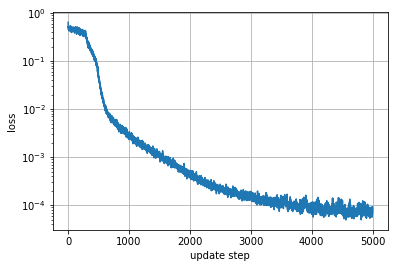

In [12]:
plt.plot(hist)
plt.xlabel("update step")
plt.ylabel("loss")
plt.yscale("log")
plt.grid(True)
plt.show()

## Evaluate your solution



In [14]:
def eval_model(N=10, t=0.):
    x = torch.linspace(0, 1, N)
    X = torch.stack([  # N0, (X, T = 0)
        x,
        torch.ones(N)*t
    ], axis=-1)
    mlp.eval()
    with torch.no_grad():
        p = mlp(X)
    return x.numpy(), p.numpy().ravel()

x, p = eval_model(N=20, t=0.5)
x , p 

(array([0.        , 0.05263158, 0.10526316, 0.15789473, 0.21052632,
        0.2631579 , 0.31578946, 0.36842105, 0.42105263, 0.47368422,
        0.5263158 , 0.57894737, 0.6315789 , 0.68421054, 0.7368421 ,
        0.78947365, 0.84210527, 0.8947368 , 0.94736844, 1.        ],
       dtype=float32),
 array([-0.00118152, -0.32338932, -0.61209   , -0.8361134 , -0.9707667 ,
        -1.0007484 , -0.92207164, -0.7427299 , -0.48198026, -0.16828664,
         0.16384453,  0.4777747 ,  0.7389079 ,  0.9186271 ,  0.9975095 ,
         0.9674396 ,  0.83238083,  0.6077416 ,  0.31844866, -0.00399217],
       dtype=float32))

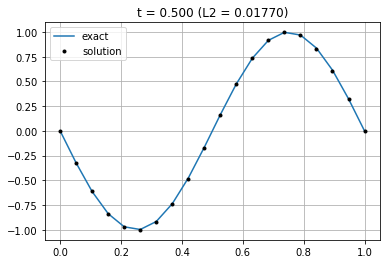

In [15]:
def plot_model(x, p, t):
    pe = np.sin(2.*np.pi*(x-U*t))
    plt.plot(x, pe, label="exact")
    plt.plot(x, p, '.k', label="solution")
    plt.legend()
    plt.grid(True)
    l2 = np.sqrt(np.sum((p-pe)**2))
    plt.title(f"t = {t:.3f} (L2 = {l2:.5f})")
    plt.show()
    
plot_model(x, p, 0.5)

## What nangs provides you

Nangs will provide you with classes and functions to abstract some of the concepts explained here in order to enable fast experimentation while allowing you to customize it to your needs.